In [1]:
from functions_for_all_nutrients import *
from iron_hemoglobin_functions import *

# Impact

In [120]:
zinc = pd.read_pickle('results_raw/zinc.pkl')
zinc['nutrient'] = 'zinc'
zinc_prev = pd.read_pickle('results_raw/zinc_deficiency_exposure.pkl')
zinc_prev['measure'] = 'deficiency_exposure'

vitamin_a = pd.read_pickle('results_raw/vitamin_a.pkl')
vitamin_a['nutrient'] = 'vitamin a'
vitamin_a_prev = pd.read_pickle('results_raw/vitamin_a_deficiency_exposure.pkl')
vitamin_a_prev['measure'] = 'deficiency_exposure'

iron_u5 = pd.read_pickle('results_raw/iron_u5.pkl')
iron_u5['nutrient'] = 'iron'
iron_u5 = iron_u5.loc[iron_u5.year==2025]
iron_wra = pd.read_pickle('results_raw/iron_wra.pkl')
iron_wra['nutrient'] = 'iron'
iron = (iron_wra.set_index([c for c in iron_wra.columns if 'draw' not in c]) 
        + iron_u5.set_index([c for c in iron_wra.columns if 'draw' not in c])).reset_index()

results = pd.concat([zinc, vitamin_a, iron, vitamin_a_prev, zinc_prev], ignore_index=True, sort=True)
results['nutrient'] = results.nutrient.str.replace('vitamin a','vitamin A')
results['nutrient_name'] = results.nutrient.str.replace('_',' ').str.capitalize().str.replace('Vitamin a', 'Vitamin A')
l = get_ids('location')[['location_name','location_id']]
results = results.merge(l, on='location_id')
results['label'] = results.nutrient_name + ' in ' + results.vehicle
results = results.loc[results.year==2025]
results.head()

coverage_level    draw_0    draw_1   draw_10  draw_100  draw_101  \
12             0.2  0.125649  0.338091  0.488604  0.400990  0.327796   
13             0.5  0.314121  0.845226  1.221511  1.002474  0.819490   
14             0.8  0.502594  1.352362  1.954417  1.603959  1.311184   
27             0.2  0.634325  0.103519  0.634680  0.869303  0.143618   
28             0.5  1.585813  0.258798  1.586701  2.173258  0.359044   

    draw_102  draw_103  draw_104  draw_105  ...  draw_998  draw_999  \
12  0.349153  0.529618  0.401699  0.431137  ...  0.449194  0.417276   
13  0.872881  1.324046  1.004248  1.077842  ...  1.122984  1.043190   
14  1.396610  2.118473  1.606797  1.724547  ...  1.796774  1.669104   
27  0.237264  0.410100  1.538719  1.691311  ...  0.911400  1.265634   
28  0.593161  1.025249  3.846796  4.228277  ...  2.278499  3.164085   

    location_id         measure  nutrient      vehicle    year  nutrient_name  \
12           15             pif      zinc  wheat flour  2025.0           Zinc   
13           15             pif      zinc  wheat flour  2025.0           Zinc   
14           15             pif      zinc  wheat flour  2025.0           Zinc   
27           15  counts_averted      zinc  wheat flour  2025.0           Zinc   
28           15  counts_averted      zinc  wheat flour  2025.0           Zinc   

    location_name                label  
12        Myanmar  Zinc in wheat flour  
13        Myanmar  Zinc in wheat flour  
14        Myanmar  Zinc in wheat flour  
27        Myanmar  Zinc in wheat flour  
28        Myanmar  Zinc in wheat flour  

[5 rows x 1009 columns]

In [121]:
username = !whoami
coverage_confidence_data_dir = f'/ihme/homes/{username[0]}/notebooks/vivarium_research_lsff/data_prep/outputs/data_richness_score.csv'
confidence = pd.read_csv(coverage_confidence_data_dir).replace('vitamin a','vitamin A')
confidence.head()

location_name      vehicle   nutrient  score
0       Cameroon  maize flour       zinc    0.0
1      Indonesia          oil  vitamin A    0.0
2  Côte d'Ivoire  maize flour       zinc    0.0
3  Côte d'Ivoire  maize flour  vitamin A    0.0
4  Côte d'Ivoire  maize flour       iron    0.0

In [20]:
def make_dot_plots_by_nutrient_vehicle_pair(data, nutrient, measure, coverage_levels, confidence_data):
    """This function takes a dataframe,
    nutrient (as a string),
    and measure (as a string, either: 'rates', 'counts', or 'pifs').
    """

    f, ax = plt.subplots(figsize=(7, 4), dpi=120)
    colors = ['tab:red', 'tab:orange', 'tab:green']

    location_spacer = 0.15
    coverage_spacer = 0.025
    df = (data.drop(columns='measure', errors='ignore')
          .apply(pd.DataFrame.describe, percentiles=[0.025, 0.975], axis=1).reset_index())

    order = df.reset_index()
    order = list(
        order.loc[order.coverage_level == 0.8].loc[order.year == 2025].sort_values(by='mean').location_id.values)
    nums = list(range(0, len(order)))
    orders = pd.DataFrame()
    orders['location_id'] = order
    orders['order'] = nums
    df = df.merge(orders, on='location_id').sort_values(by='order', ascending=False)

    for n in list(range(0, len(coverage_levels))):
        rate = (df.loc[df.year == 2025]
            .loc[df.coverage_level == coverage_levels[n]])
        for i in list(range(0, len(rate))):
            plt.plot([location_spacer * i + coverage_spacer * n, location_spacer * i + coverage_spacer * n],
                     [rate['2.5%'].values[i], rate['97.5%'].values[i]], c='black')
            plt.scatter([location_spacer * i + coverage_spacer * n], rate['2.5%'].values[i], s=50, marker='_',
                        c='black')
            plt.scatter([location_spacer * i + coverage_spacer * n], rate['97.5%'].values[i], s=50, marker='_',
                        c='black')

        x_vals = []
        for x in list(range(0, len(rate))):
            x_vals.append(location_spacer * x + coverage_spacer * n)
        plt.scatter(x_vals, rate['mean'], s=50,
                    label=f'{int(coverage_levels[n] * 100)} percent coverage', color=colors[n])

    plt.hlines(0, 0 - coverage_spacer * 2,
               location_spacer * (len(rate)) - coverage_spacer * 2,
               linestyle='dashed', color='grey', alpha=0.5)

    plt.plot()

    if measure == 'rates_averted':
        plt.title(f'DALYs averted per 100,000 person-years due to\n{nutrient} fortication in {vehicle}')
        plt.ylabel('DALYs Averted per 100,000')
    elif measure == 'counts_averted':
        plt.title(f'DALYs averted due to\n{nutrient} fortication in {vehicle}')
        plt.ylabel('DALYs')
    elif measure == 'pif':
        plt.title(f'Population impact fraction of {nutrient} fortication in {vehicle}\non DALYs as a proportion of {nutrient} deficiency attributable DALYs')
        plt.ylabel('Population Impact Fraction (Percent)')

    plt.legend(bbox_to_anchor=[1.5, 1])
    
    rate = rate.merge(confidence_data.replace('vitamin a','vitamin A'), on=['location_name','nutrient','vehicle'])
    rate['label'] = (np.where(rate.score == 5, '***** ',
                      np.where(rate.score == 4, '**** ',
                               np.where(rate.score == 3, '*** ',
                                        np.where(rate.score == 2, '** ',
                                                 np.where(rate.score == 1, '* ', '')))))
                   + rate.location_name)


    x_ticks = []
    for x in list(range(0, len(rate))):
        x_ticks.append(location_spacer * x + coverage_spacer)
    ax.set_xticks(x_ticks)
    plt.xticks(rotation=90)
    ax.set_xticklabels(rate.label.values)

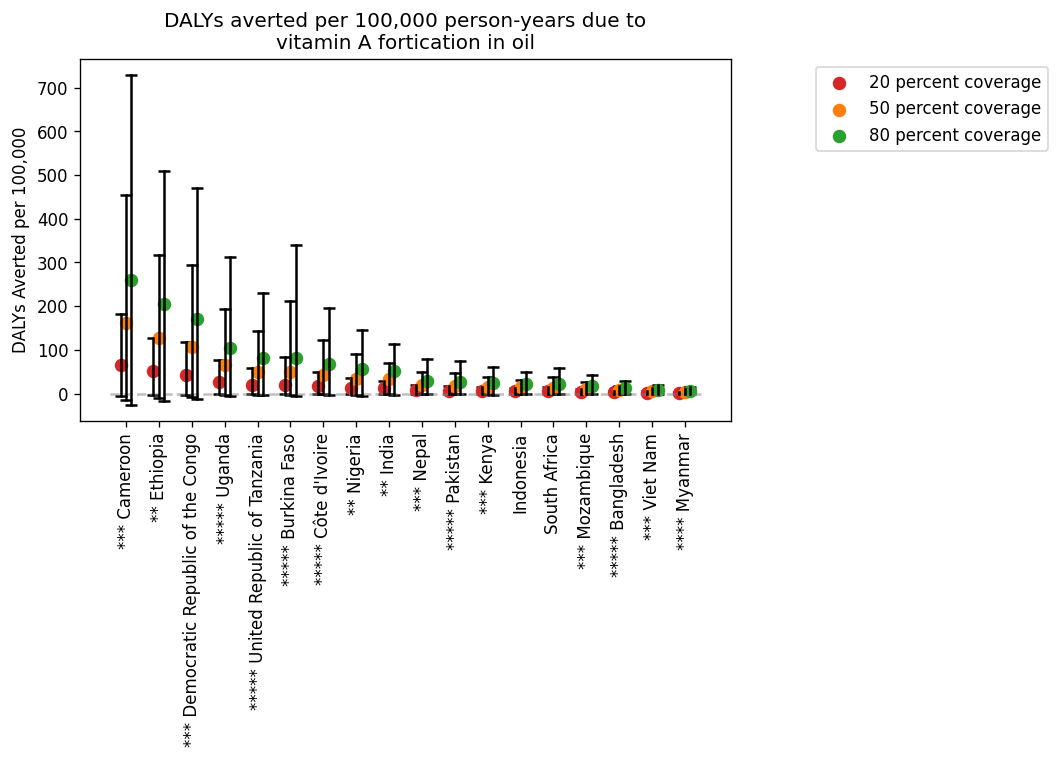

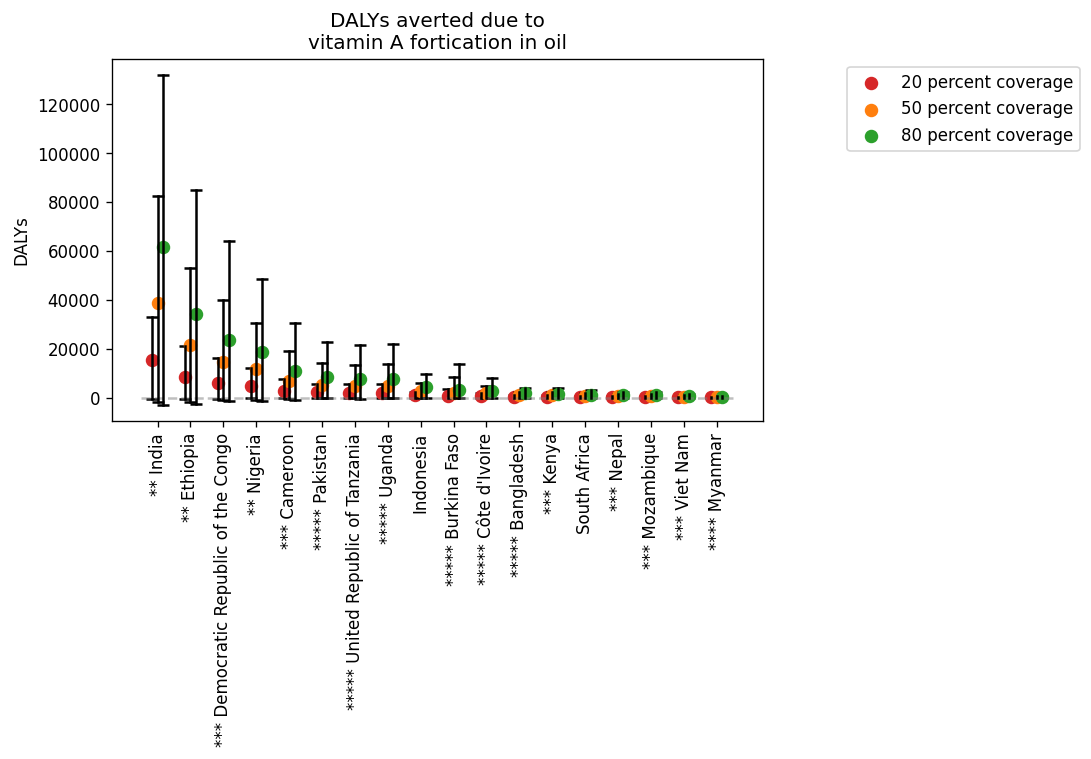

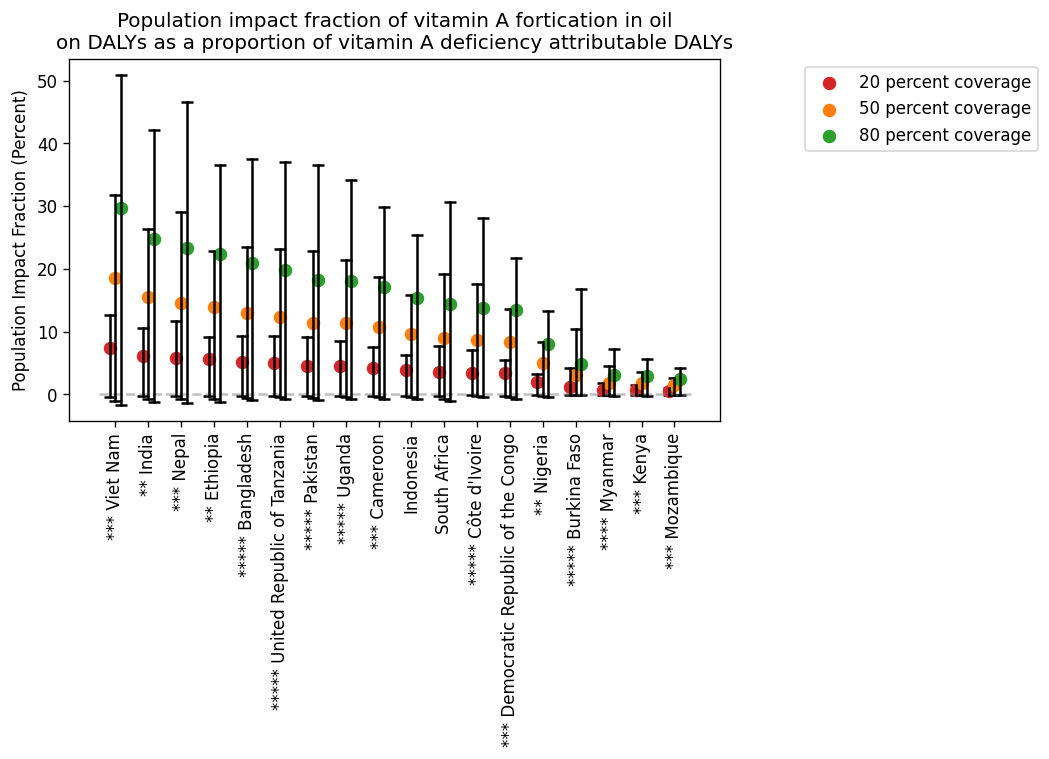

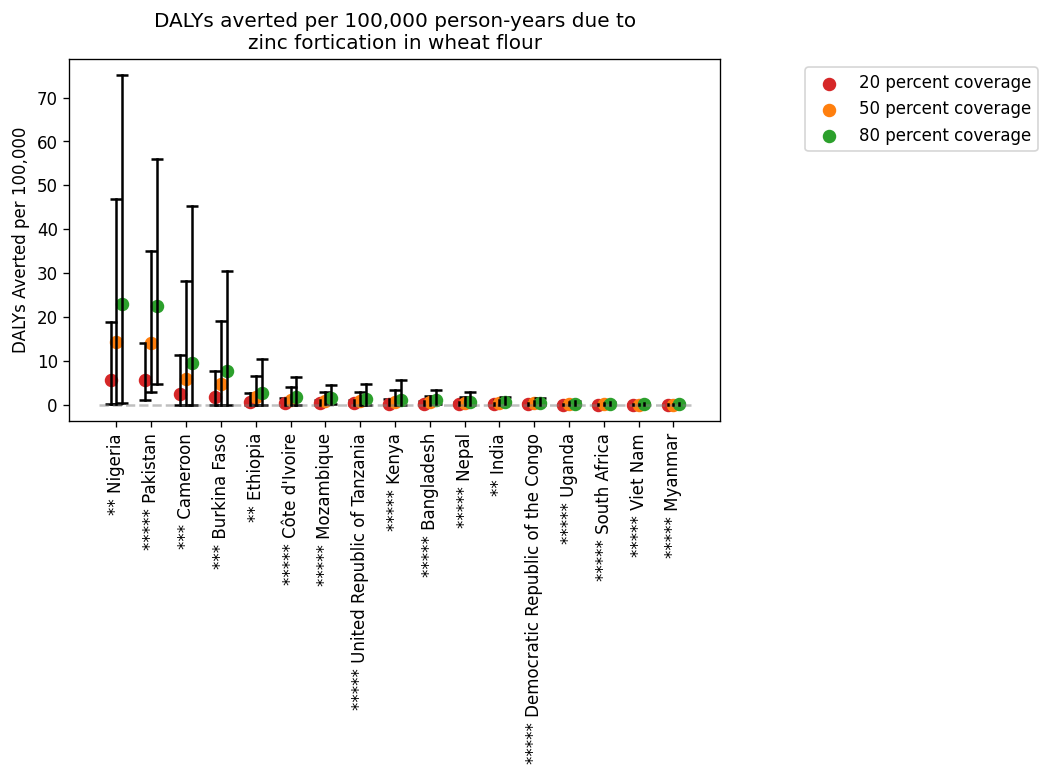

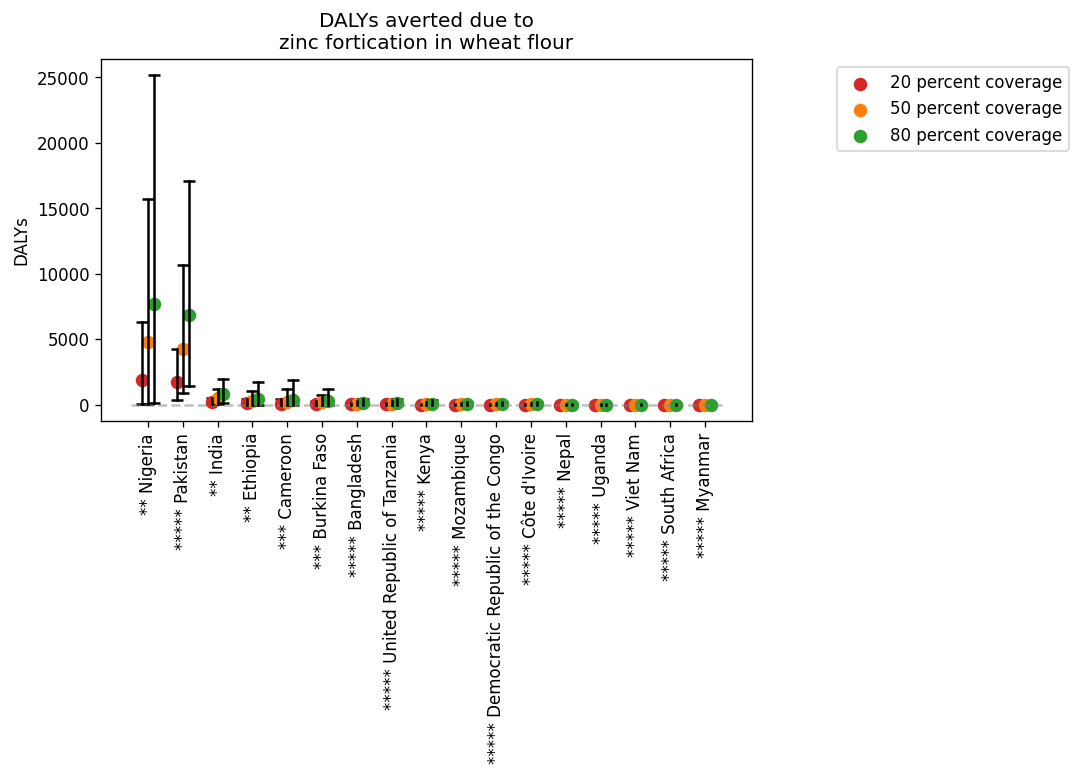

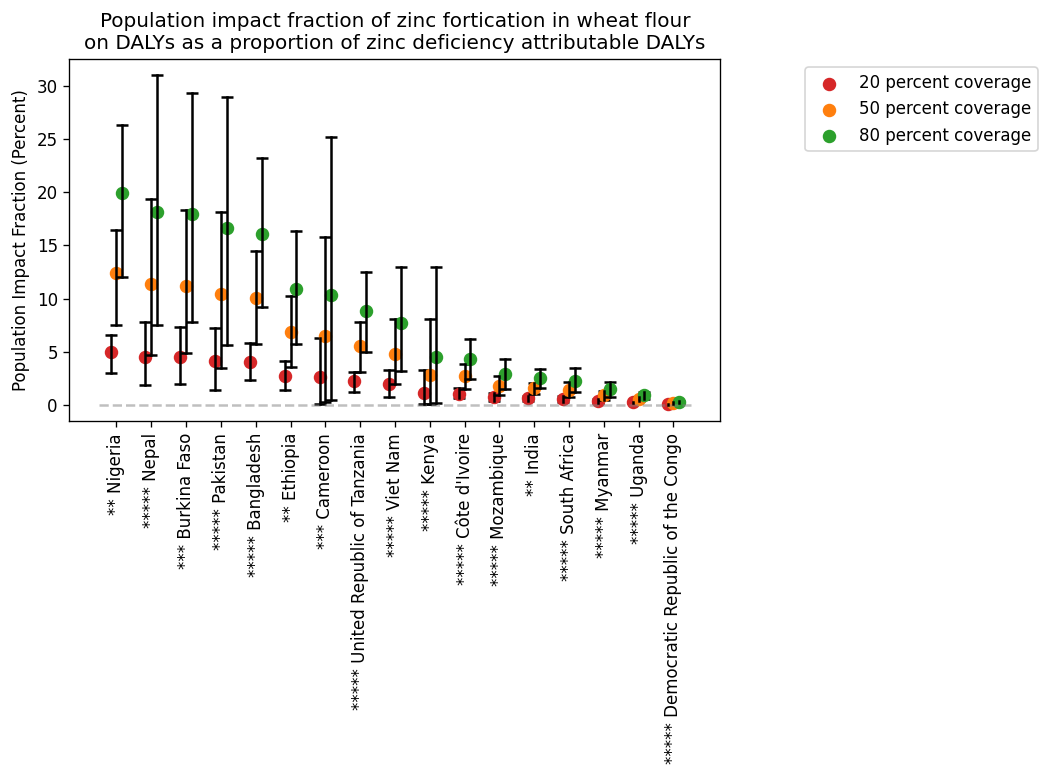

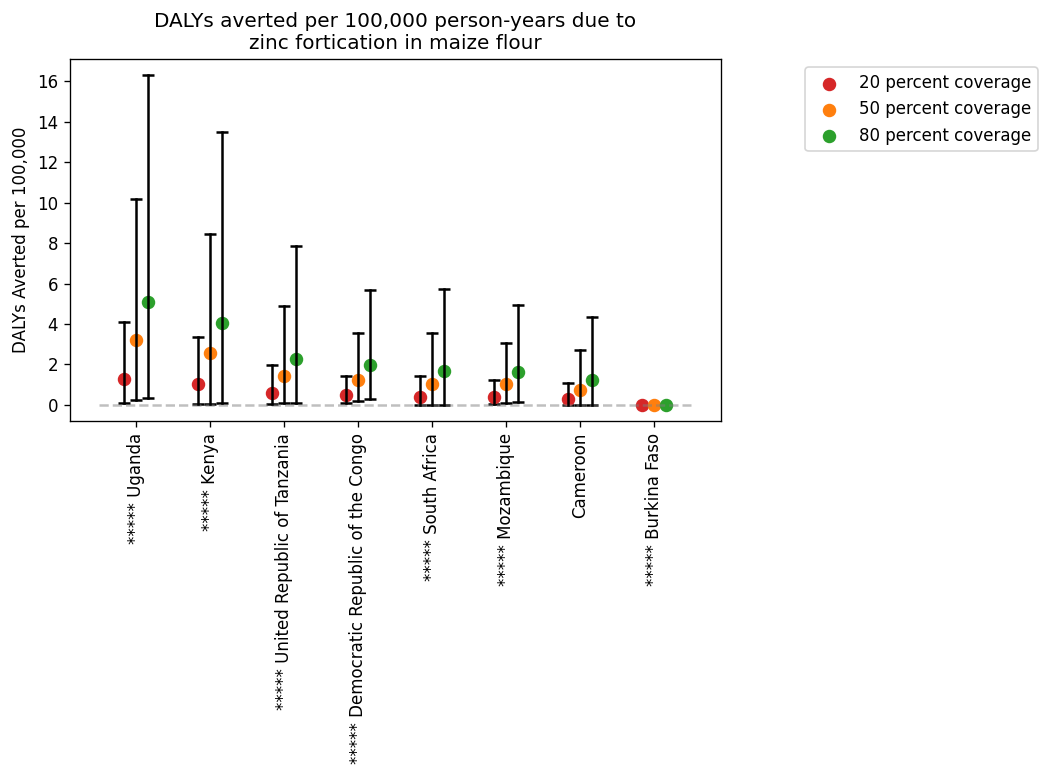

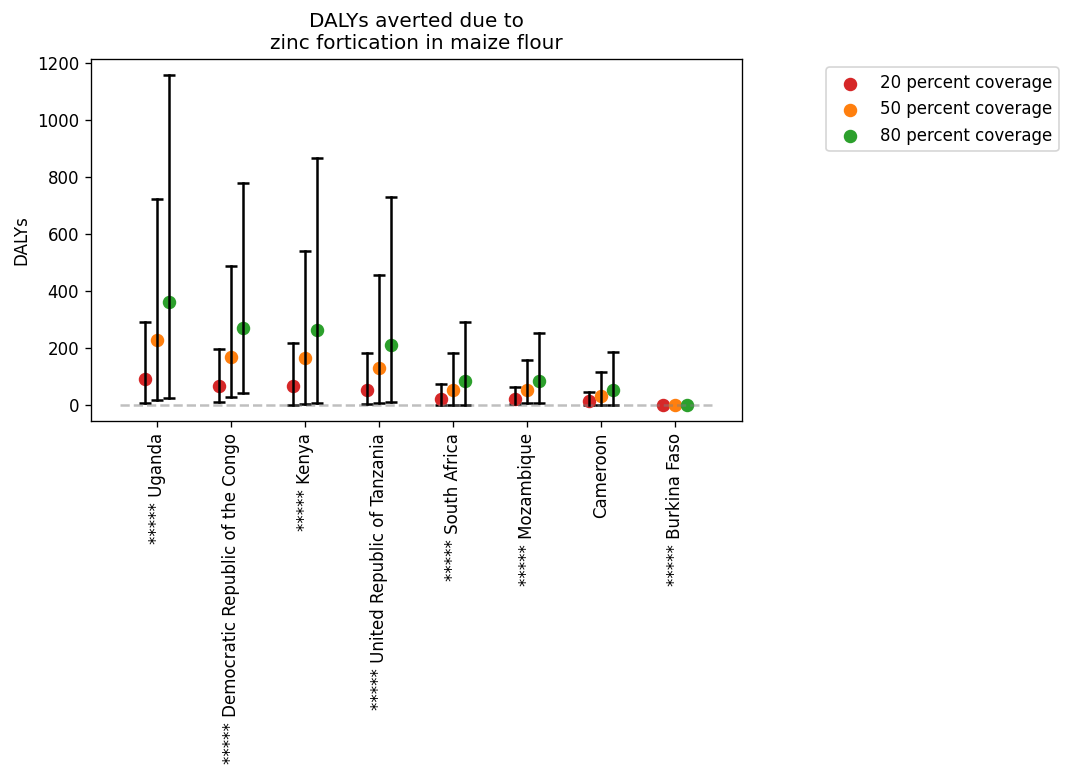

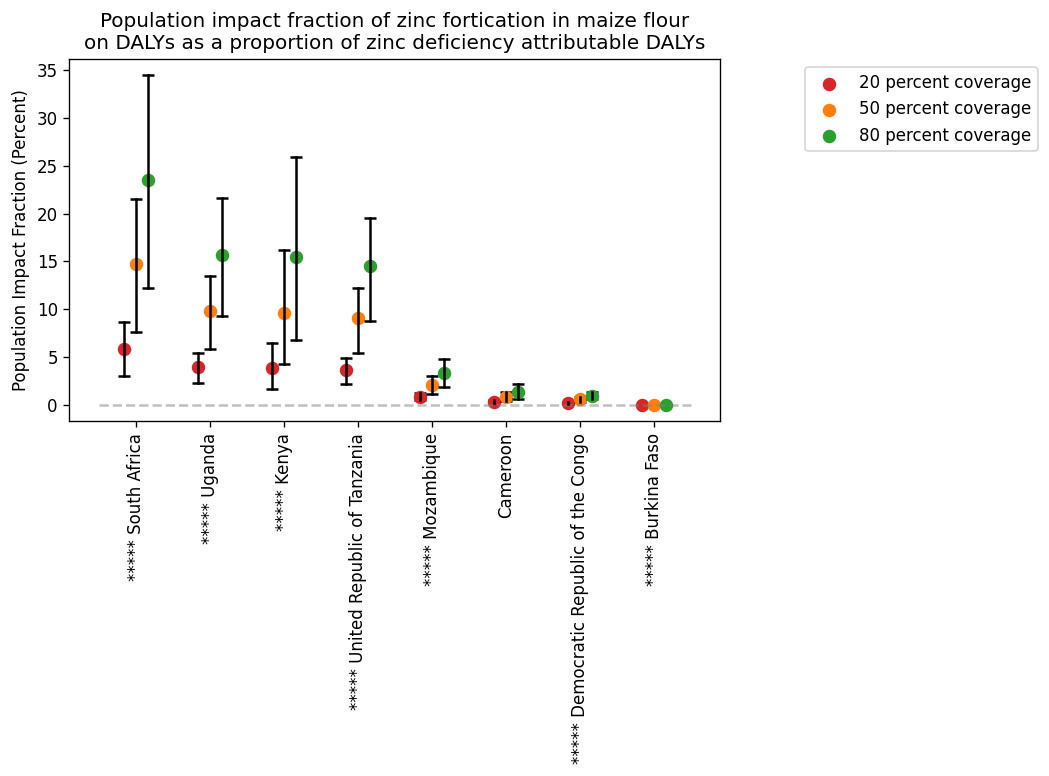

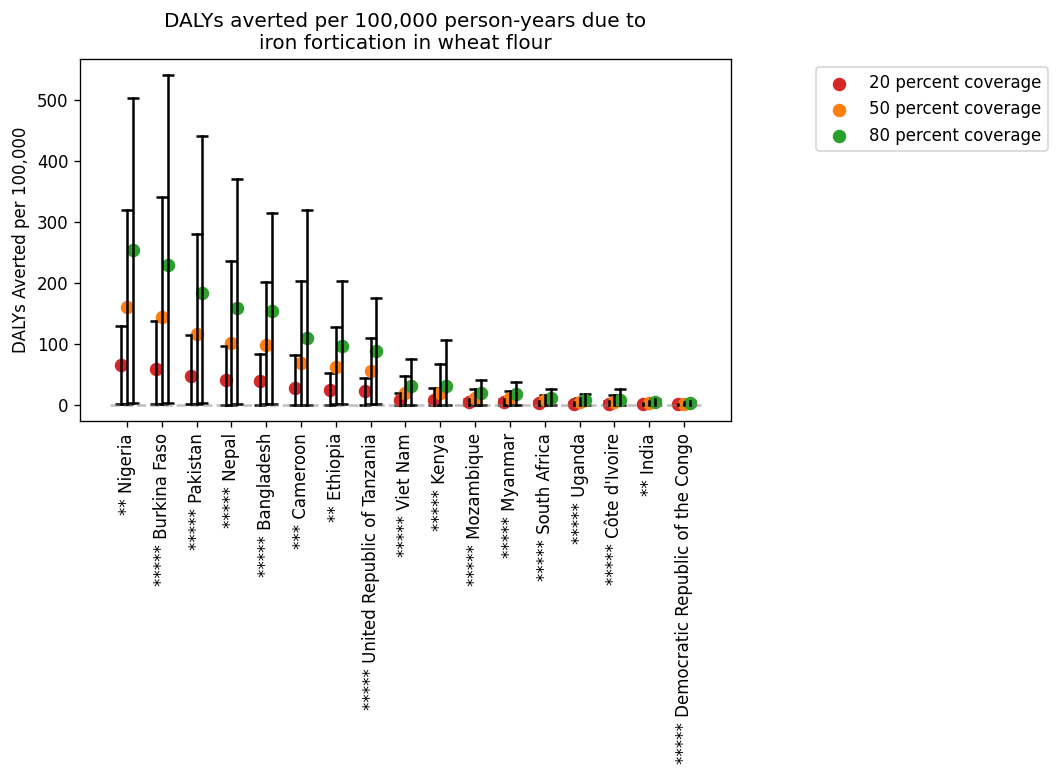

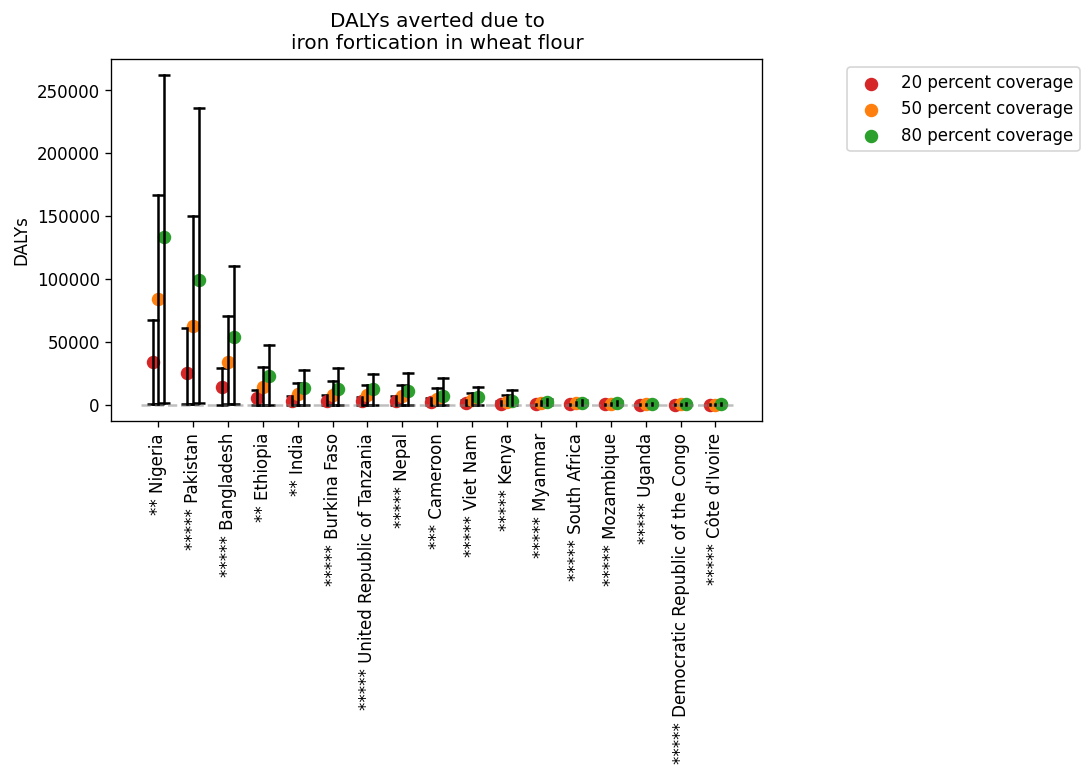

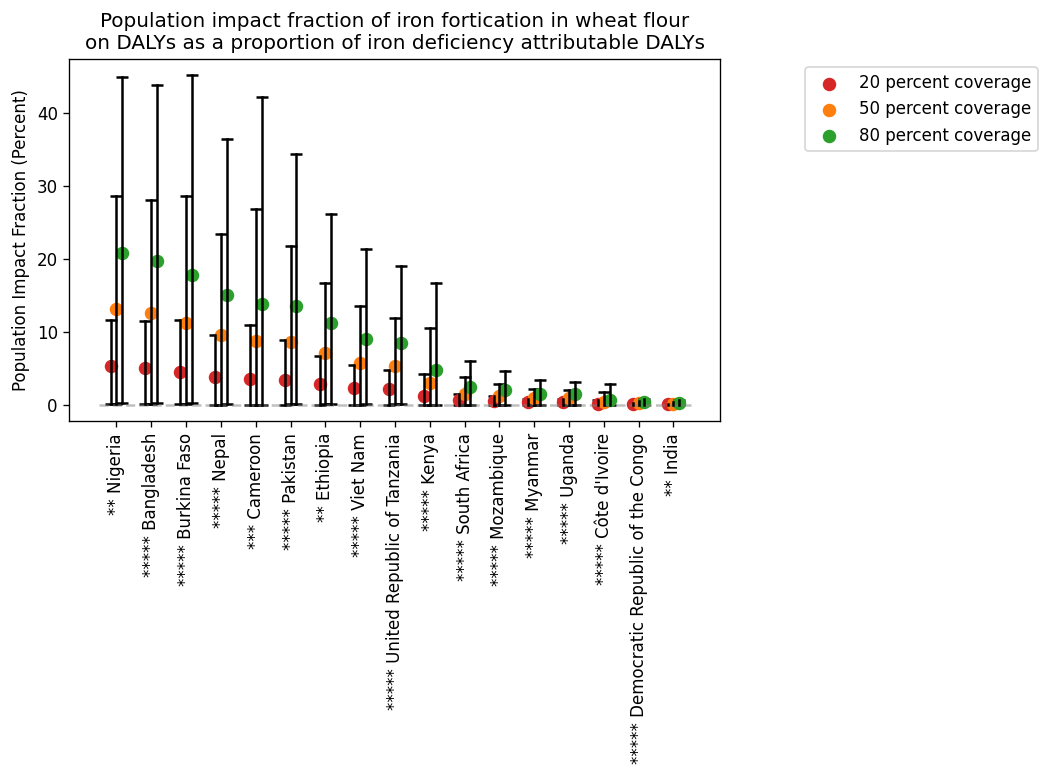

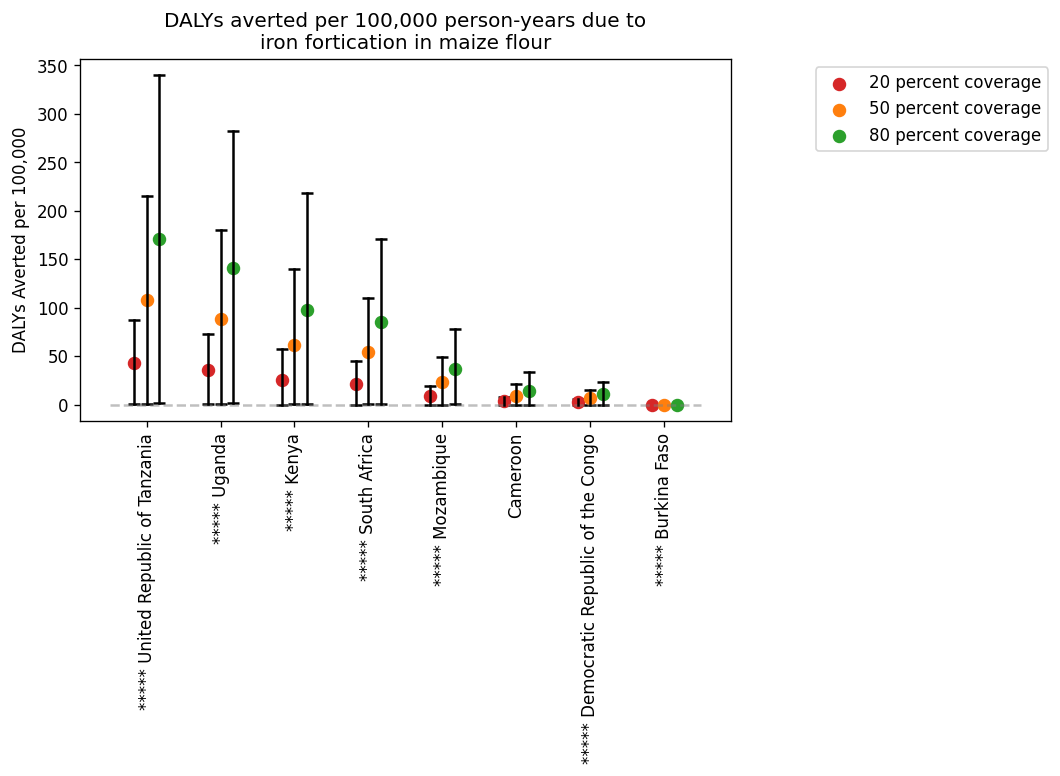

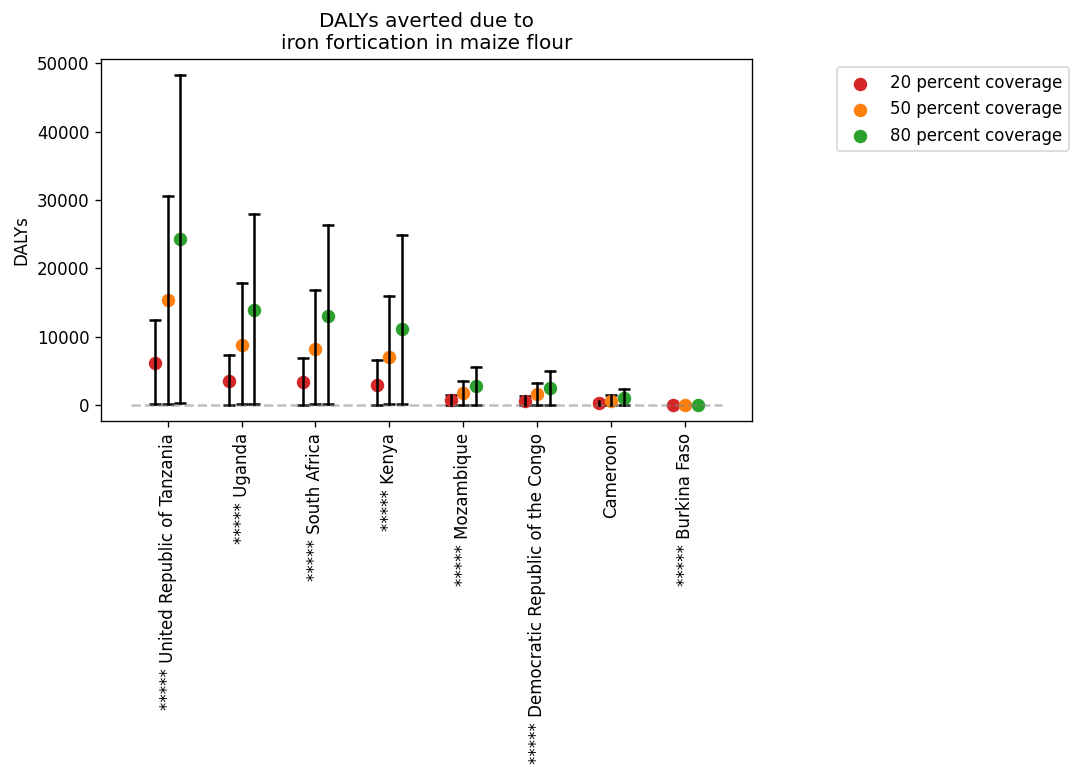

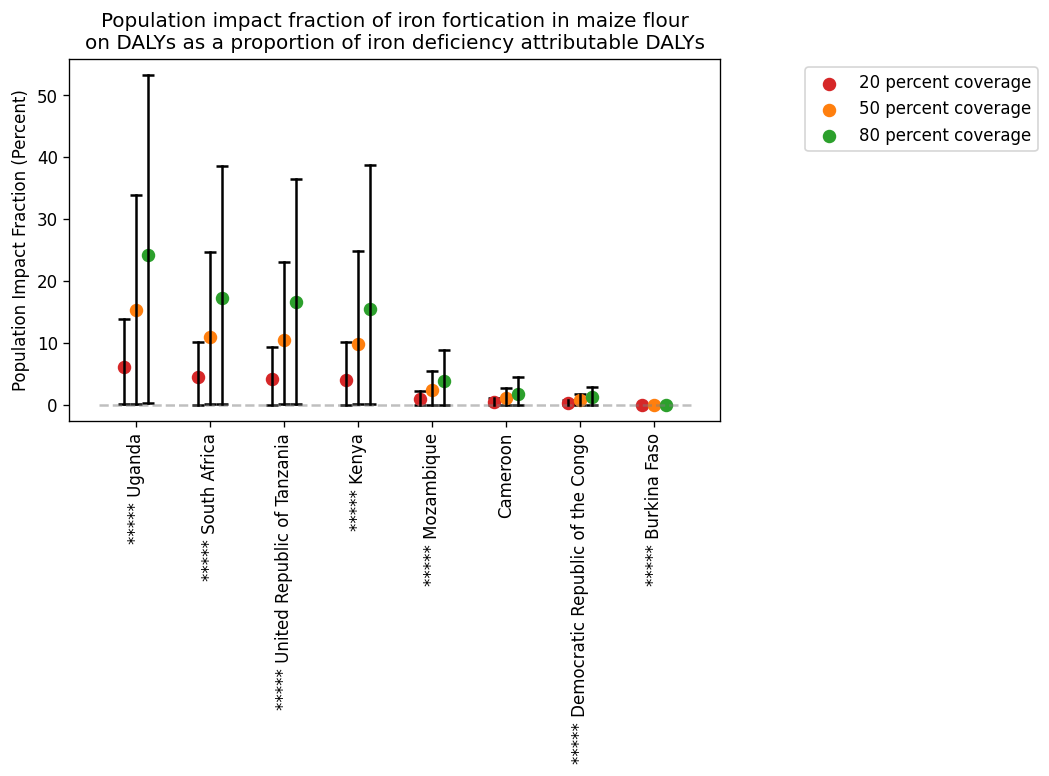

In [22]:
nutrients = ['vitamin A','zinc','iron']
measures = ['rates_averted','counts_averted','pif']
coverage_levels = [0.2,0.5,0.8]

with PdfPages('results_plots/impact_by_nutrient_vehicle_pair.pdf') as pdf:
    for nutrient in nutrients:
        if nutrient == 'vitamin A':
            vehicles = ['oil']
        else:
            vehicles = ['wheat flour', 'maize flour']
        for vehicle in vehicles:
            for measure in measures:
                plot = (results.loc[results.nutrient == nutrient]
                        .loc[results.vehicle == vehicle]
                        .loc[results.measure == measure]
                        .set_index([c for c in results.columns if 'draw' not in c]))
                make_dot_plots_by_nutrient_vehicle_pair(plot,
                              nutrient,
                              measure,
                              coverage_levels,
                              confidence)
                pdf.savefig(bbox_inches='tight')

In [24]:
coverage_levels = [0.2,0.5,0.8]

def make_location_specific_plots(data, location_id, measure, coverage_levels):
    data_loc = (data
                .loc[data.location_id==location_id]
                .loc[data.year==2025]
                .loc[data.measure == measure]
                .sort_values(by=['nutrient','vehicle']))
    
    f, ax = plt.subplots(figsize=(7, 4), dpi=120)
    colors = ['tab:red', 'tab:orange', 'tab:green']
    nutrient_spacer = 0.15
    coverage_spacer = 0.025
    data_loc = (data_loc.set_index([c for c in data_loc.columns if 'draw' not in c])
                .apply(pd.DataFrame.describe, percentiles=[0.025, 0.975], axis=1).reset_index())
    
    for n in list(range(0, len(coverage_levels))):
        df = (data_loc.loc[data_loc.coverage_level == coverage_levels[n]])
        for i in list(range(0, len(df))):
            plt.plot([nutrient_spacer * i + coverage_spacer * n, nutrient_spacer * i + coverage_spacer * n],
                     [df['2.5%'].values[i], df['97.5%'].values[i]], c='black')
            plt.scatter([nutrient_spacer * i + coverage_spacer * n], df['2.5%'].values[i], s=50, marker='_',
                        c='black')
            plt.scatter([nutrient_spacer * i + coverage_spacer * n], df['97.5%'].values[i], s=50, marker='_',
                        c='black')
            
        x_vals = []
        for x in list(range(0, len(df))):
            x_vals.append(nutrient_spacer * x + coverage_spacer * n)
        plt.scatter(x_vals, df['mean'], s=50,
                    label=f'{int(coverage_levels[n] * 100)} percent coverage', color=colors[n])

    plt.hlines(0, 0 - coverage_spacer * 2,
               nutrient_spacer * (len(df)) - coverage_spacer * 2,
               linestyle='dashed', color='grey', alpha=0.5)
    
    plt.plot()
    
    l_name = data_loc.location_name.values[0]

    if measure == 'rates_averted':
        plt.title(f'{l_name}\nDALYs Averted per 100,000 Person-Years by Nutrient')
        plt.ylabel('DALYs Averted per 100,000')
    elif measure == 'counts_averted':
        plt.title(f'{l_name}\nDALYs Averted by Nutrient')
        plt.ylabel('DALYs')
    elif measure == 'pif':
        plt.title(f'{l_name}\nPopulation Impact Fractions by Nutrient\nDALYs Averted as a Fraction of DALYs Attributable to Respective Nutrient Deficiencies')
        plt.ylabel('Population Impact Fraction (Percent)')

    plt.legend(bbox_to_anchor=[1.5, 1])
    
    x_ticks = []
    for x in list(range(0, len(df))):
        x_ticks.append(nutrient_spacer * x + coverage_spacer)
    ax.set_xticks(x_ticks)
    ax.set_xticklabels(df.reset_index().label.values)
    plt.xticks(rotation=90)

/ihme/code/central_comp/miniconda_svc-ccomp/envs/v108/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # Remove the CWD from sys.path while we load stuff.


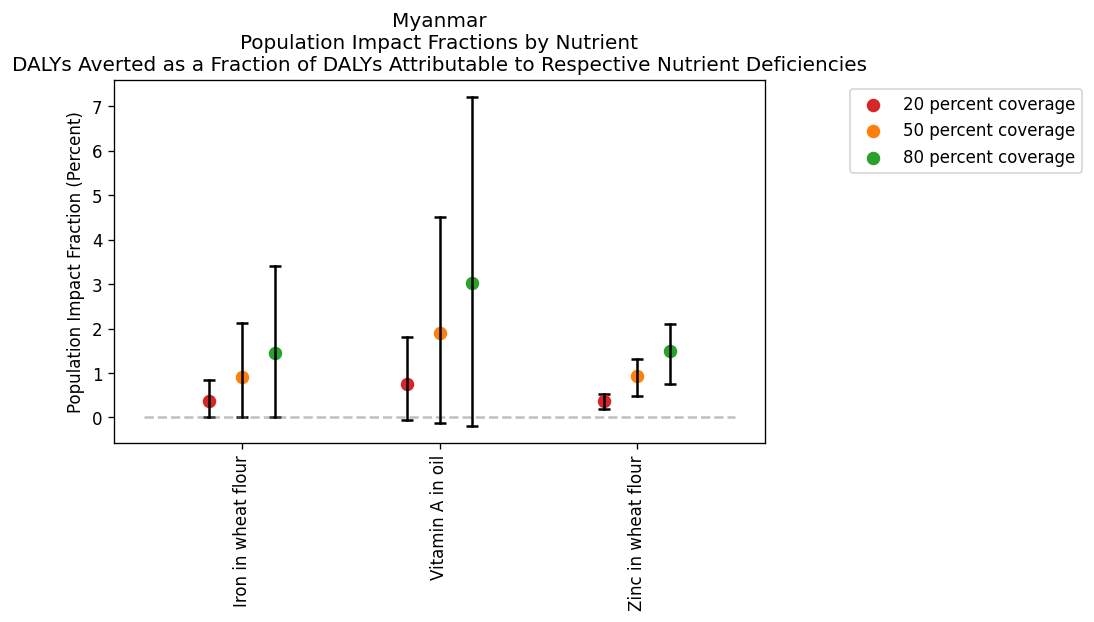

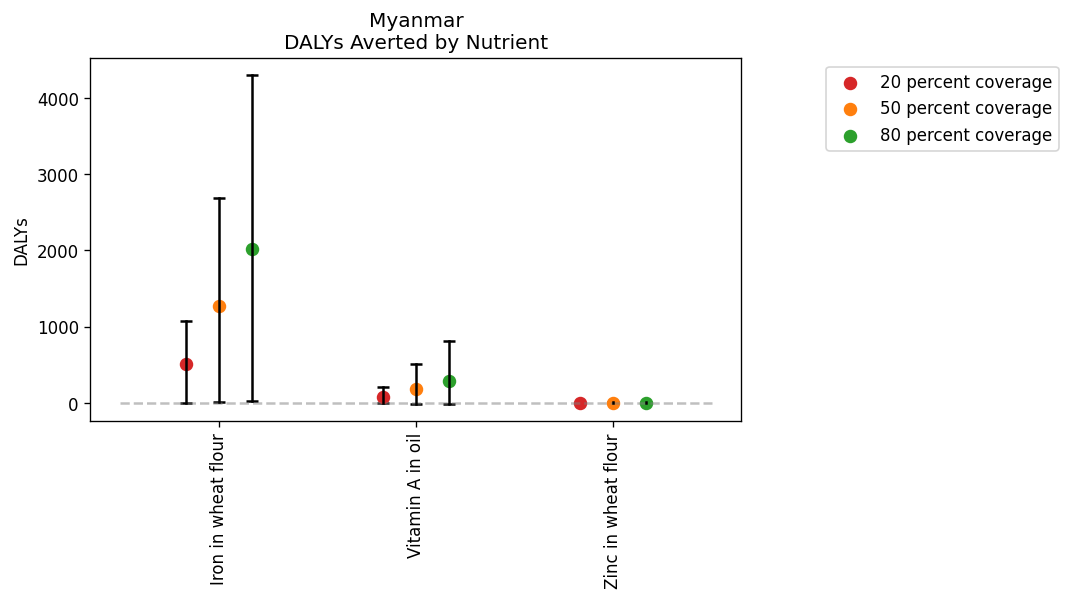

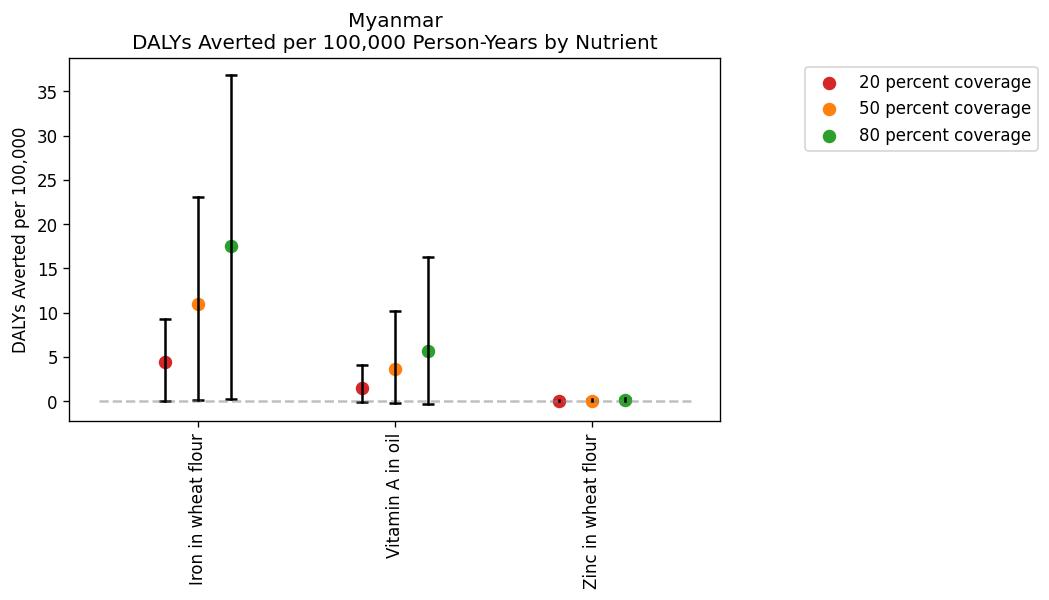

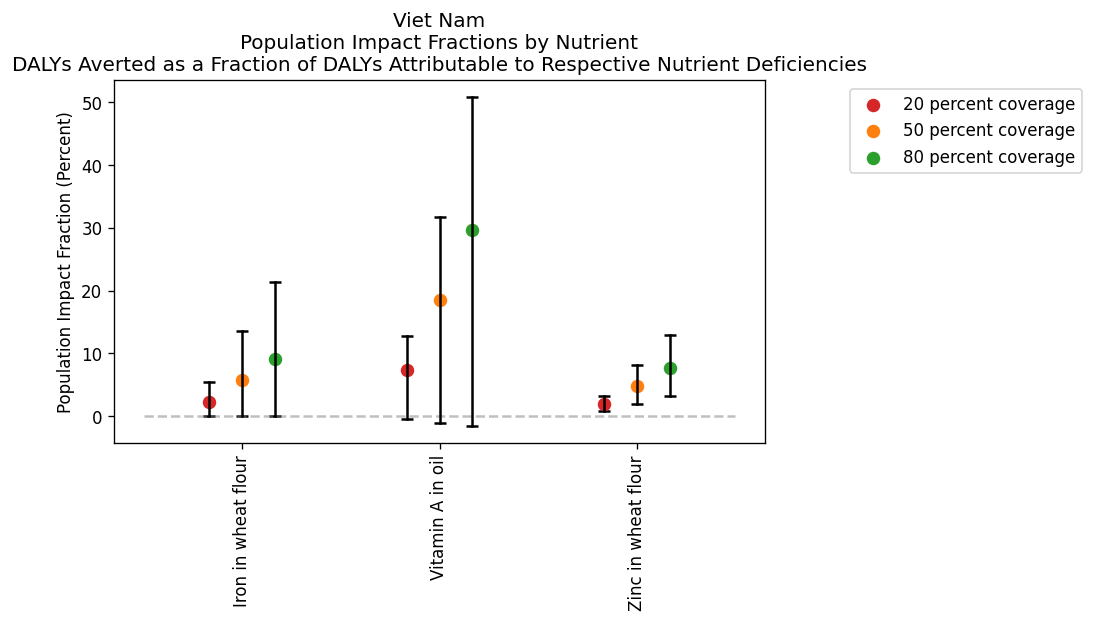

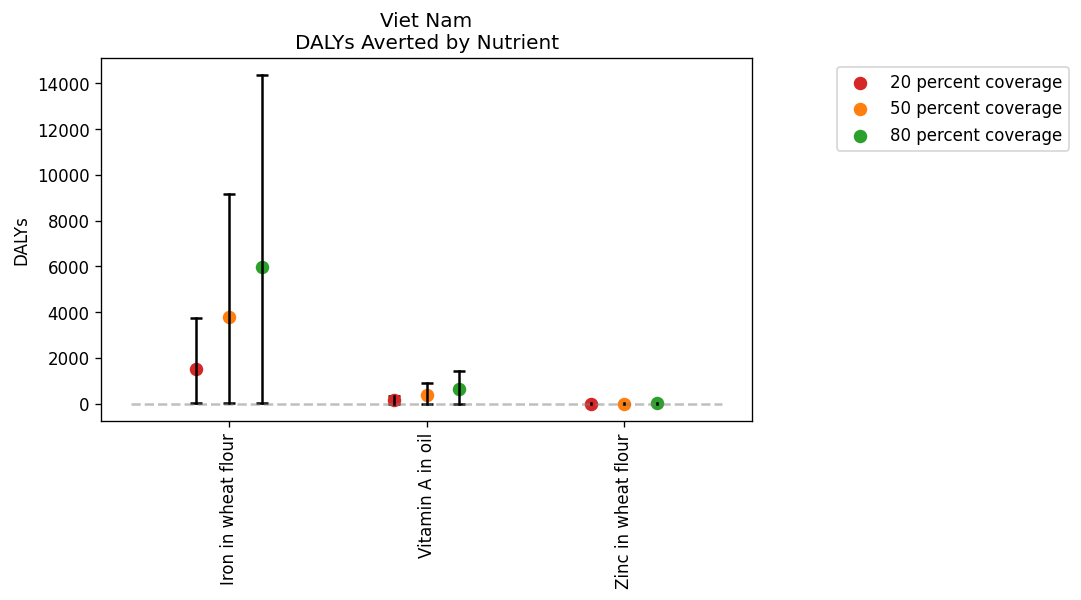

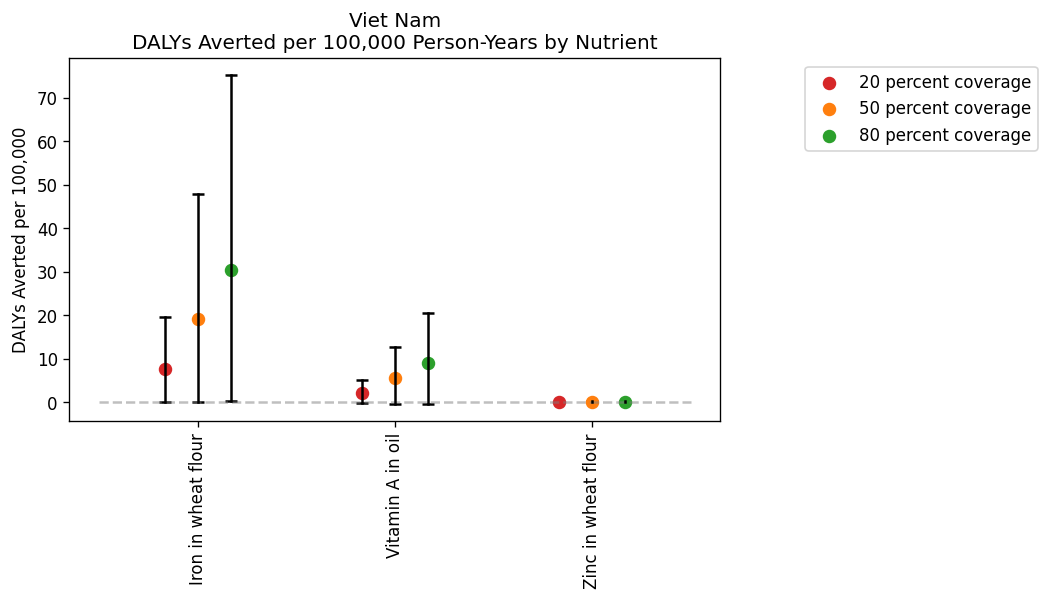

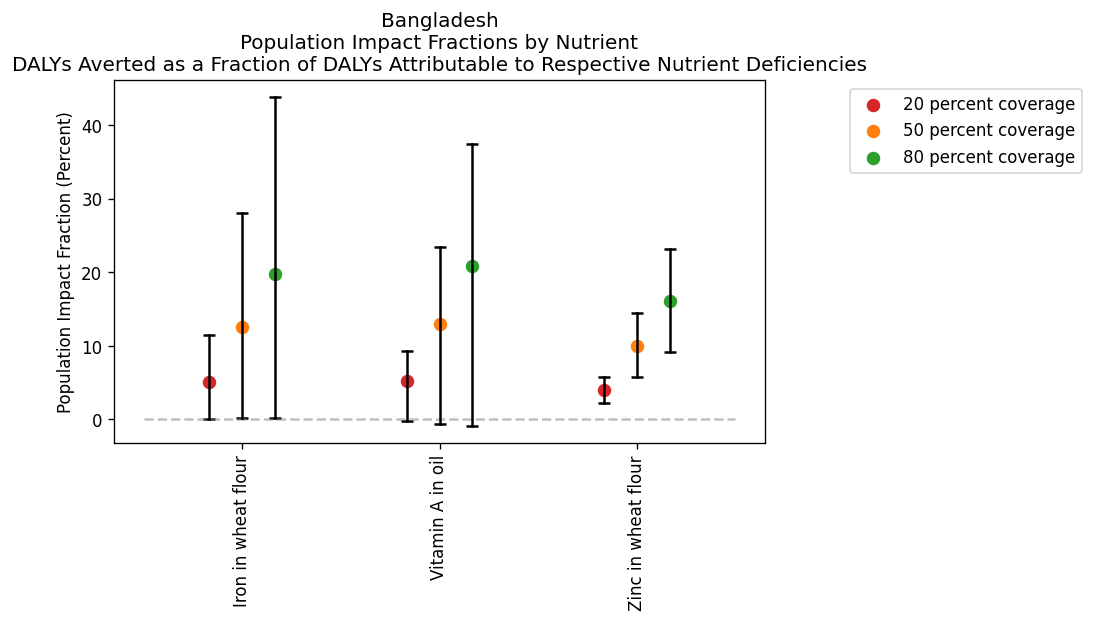

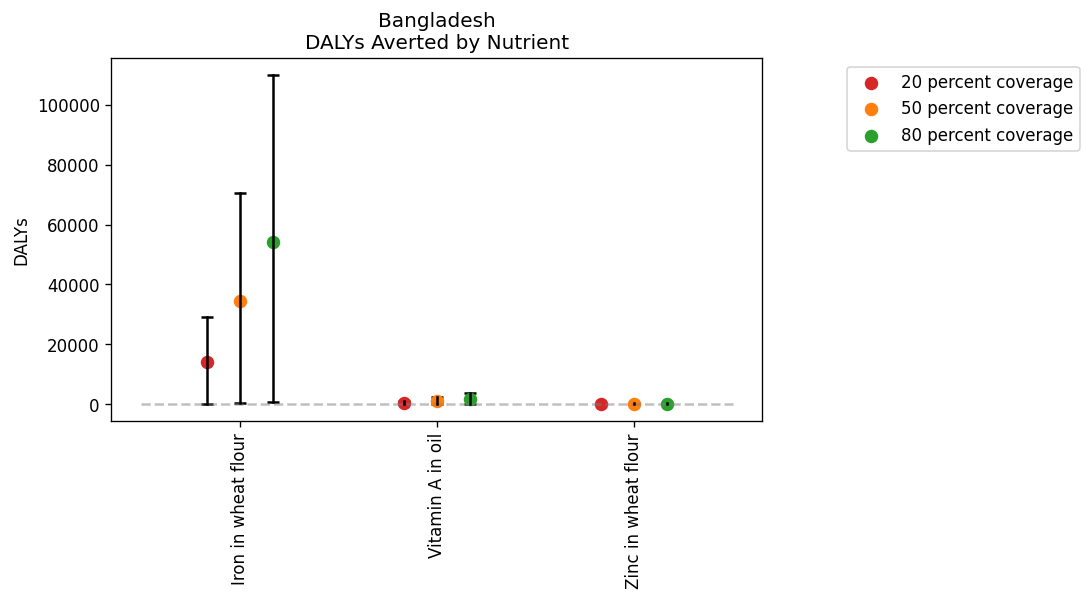

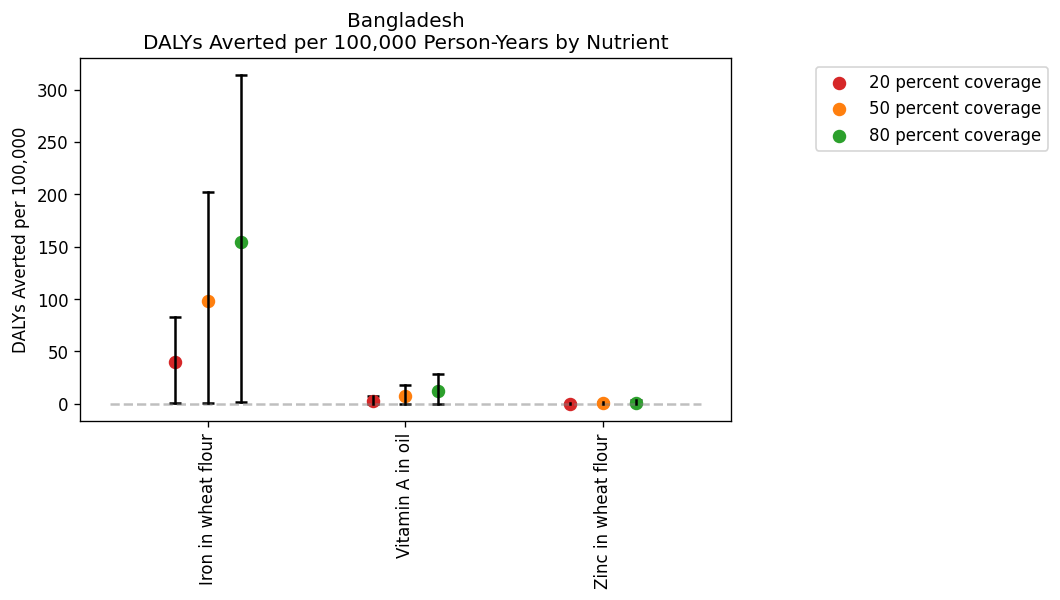

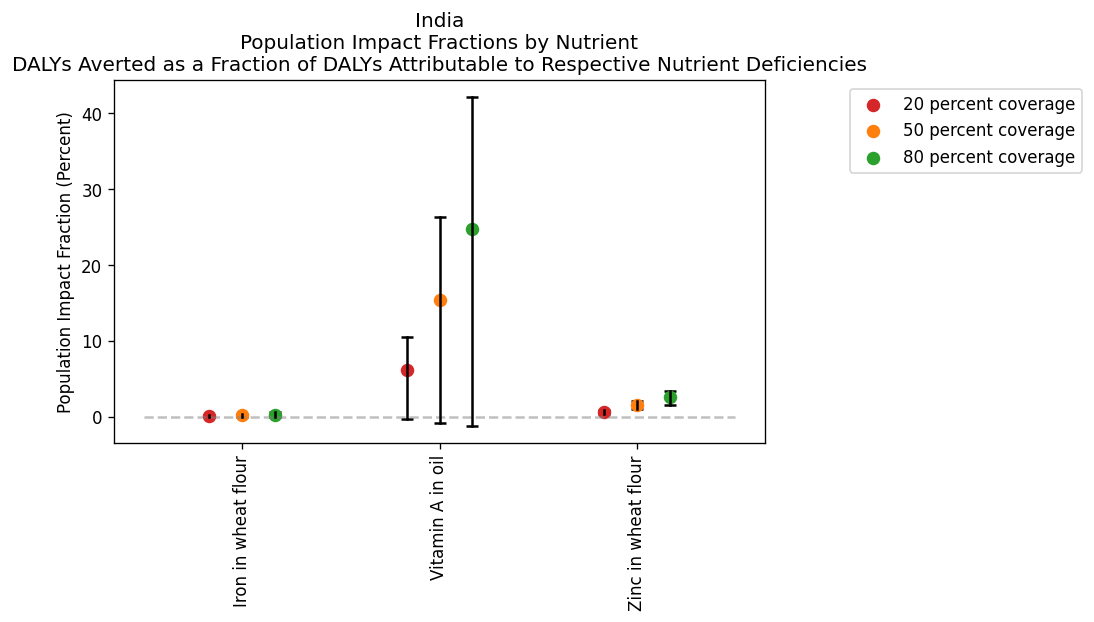

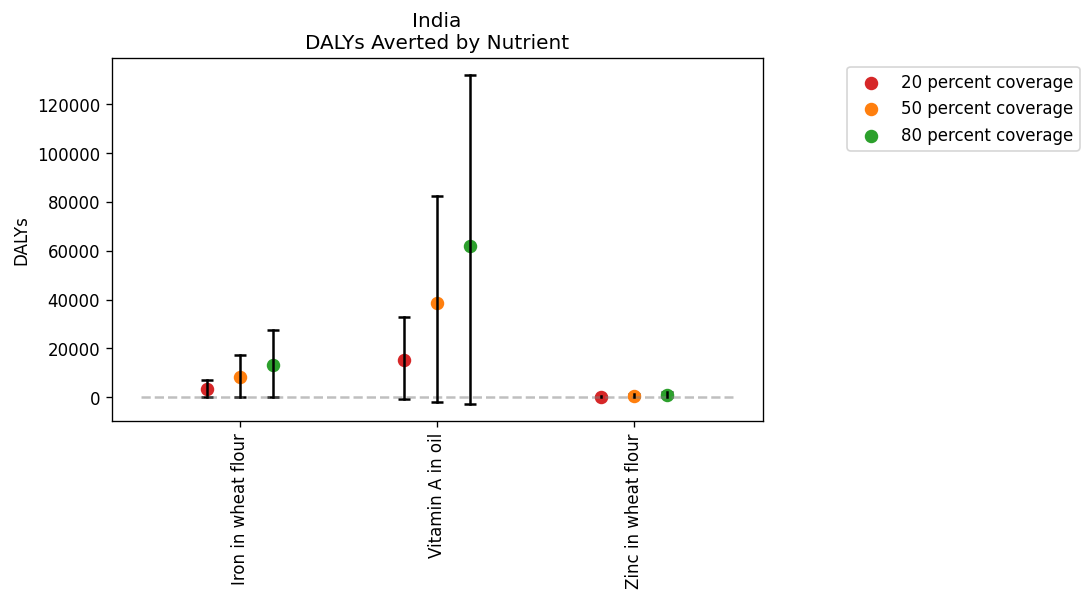

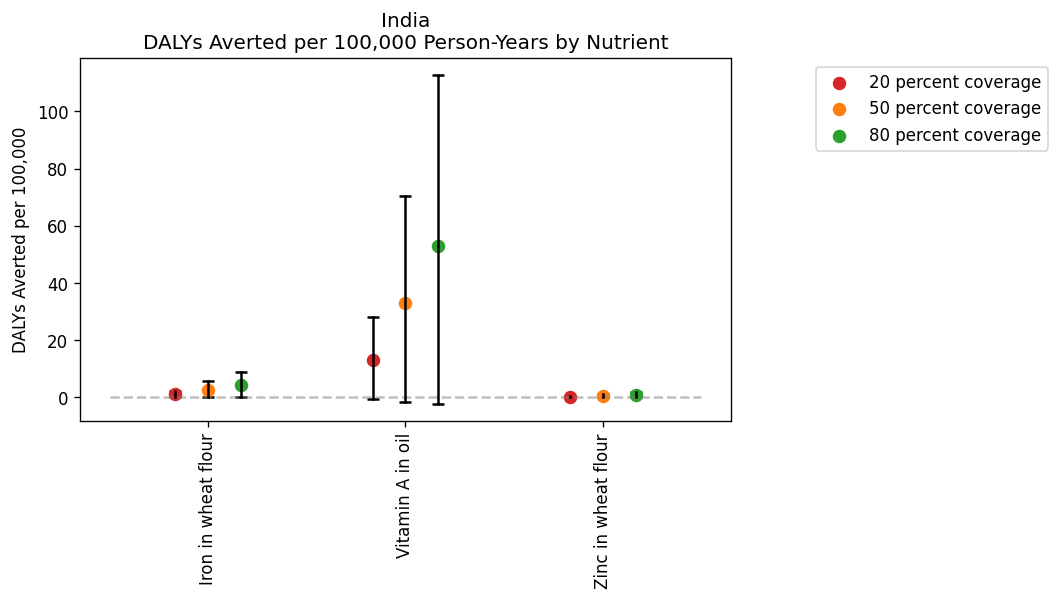

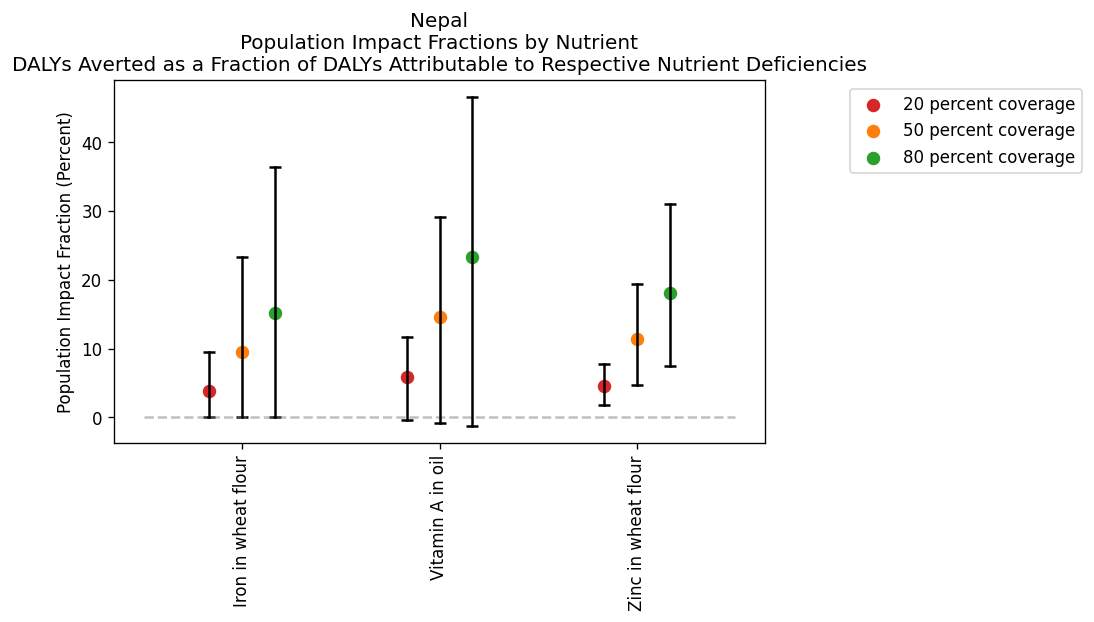

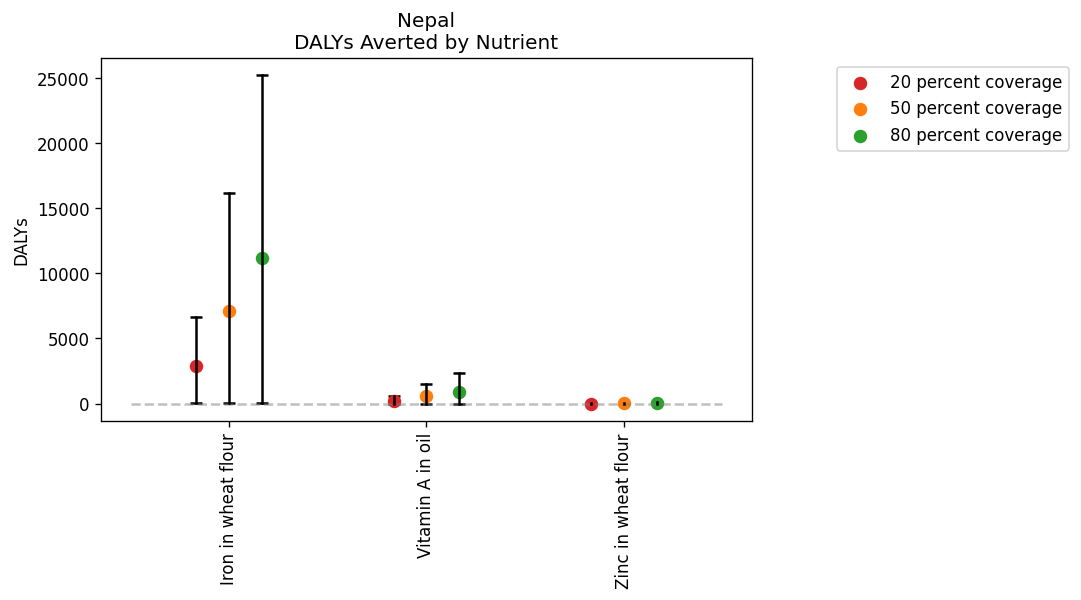

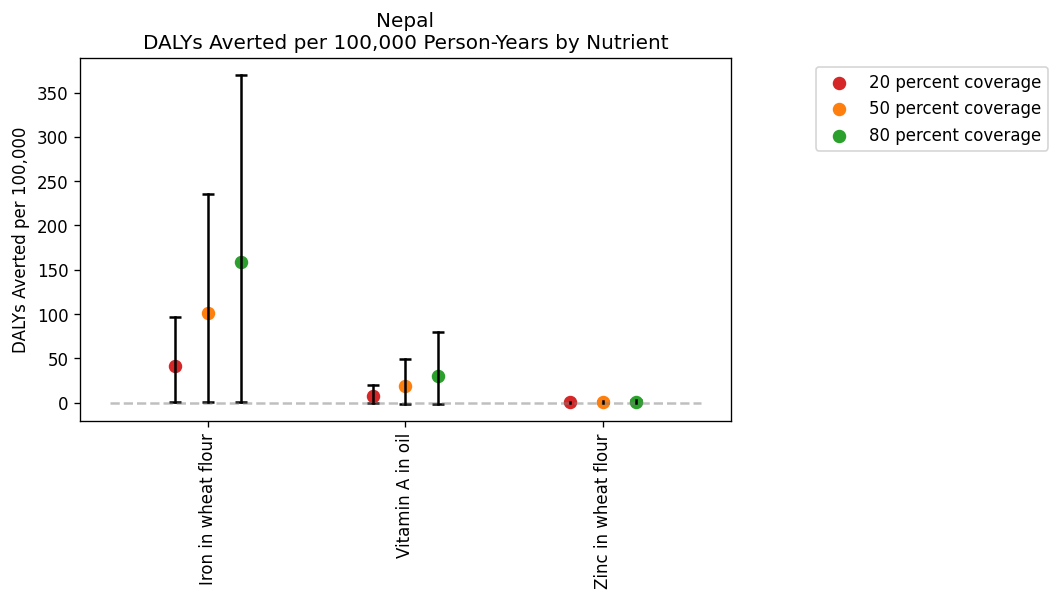

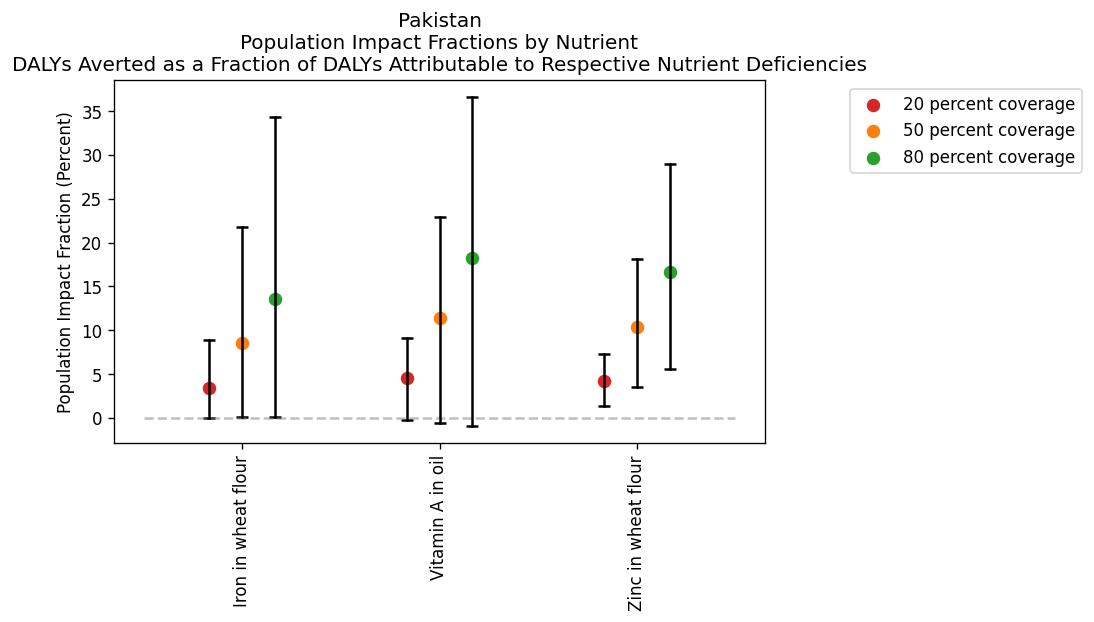

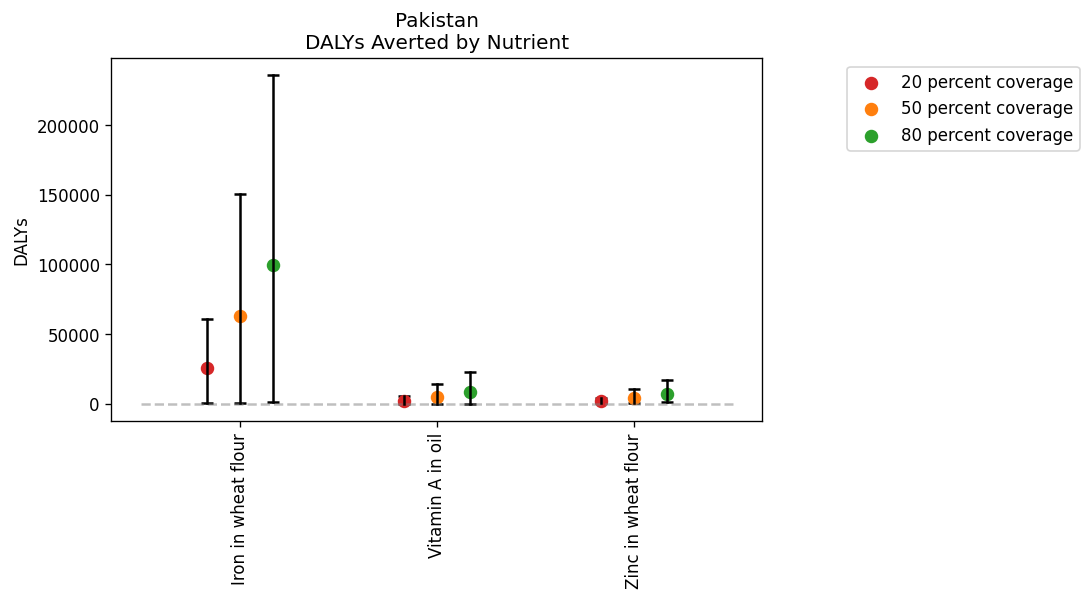

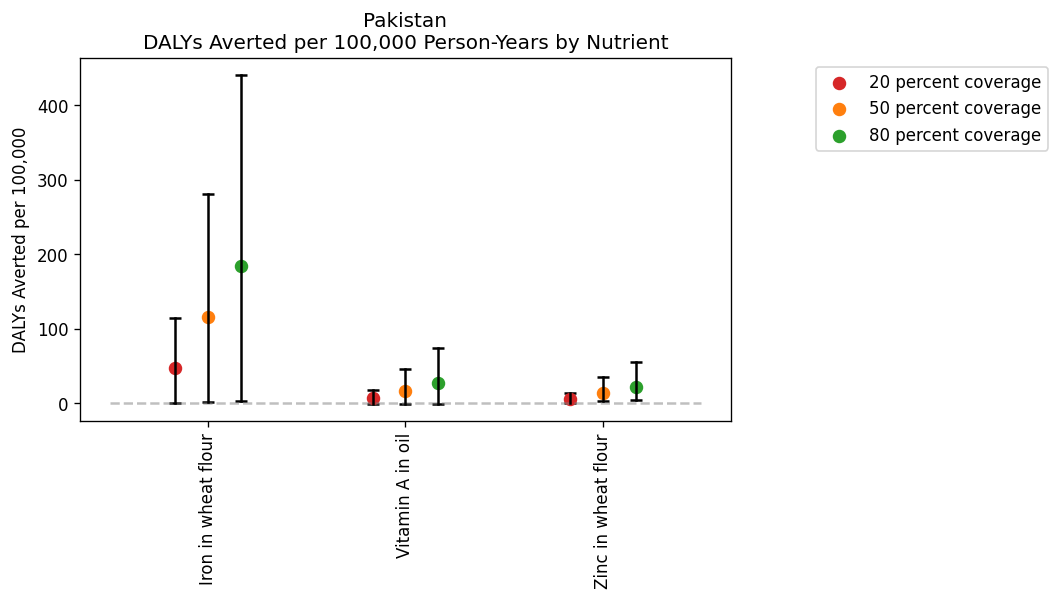

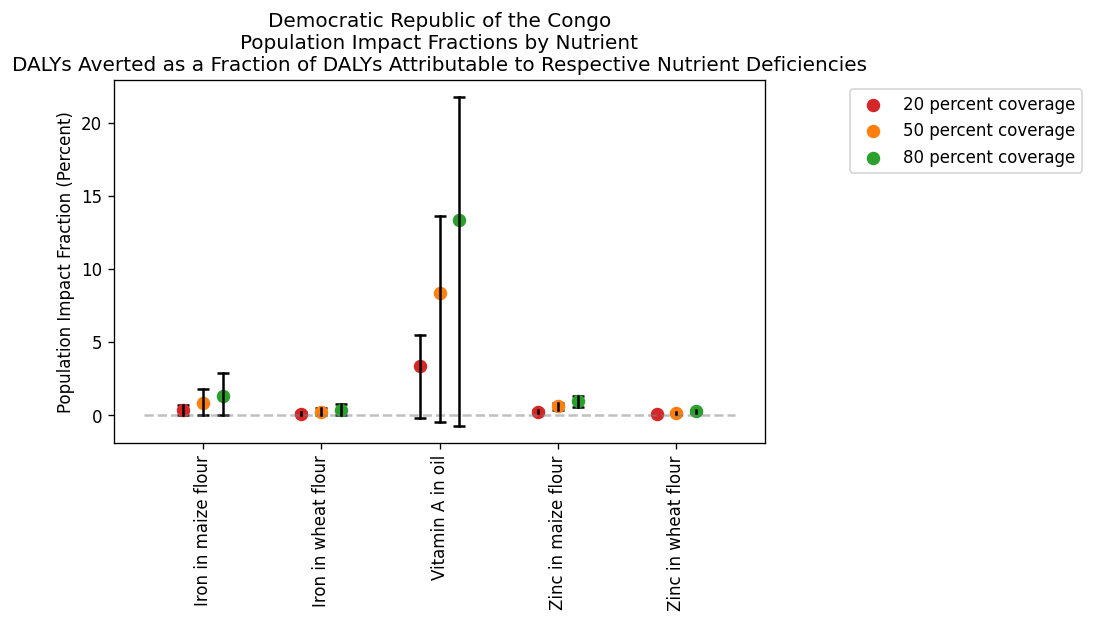

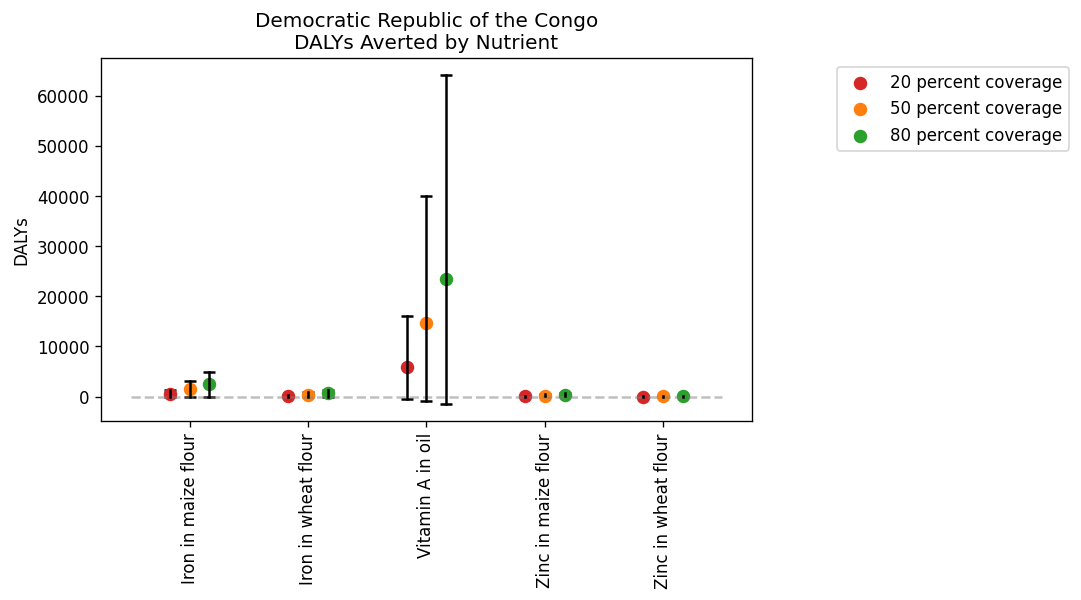

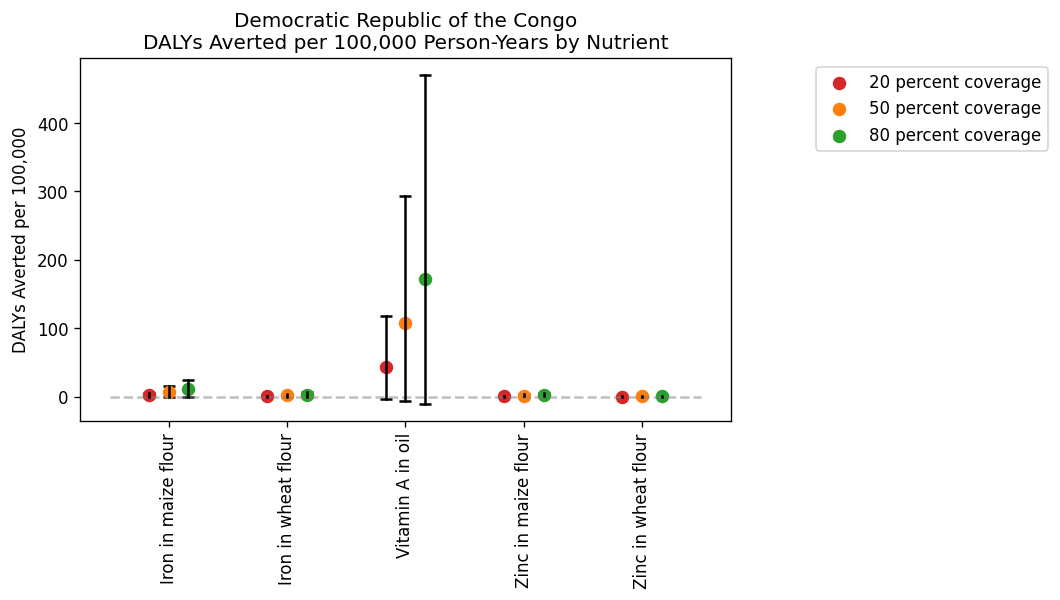

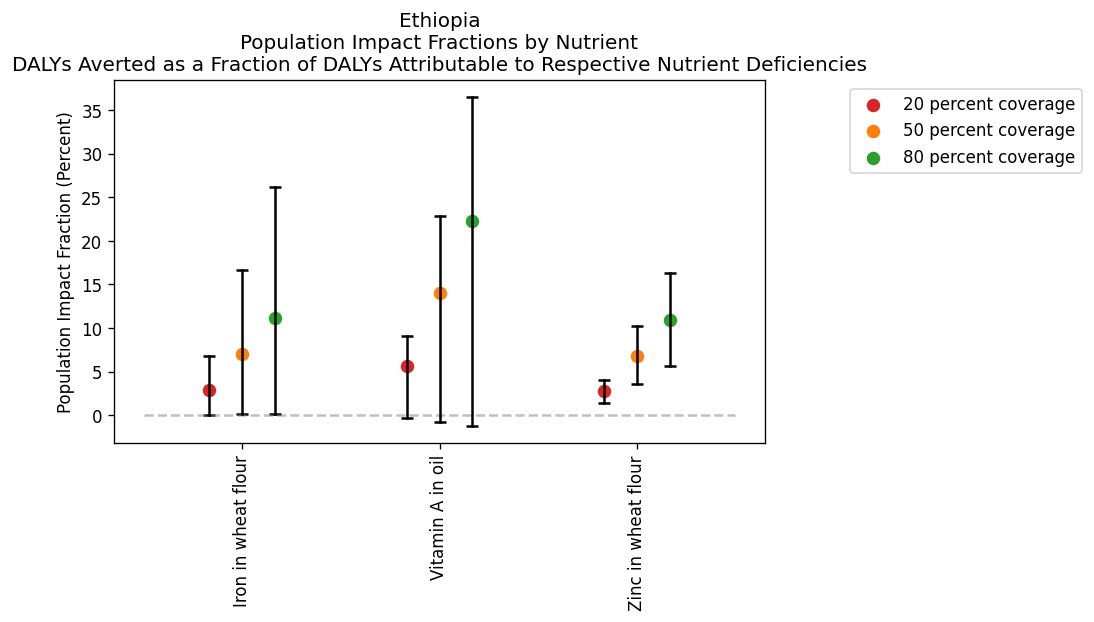

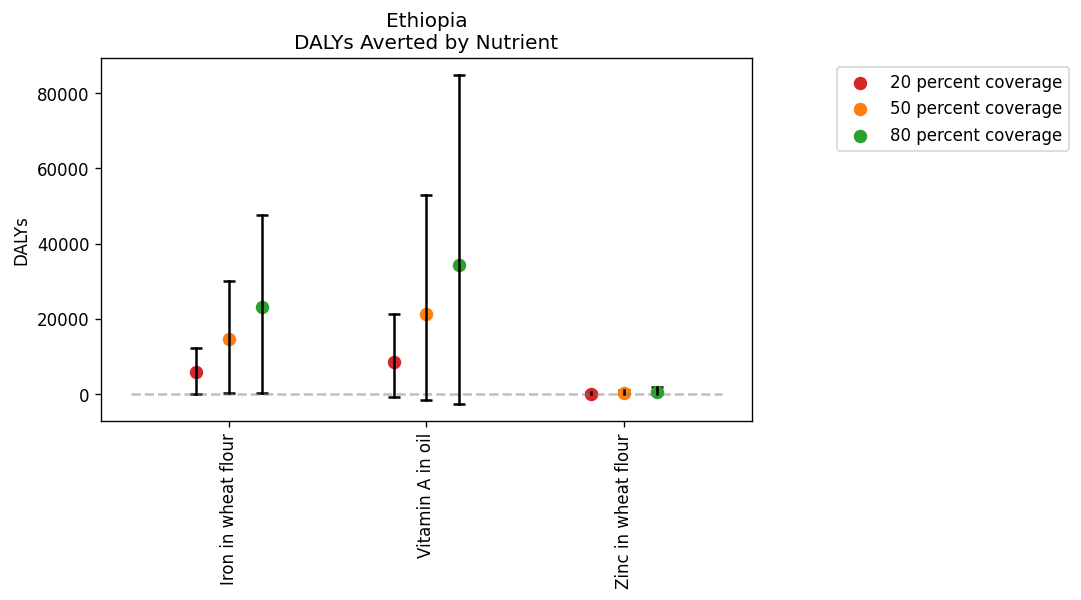

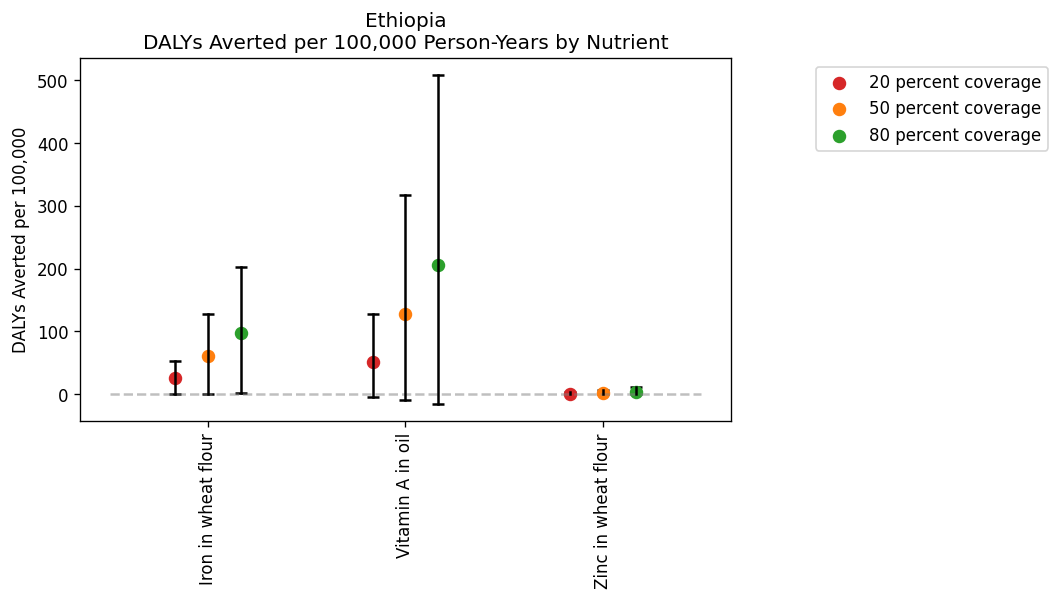

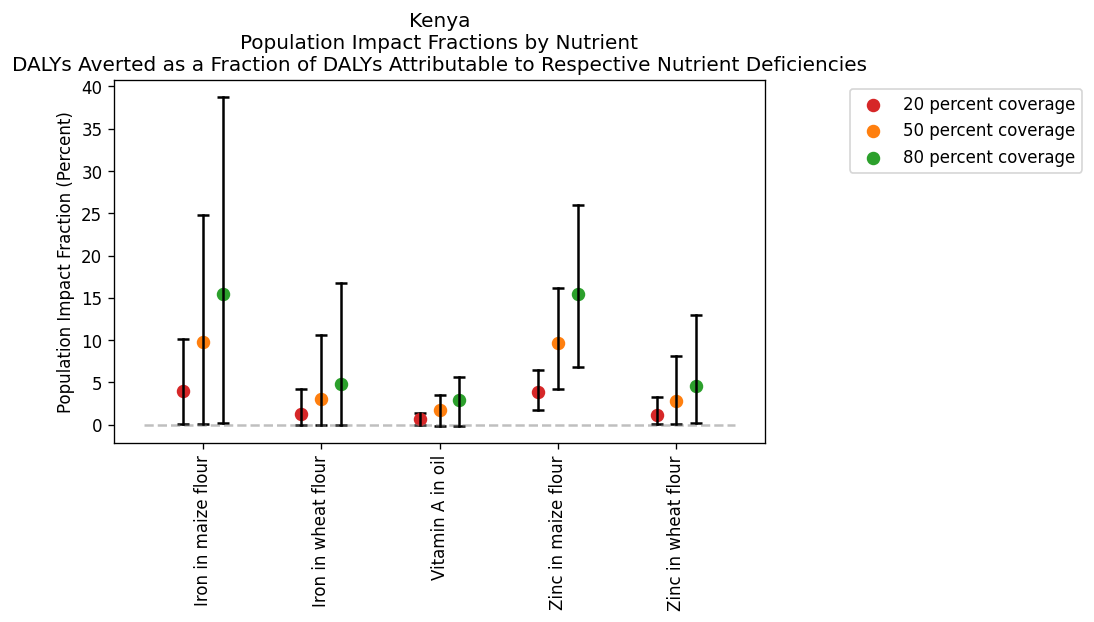

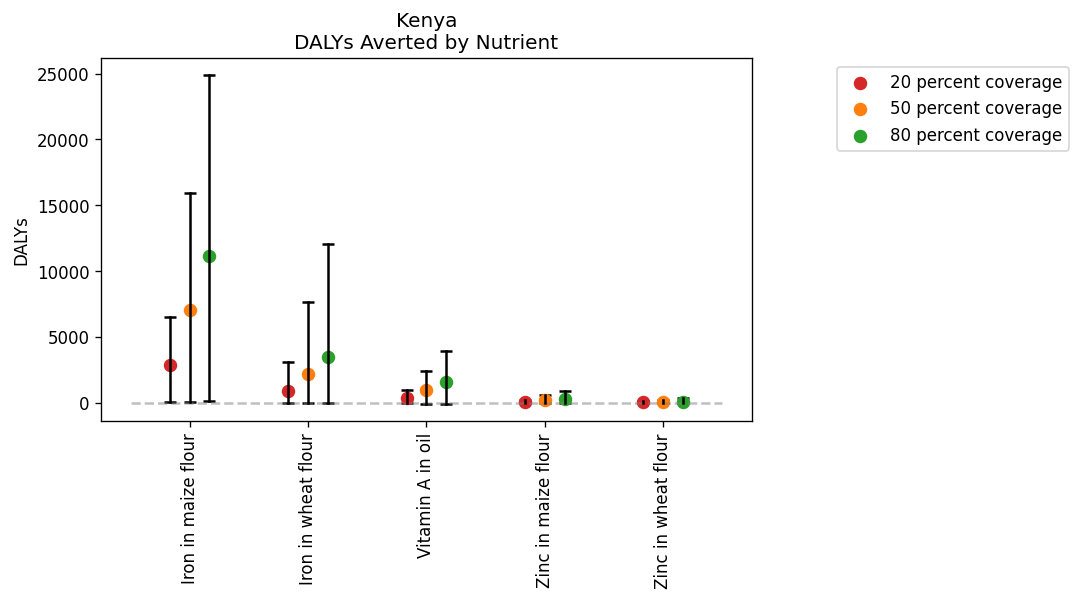

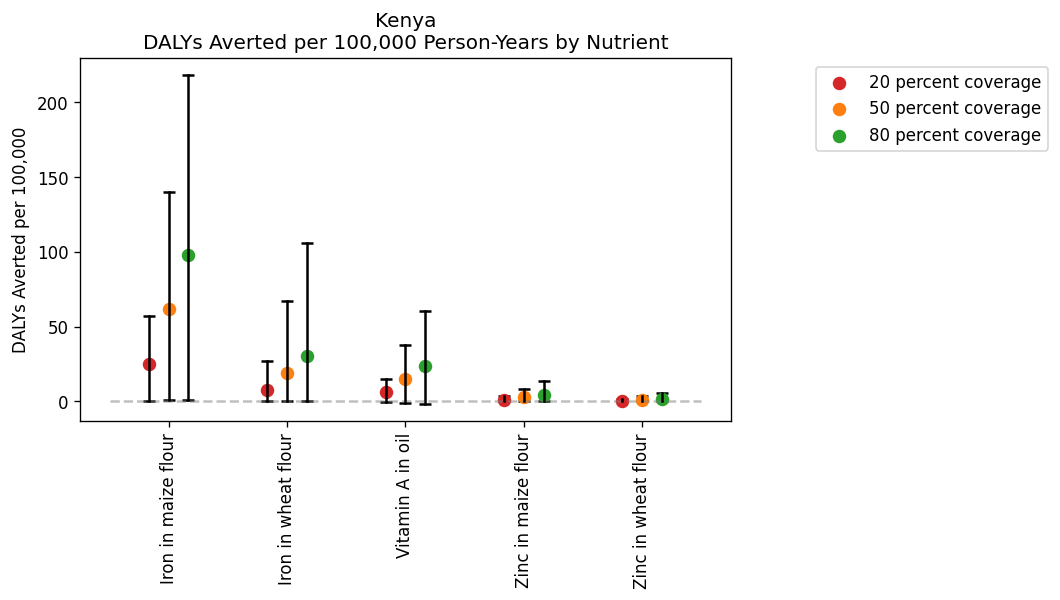

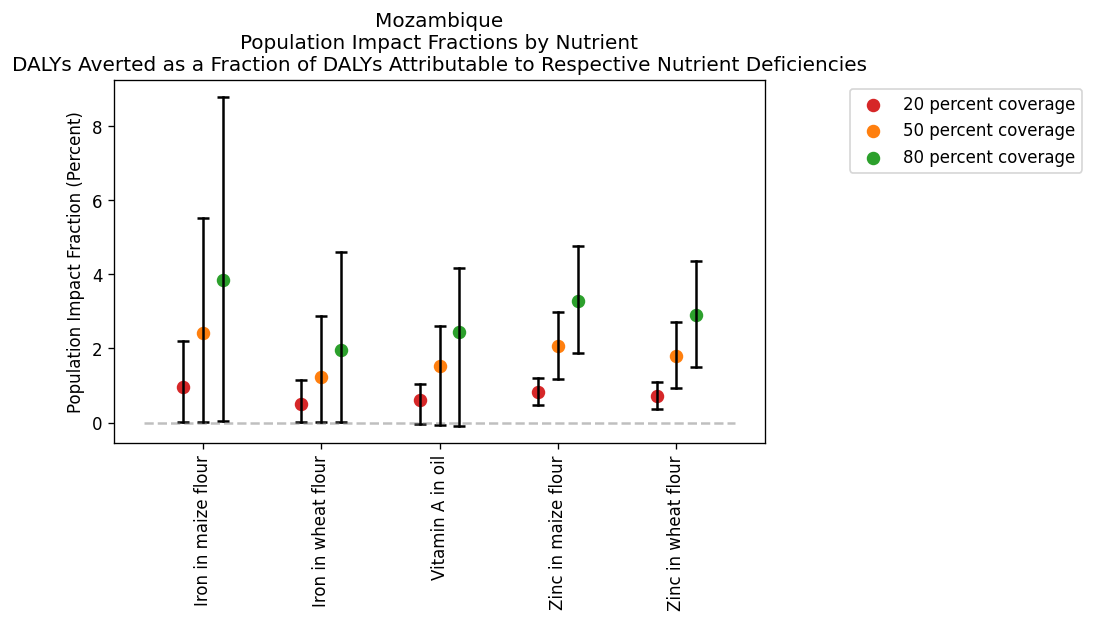

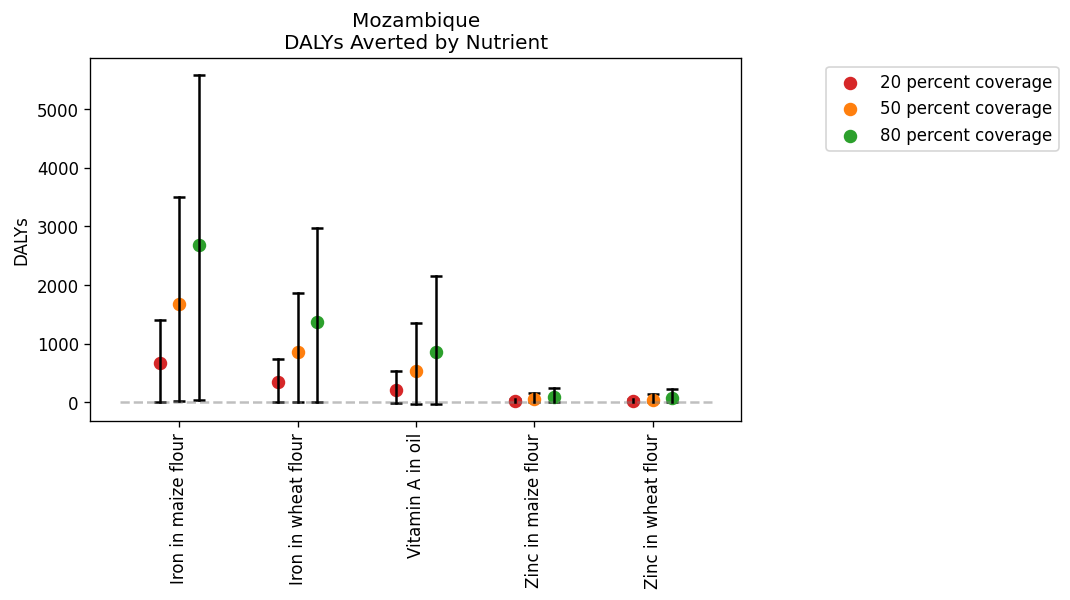

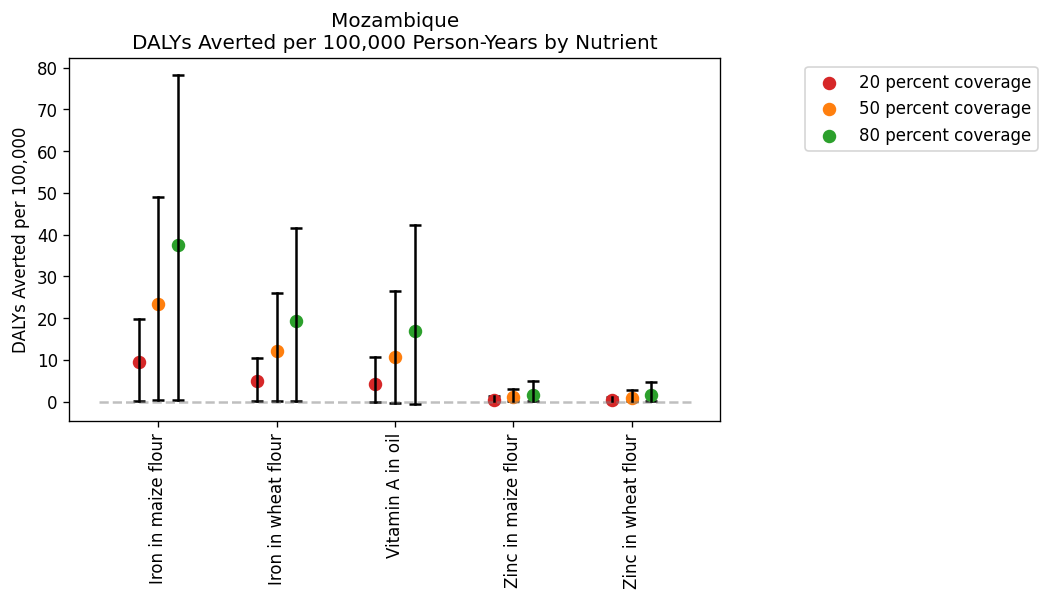

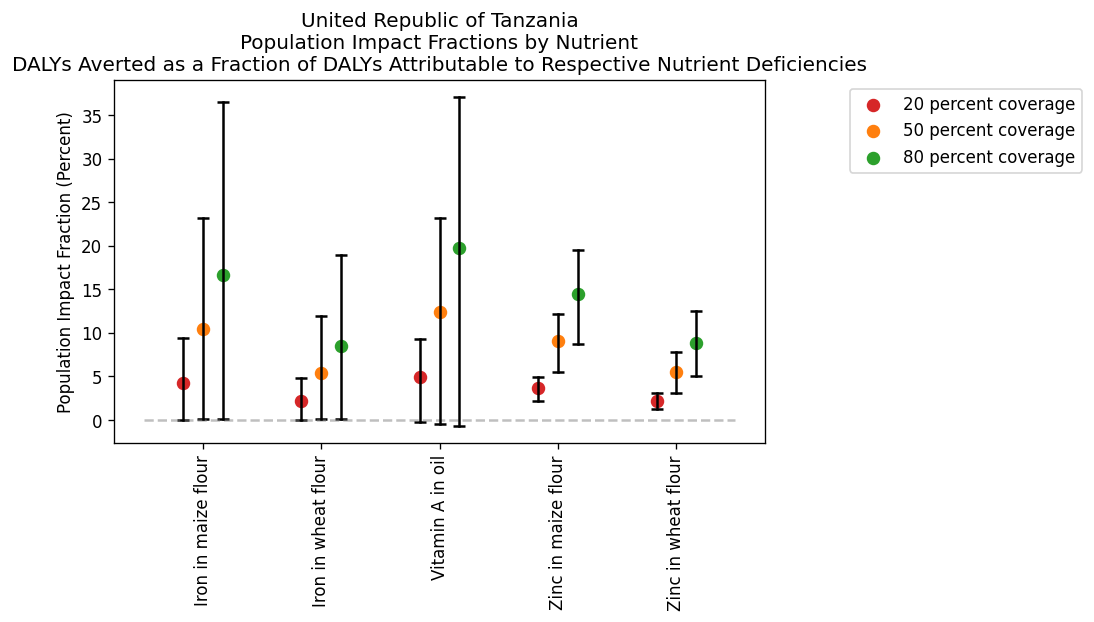

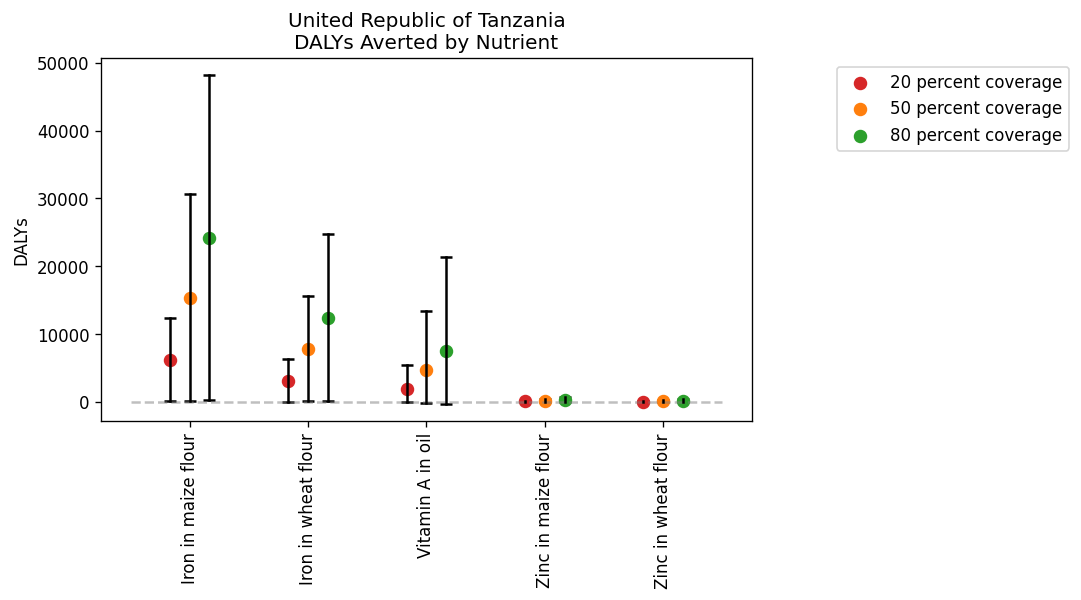

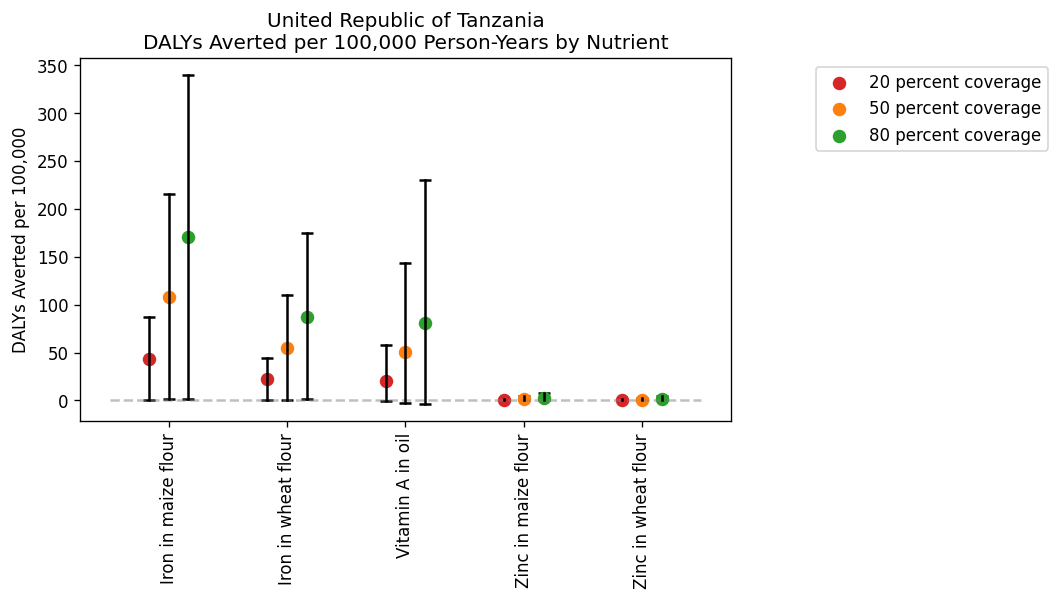

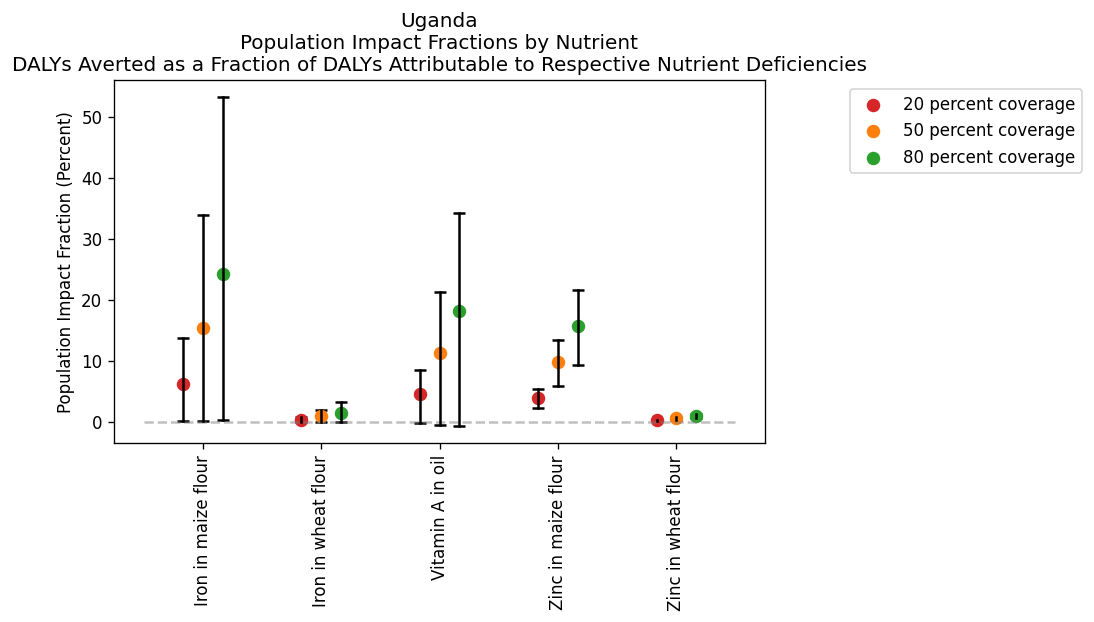

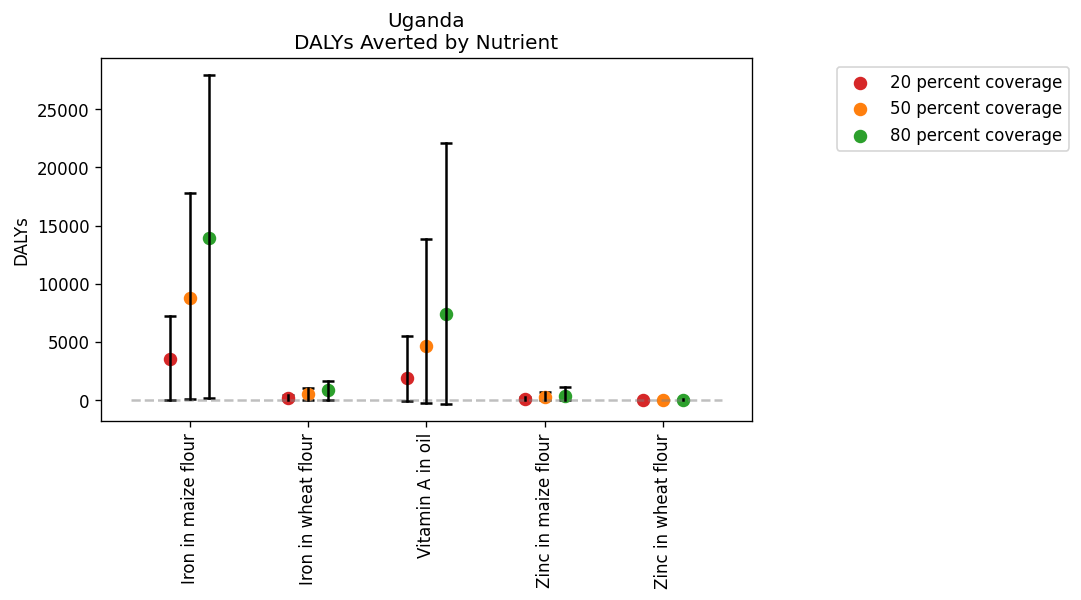

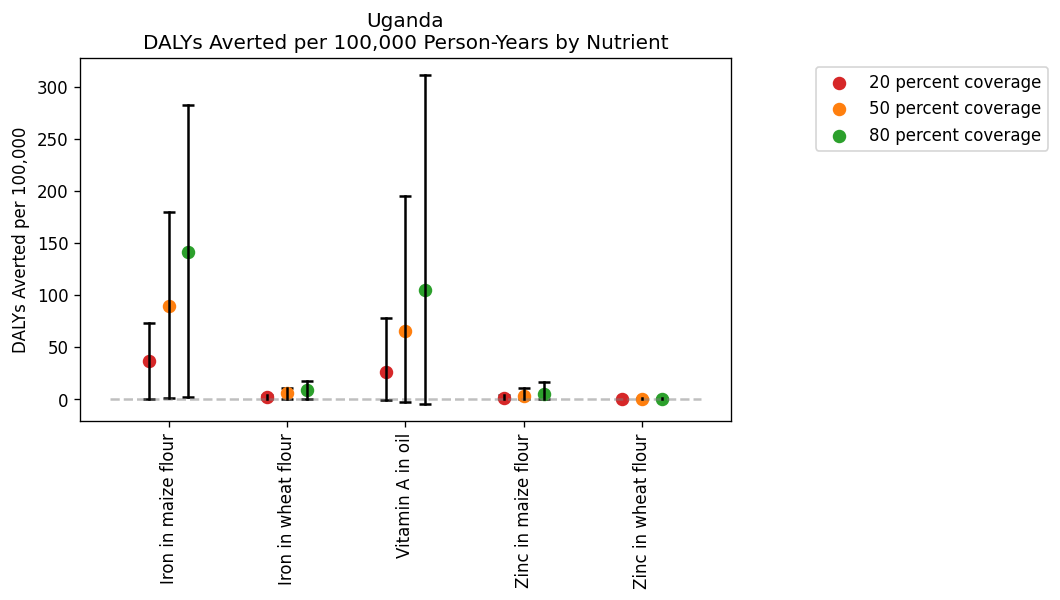

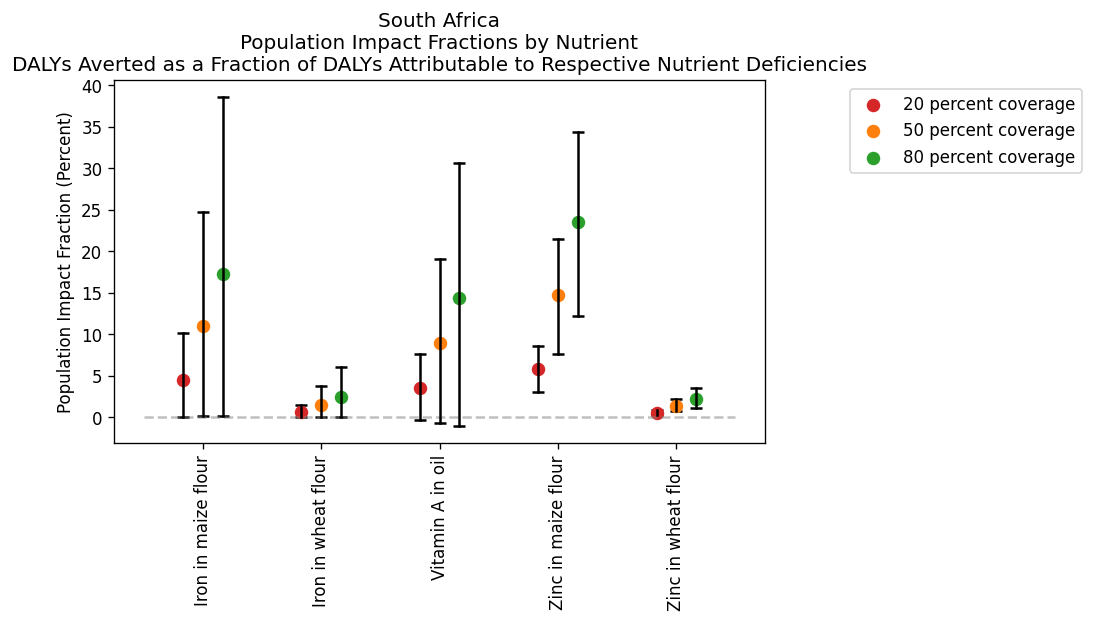

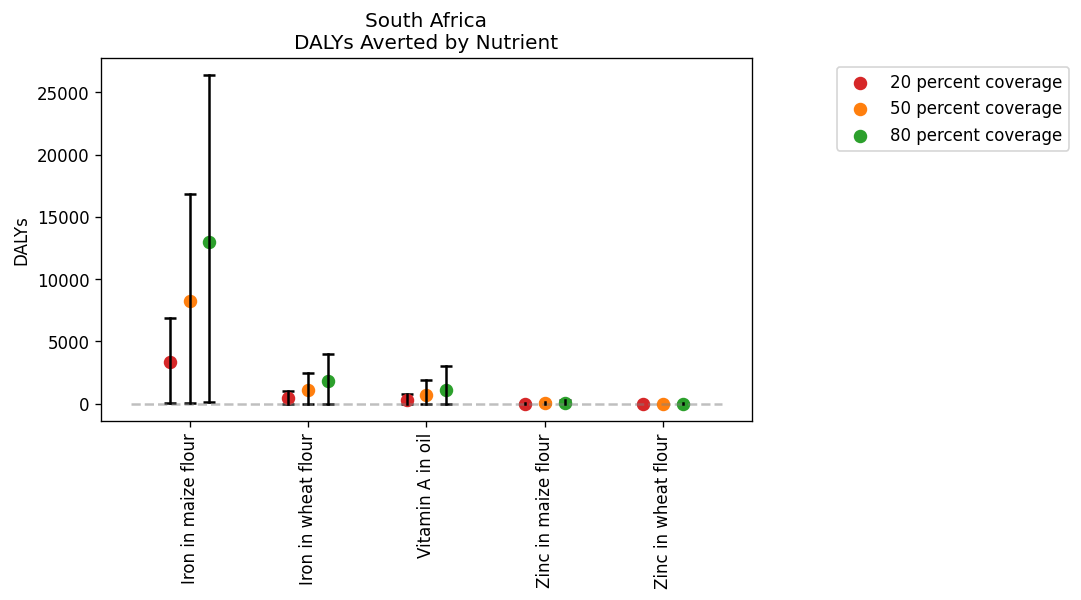

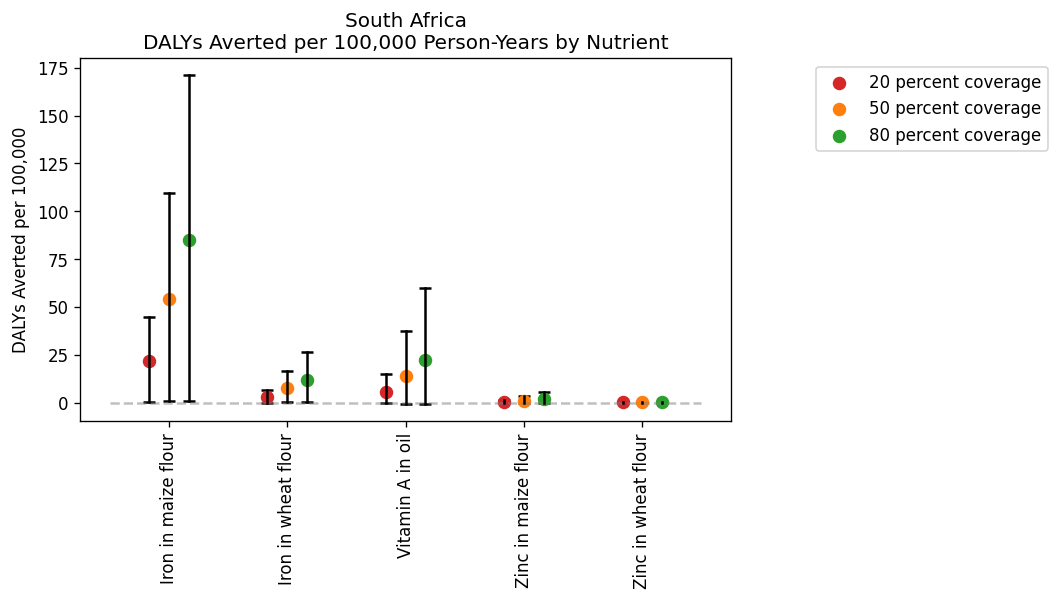

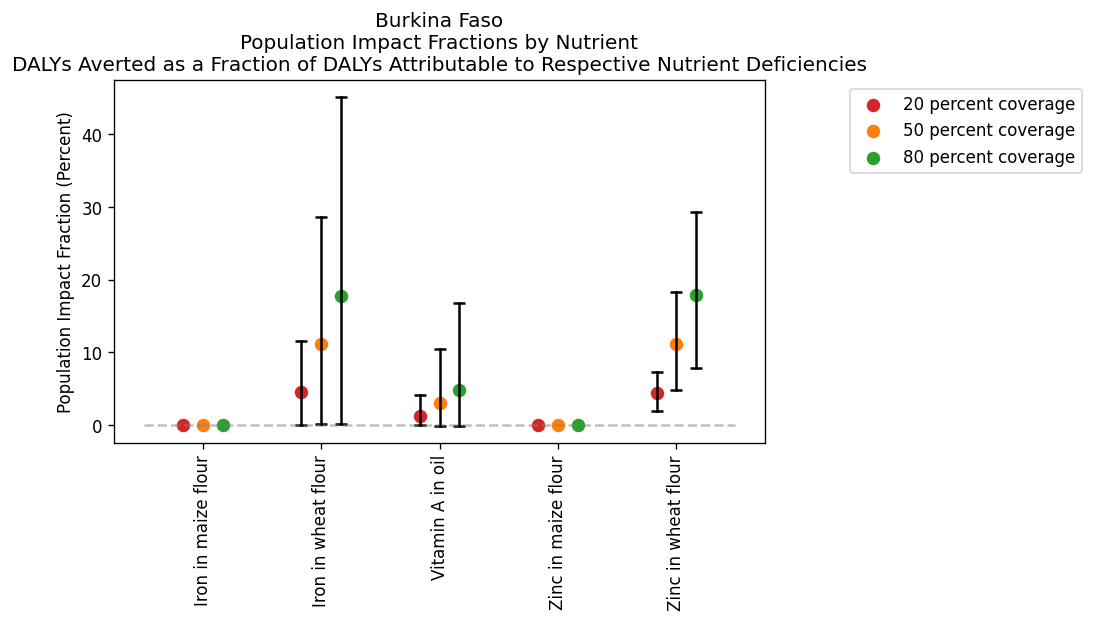

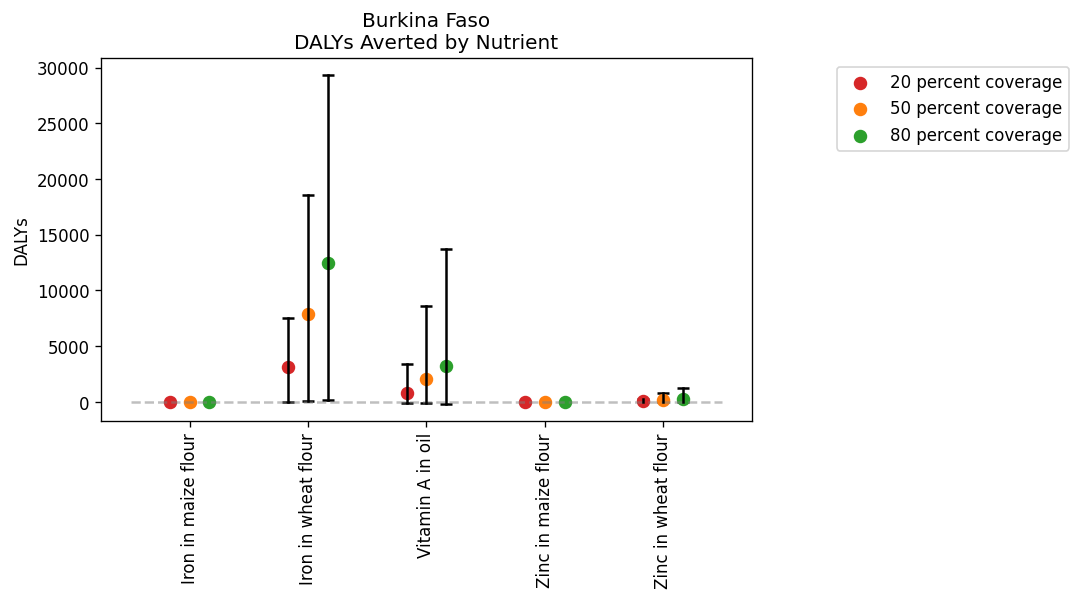

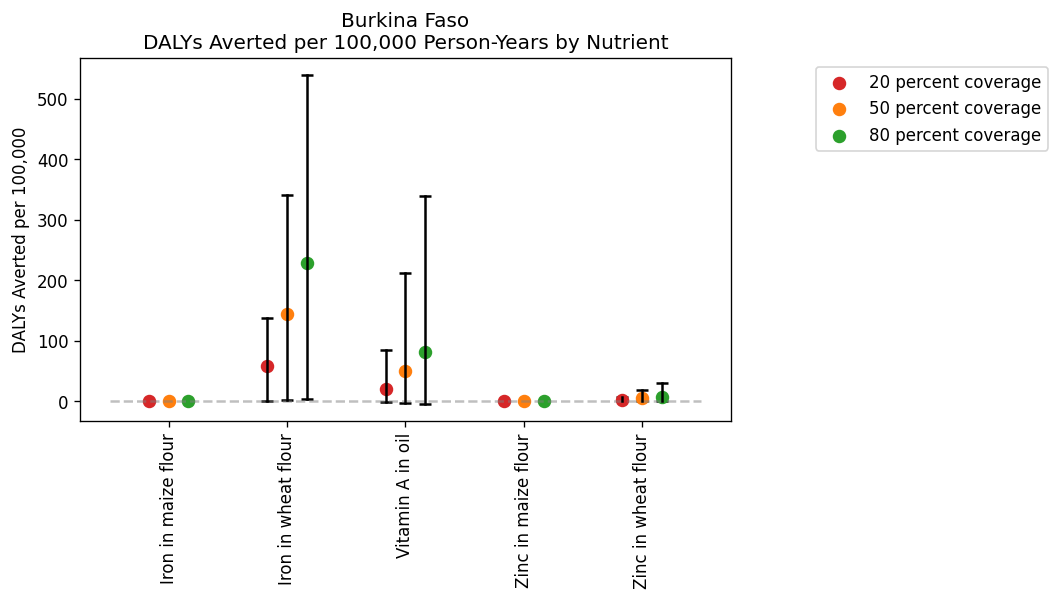

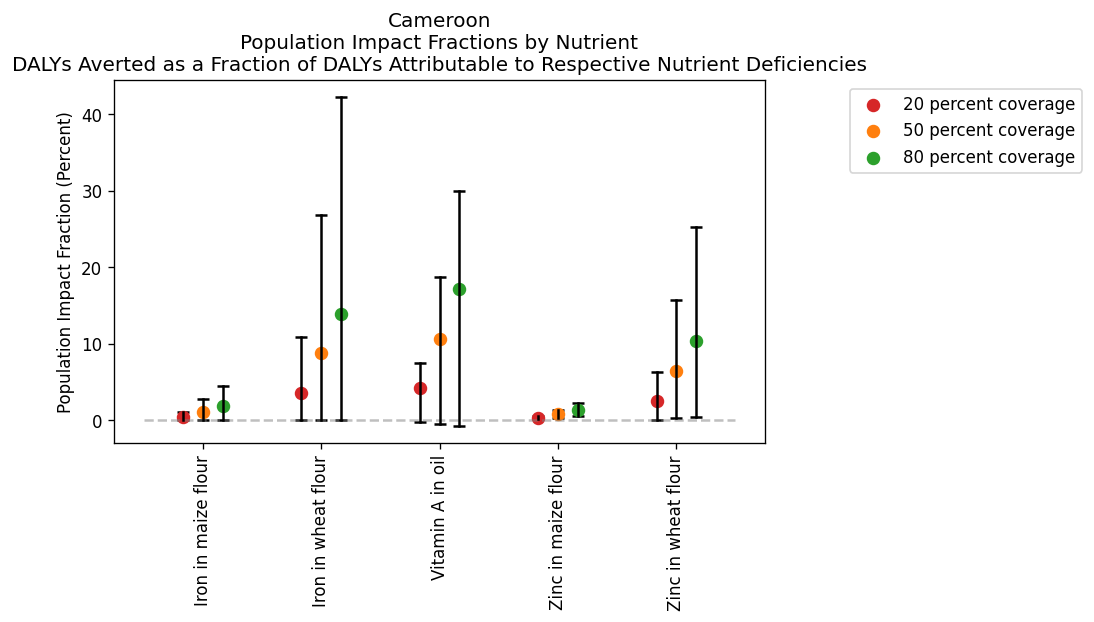

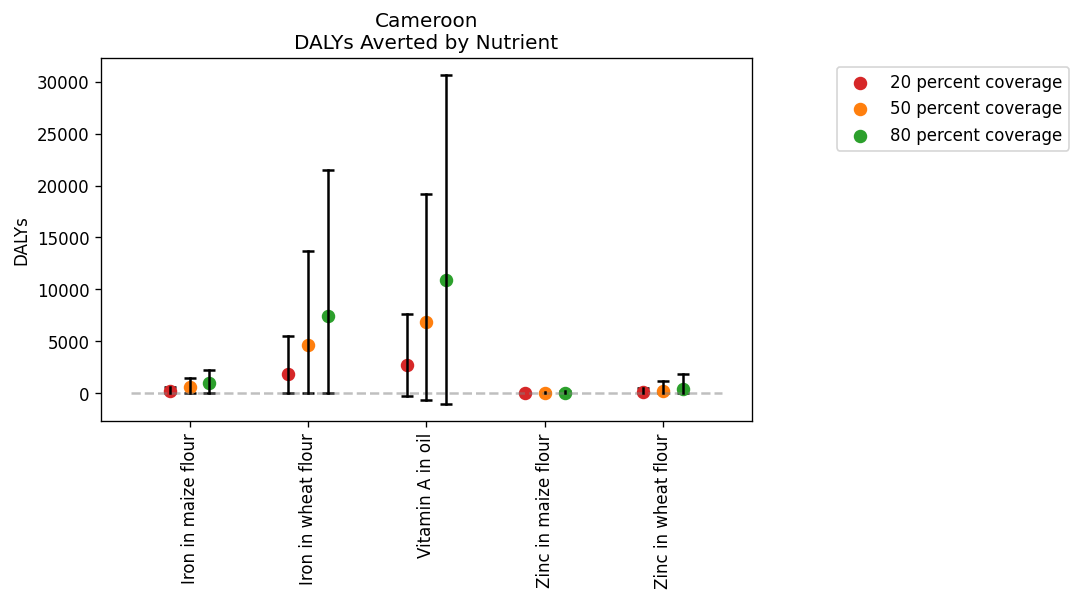

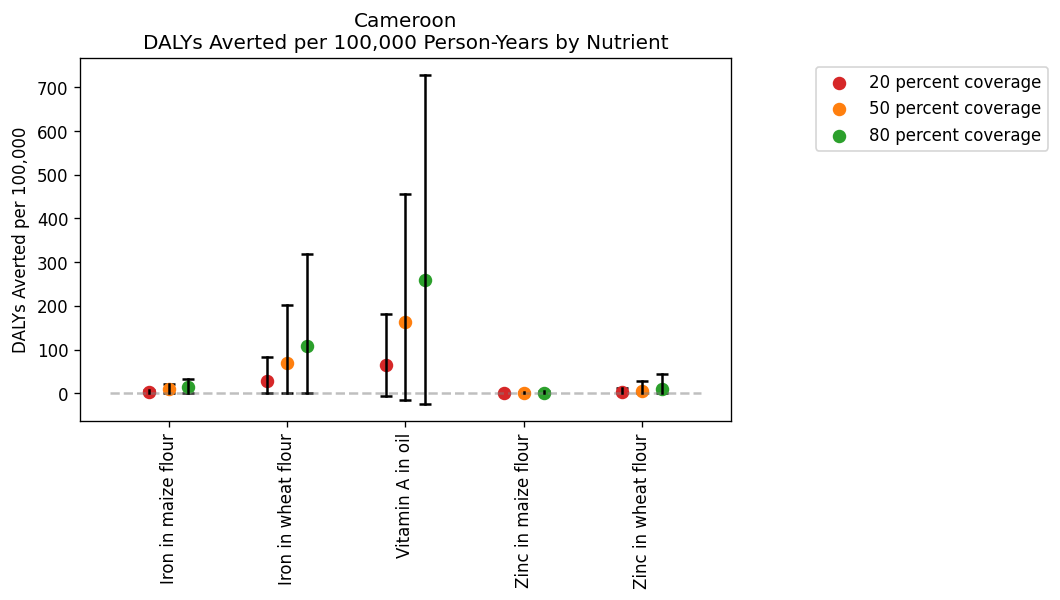

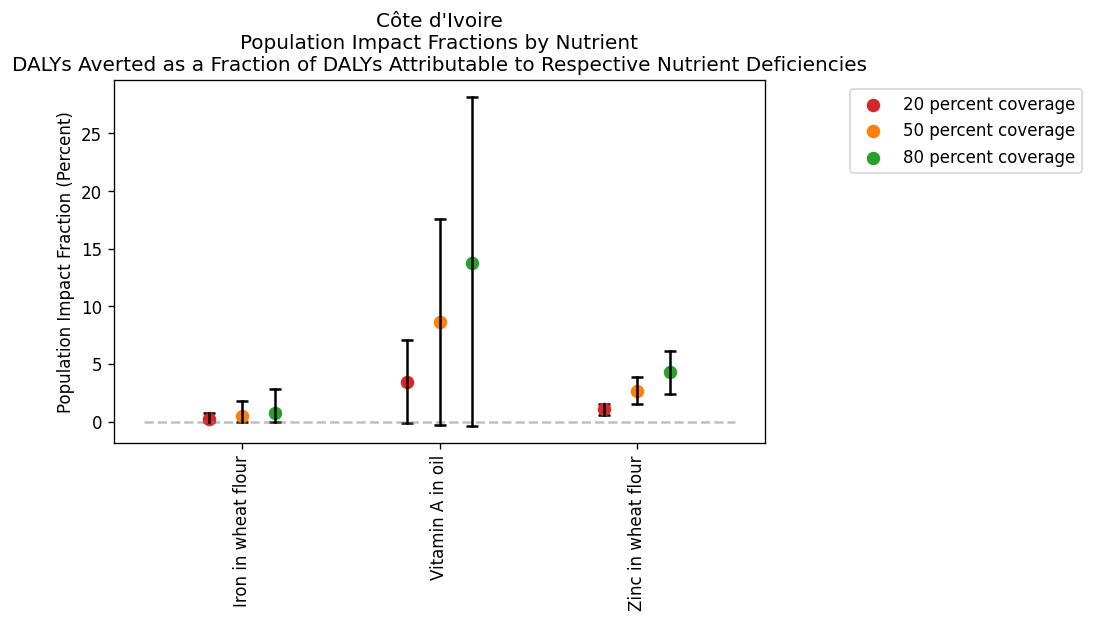

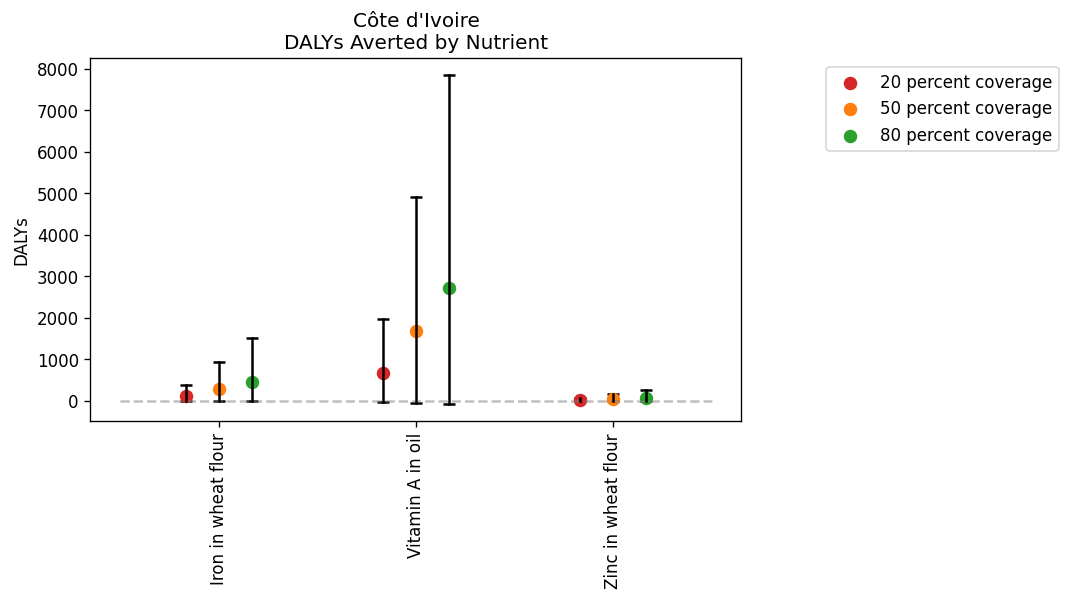

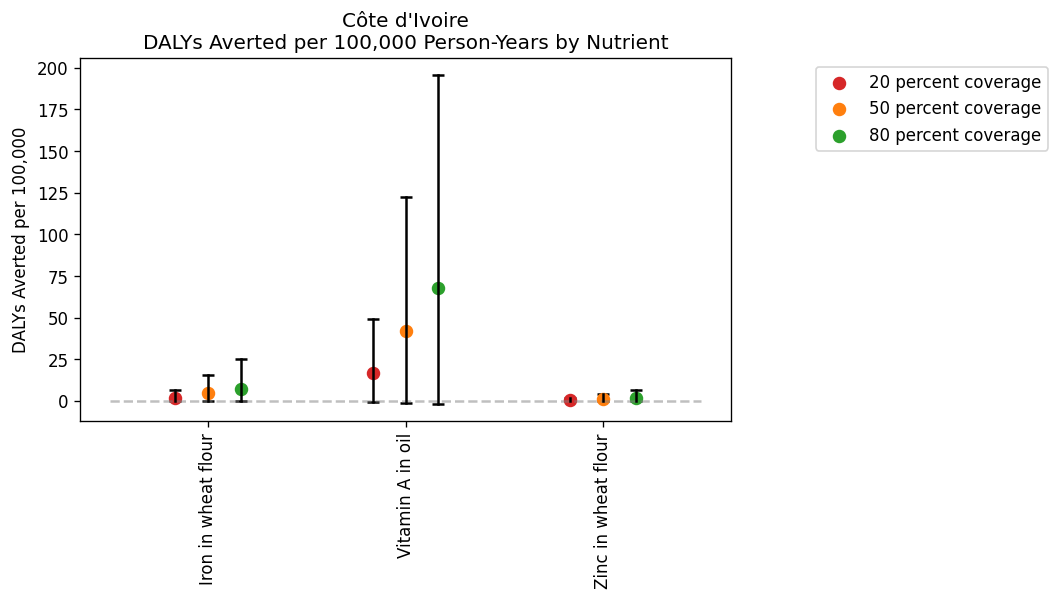

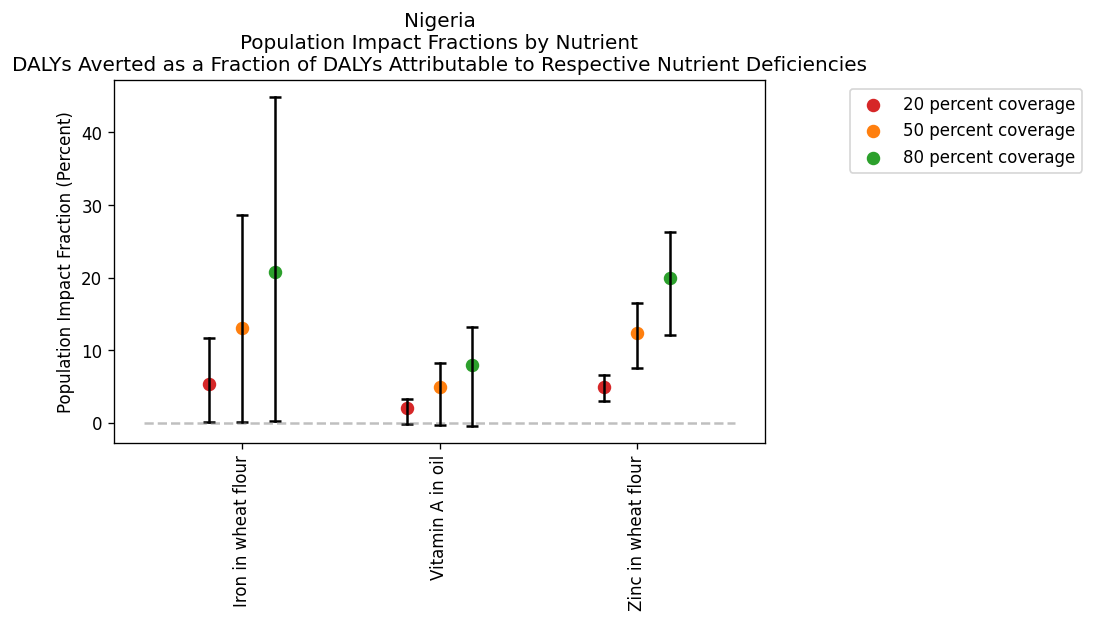

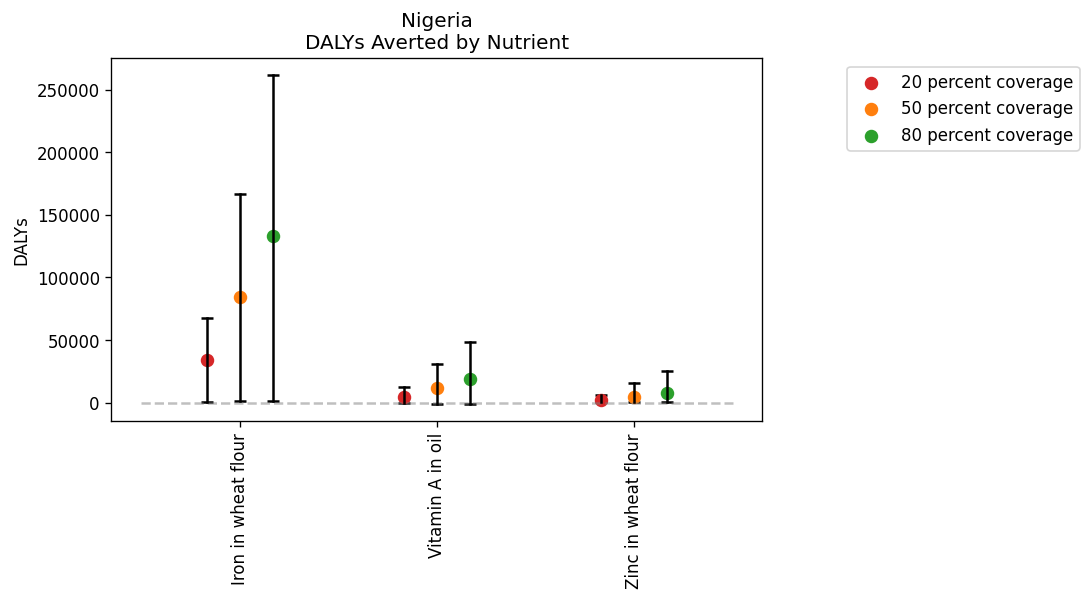

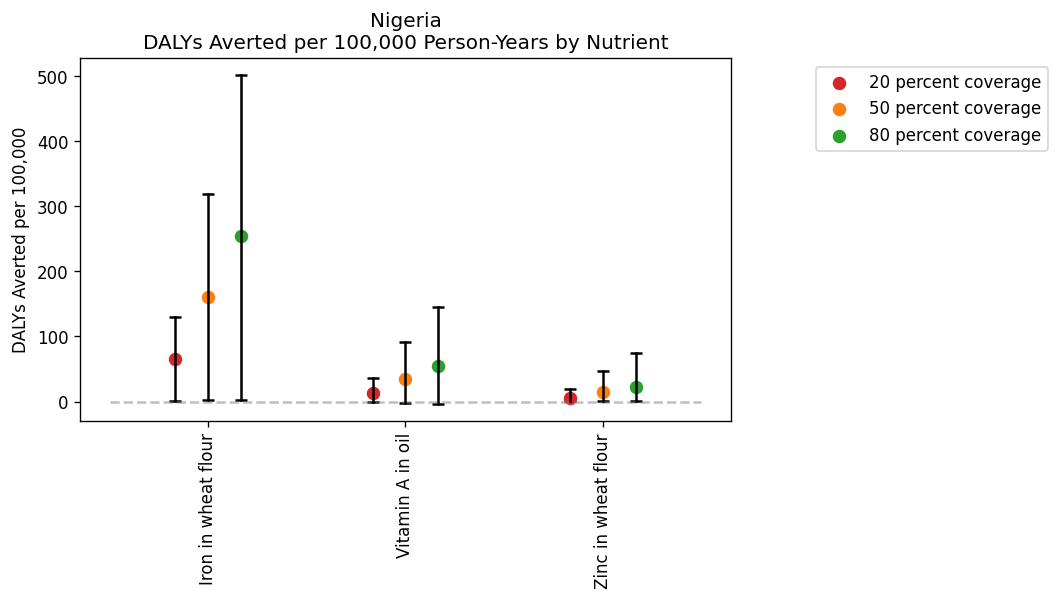

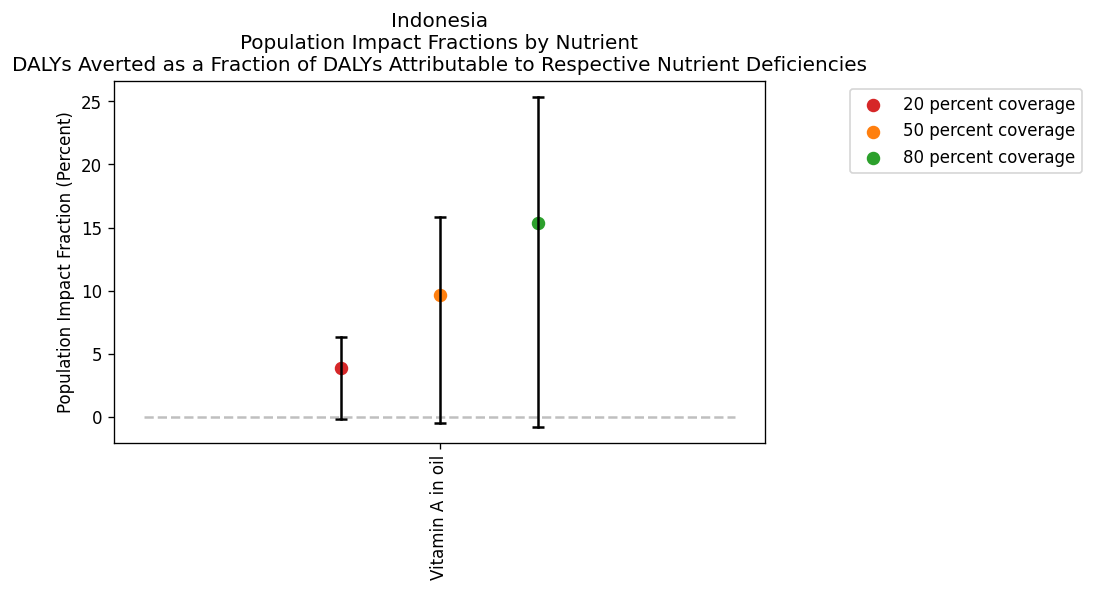

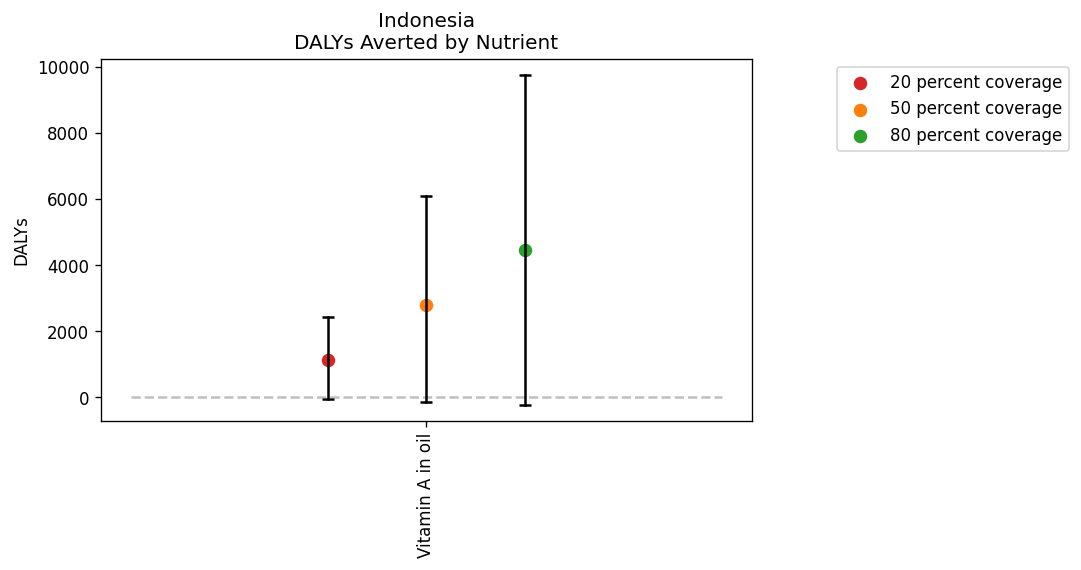

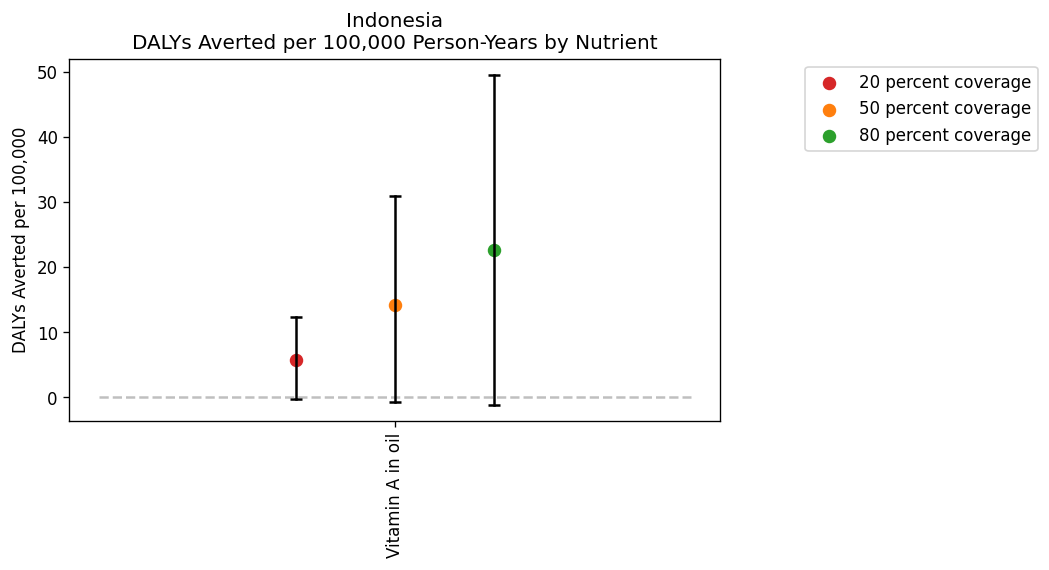

In [25]:
with PdfPages('results_plots/impact_by_location.pdf') as pdf:
    for location_id in results.location_id.unique():
        for measure in ['pif','counts_averted','rates_averted']:
            make_location_specific_plots(results, location_id, measure, coverage_levels)
            pdf.savefig(bbox_inches='tight')

In [124]:
results.measure.unique()

array(['pif', 'counts_averted', 'rates_averted', 'deficiency_exposure'],
      dtype=object)

In [125]:
model_results_for_table = results.drop(columns=['year','location_id'])
model_results_for_table = model_results_for_table.set_index([c for c in model_results_for_table.columns if 'draw' not in c])
model_results_for_table = (model_results_for_table.apply(pd.DataFrame.describe, percentiles=[0.025,0.975], axis=1)
                           .rename(columns={'2.5%':'lower','97.5%':'upper','mean':'mean_val'})
                           .filter(['mean_val','lower','upper'])
                           .reset_index())

for col in ['mean_val','lower','upper']:
    model_results_for_table[f'{col}'] = np.where(model_results_for_table.measure.isin(['pif','deficiency_exposure']),
                                           model_results_for_table[f'{col}'].map('{:.1f}'.format),
                                           model_results_for_table[f'{col}'].map('{:,.0f}'.format))

model_results_for_table['value'] = (model_results_for_table['mean_val'].astype(str)
                                            +'\r\n('
                                            +model_results_for_table['lower'].astype(str)
                                            +', '
                                            +model_results_for_table['upper'].astype(str)
                                            +')')

model_results_for_table['col_name'] = (model_results_for_table.label + 
                                       np.where(model_results_for_table.measure == 'pif', ' PIF (percent): ',
                                               np.where(model_results_for_table.measure == 'counts_averted', ' DALYs averted: ',
                                                       np.where(model_results_for_table.measure == 'rates_averted', ' DALYs averted per 100,000 person-years: ',
                                                              ' ' + model_results_for_table.nutrient + ' deficiency prevalence ')))
                                      + (model_results_for_table.coverage_level * 100).astype(str)
                                       + '% scale-up')

model_results_for_table = model_results_for_table[['col_name','location_name','value']]
model_results_for_table = model_results_for_table.pivot_table(index='location_name',
                                     columns='col_name', 
                                     values='value',
                                     aggfunc=lambda x: ' '.join(x))   
model_results_for_table = model_results_for_table.replace(np.nan, 'Not modeled')
model_results_for_table.head()

col_name                         Iron in maize flour DALYs averted per 100,000 person-years: 20.0% scale-up  \
location_name                                                                                                 
Bangladesh                                                              Not modeled                           
Burkina Faso                                                            0\r\n(0, 0)                           
Cameroon                                                                4\r\n(0, 9)                           
Côte d'Ivoire                                                           Not modeled                           
Democratic Republic of the Congo                                        3\r\n(0, 6)                           

col_name                         Iron in maize flour DALYs averted per 100,000 person-years: 50.0% scale-up  \
location_name                                                                                                 
Bangladesh                                                              Not modeled                           
Burkina Faso                                                            0\r\n(0, 0)                           
Cameroon                                                               9\r\n(0, 21)                           
Côte d'Ivoire                                                           Not modeled                           
Democratic Republic of the Congo                                       7\r\n(0, 15)                           

col_name                         Iron in maize flour DALYs averted per 100,000 person-years: 80.0% scale-up  \
location_name                                                                                                 
Bangladesh                                                              Not modeled                           
Burkina Faso                                                            0\r\n(0, 0)                           
Cameroon                                                              14\r\n(0, 34)                           
Côte d'Ivoire                                                           Not modeled                           
Democratic Republic of the Congo                                      12\r\n(0, 24)                           

col_name                         Iron in maize flour DALYs averted: 20.0% scale-up  \
location_name                                                                        
Bangladesh                                                             Not modeled   
Burkina Faso                                                           0\r\n(0, 0)   
Cameroon                                                           243\r\n(2, 576)   
Côte d'Ivoire                                                          Not modeled   
Democratic Republic of the Congo                                 611\r\n(6, 1,253)   

col_name                         Iron in maize flour DALYs averted: 50.0% scale-up  \
location_name                                                                        
Bangladesh                                                             Not modeled   
Burkina Faso                                                           0\r\n(0, 0)   
Cameroon                                                         606\r\n(6, 1,436)   
Côte d'Ivoire                                                          Not modeled   
Democratic Republic of the Congo                              1,526\r\n(14, 3,129)   

col_name                         Iron in maize flour DALYs averted: 80.0% scale-up  \
location_name                                                                        
Bangladesh                                                             Not modeled   
Burkina Faso                                                           0\r\n(0, 0)   
Cameroon                                                        968\r\n(10, 2,294)   
Côte d'Ivoire                 

# Baseline burden

In [27]:
gbd_data_dir = '/ihme/homes/alibow/notebooks/vivarium_research_lsff/gbd_data_summary/output_data/'

In [28]:
zinc_gbd = pd.read_csv(gbd_data_dir + 'zinc_data_formatted.csv')
vitamin_a_gbd = pd.read_csv(gbd_data_dir + 'vitamin_a_data_formatted.csv')
neural_tube_defects_gbd = pd.read_csv(gbd_data_dir + 'neural_tube_defects_data_formatted.csv')

iron_gbd = pd.read_csv(gbd_data_dir + 'iron_data_formatted.csv').set_index(['location_name','location_id'])
iron_gbd_wra = iron_gbd.loc[iron_gbd.population=='WRA'].drop(columns='population')
for col in iron_gbd_wra.columns:
    iron_gbd_wra = iron_gbd_wra.rename(columns={f'{col}':f'Baseline {col} among WRA'})
iron_gbd_u5 = iron_gbd.loc[iron_gbd.population=='Children U5'].drop(columns='population')
for col in iron_gbd_u5.columns:
    iron_gbd_u5 = iron_gbd_u5.rename(columns={f'{col}':f'Baseline {col} among Children U5'})
iron_gbd = iron_gbd_wra.reset_index().merge(iron_gbd_u5.reset_index(), on=['location_name','location_id'])

gbd_data = (zinc_gbd.merge(vitamin_a_gbd, on=['location_id','location_name'])
            .merge(neural_tube_defects_gbd, on=['location_id','location_name'])
            .set_index(['location_id','location_name']))
for col in gbd_data.columns:
    gbd_data = gbd_data.rename(columns={f'{col}':f'Baseline {col}'})
gbd_data = gbd_data.reset_index().merge(iron_gbd, on=['location_id','location_name'])

gbd_data.head()

location_id location_name  \
0          168        Angola   
1          161    Bangladesh   
2          201  Burkina Faso   
3          202      Cameroon   
4            6         China   

  Baseline Prevalence of Zinc deficiency in age group 1 to 4 (per 100)  \
0                                14.1\r\n(2.5, 28.7)                     
1                                 9.7\r\n(1.1, 23.1)                     
2                                  3.1\r\n(0.0, 9.8)                     
3                                 4.8\r\n(0.0, 13.8)                     
4                                  1.1\r\n(0.0, 3.4)                     

  Baseline Number in age group 1 to 4 with Zinc deficiency (1000s)  \
0                                577\r\n(103, 1,173)                 
1                              1,077\r\n(120, 2,568)                 
2                                     98\r\n(0, 310)                 
3                                    159\r\n(0, 460)                 
4                                  758\r\n(0, 2,247)                 

  Baseline DALYs attributable to Zinc deficiency in age group 1 to 4  \
0                             5,150\r\n(768, 13,767)                   
1                                 957\r\n(90, 2,850)                   
2                                1,694\r\n(0, 6,200)                   
3                               3,796\r\n(0, 13,324)                   
4                                    222\r\n(0, 743)                   

  Baseline DALYs attributable to Zinc deficiency per 100,000 person-years in age group 1 to 4  \
0                                   126\r\n(19, 337)                                            
1                                       9\r\n(1, 26)                                            
2                                     54\r\n(0, 196)                                            
3                                    114\r\n(0, 399)                                            
4                                        0\r\n(0, 1)                                            

  Baseline Prevalence of Vitamin A deficiency in age group Under 5 (per 100)  \
0                               26.4\r\n(18.4, 36.9)                           
1                                 8.4\r\n(5.3, 12.8)                           
2                               35.4\r\n(26.0, 45.7)                           
3                               27.9\r\n(19.0, 38.5)                           
4                                  3.9\r\n(2.4, 6.1)                           

  Baseline Number in age group Under 5 with Vitamin A deficiency (1000s)  \
0                              1,358\r\n(947, 1,899)                       
1                              1,156\r\n(727, 1,765)                       
2                            1,433\r\n(1,053, 1,848)                       
3                              1,174\r\n(798, 1,619)                       
4                            3,141\r\n(1,924, 4,995)                       

  Baseline DALYs attributable to Vitamin A deficiency in age group Under 5 (1000s)  \
0                                35.8\r\n(9.0, 68.7)                                 
1                                 8.2\r\n(4.5, 13.3)                                 
2                              67.6\r\n(17.2, 144.7)                                 
3                              63.6\r\n(11.7, 137.4)                                 
4                                12.5\r\n(7.5, 18.8)                                 

  Baseline DALYs attributable to Vitamin A deficiency per 100,000 person-years in age group Under 5  \
0                                695\r\n(174, 1,335)                                                  
1                                     59\r\n(32, 97)                                                  
2                              1,671\r\n(424, 3,576)                                                  
3                              1,511\r\n(279, 3,265)         

# Coverage

In [29]:
coverage = pd.read_pickle('results_raw/coverage.pkl')

coverage['value'] = ((coverage['mean'] * 100).round(1).astype(str)
                        +'\r\n('
                        +(coverage['2.5%'] * 100).round(1).astype(str)
                        +', '
                        +(coverage['97.5%'] * 100).round(1).astype(str)
                        +')')

coverage['parameter_description'] = np.where(coverage.coverage_level == 'baseline', 'Percent of population eating ' + coverage.nutrient + ' fortified ' + coverage.vehicle +' at baseline',
                                            np.where(coverage.coverage_level == 'maximum', f'Percent of population eating fortifiable ' + coverage.vehicle, 
                                            'Percent of population eating ' + coverage.nutrient + ' fortified ' + coverage.vehicle + ': ' + (coverage.coverage_level * 100).astype(str) + '0% scale-up'))

coverage['parameter_description'] = coverage['parameter_description'].str.replace('.00%','%')
coverage = coverage[['location_id','value','parameter_description']]
coverage = coverage.pivot_table(index='location_id',
                                     columns='parameter_description', 
                                     values='value',
                                     aggfunc=lambda x: ' '.join(x))   
coverage = coverage.replace(np.nan, 'Not modeled').reset_index()

coverage.head()

parameter_description  location_id  \
0                               11   
1                               15   
2                               20   
3                              161   
4                              163   

parameter_description Percent of population eating folic acid fortified maize flour at baseline  \
0                                                            Not modeled                          
1                                                            Not modeled                          
2                                                            Not modeled                          
3                                                            Not modeled                          
4                                                            Not modeled                          

parameter_description Percent of population eating folic acid fortified maize flour: 20% scale-up  \
0                                                            Not modeled                            
1                                                            Not modeled                            
2                                                            Not modeled                            
3                                                            Not modeled                            
4                                                            Not modeled                            

parameter_description Percent of population eating folic acid fortified maize flour: 50% scale-up  \
0                                                            Not modeled                            
1                                                            Not modeled                            
2                                                            Not modeled                            
3                                                            Not modeled                            
4                                                            Not modeled                            

parameter_description Percent of population eating folic acid fortified maize flour: 80% scale-up  \
0                                                            Not modeled                            
1                                                            Not modeled                            
2                                                            Not modeled                            
3                                                            Not modeled                            
4                                                            Not modeled                            

parameter_description Percent of population eating folic acid fortified wheat flour at baseline  \
0                                                            Not modeled                          
1                                                      1.0\r\n(0.1, 2.7)                          
2                                                      4.1\r\n(1.9, 6.4)                          
3                                                      0.2\r\n(0.1, 0.2)                          
4                                                      6.3\r\n(4.8, 7.7)                          

parameter_description Percent of population eating folic acid fortified wheat flour: 20% scale-up  \
0                                                            Not modeled                            
1                                                      1.7\r\n(0.5, 3.5)                            
2                                                      4.1\r\n(1.9, 6.4)                            
3                                                      7.8\r\n(5.8, 9.8)                            
4                                                      6.3\r\n(4.8, 7.7)                            

parameter_description Percent of population eating folic acid fortified wheat flour: 50% scale-up  \
0                                                   

In [30]:
username = !whoami
coverage_confidence_data_dir = f'/ihme/homes/{username[0]}/notebooks/vivarium_research_lsff/data_prep/outputs/data_richness_score.csv'
conf = pd.read_csv(coverage_confidence_data_dir)
conf['col_name'] = conf.nutrient.str.capitalize() + ' in ' + conf.vehicle + ' coverage data confidence score'
conf['score'] = conf['score'].map('{:,.0f}'.format)
conf = conf[['location_name','score','col_name']]
conf = conf.pivot_table(index='location_name',
                                     columns='col_name', 
                                     values='score',
                                     aggfunc=lambda x: ' '.join(x)) 
conf = conf.replace(np.nan, 'Not modeled')
conf

col_name                         Folic acid in maize flour coverage data confidence score  \
location_name                                                                               
Bangladesh                                                              Not modeled         
Burkina Faso                                                                      5         
Cameroon                                                                          0         
Côte d'Ivoire                                                                     0         
Democratic Republic of the Congo                                                  5         
Ethiopia                                                                Not modeled         
India                                                                   Not modeled         
Indonesia                                                               Not modeled         
Kenya                                                                             5         
Mozambique                                                                        5         
Myanmar                                                                 Not modeled         
Nepal                                                                   Not modeled         
Nigeria                                                                 Not modeled         
Pakistan                                                                Not modeled         
South Africa                                                                      5         
Uganda                                                                            5         
United Republic of Tanzania                                                       5         
Viet Nam                                                                Not modeled         

col_name                         Folic acid in wheat flour coverage data confidence score  \
location_name                                                                               
Bangladesh                                                                        5         
Burkina Faso                                                                      5         
Cameroon                                                                          3         
Côte d'Ivoire                                                                     3         
Democratic Republic of the Congo                                                  5         
Ethiopia                                                                          2         
India                                                                             2         
Indonesia                                                                         2         
Kenya                                                                             5         
Mozambique                                                                        5         
Myanmar                                                                           5         
Nepal                                                                             5         
Nigeria                                                                           2         
Pakistan                                                                          5         
South Africa                                                                      5         
Uganda                                                                            5         
United Republic of Tanzania                                                       5         
Viet Nam                                                                          5         

col_name                         Iron in maize flour coverage data confidence score  \
location_name                                                                         
Bangladesh                                                              Not modeled   
Burkina Faso     

In [31]:
l = get_ids('location')
coverage = (coverage.merge(l.filter(['location_id','location_name']), on='location_id')
            .merge(conf.reset_index(), on='location_name'))
coverage

location_id  \
0            11   
1            15   
2            20   
3           161   
4           163   
5           164   
6           165   
7           171   
8           179   
9           180   
10          184   
11          189   
12          190   
13          196   
14          201   
15          202   
16          205   
17          214   

   Percent of population eating folic acid fortified maize flour at baseline  \
0                                         Not modeled                          
1                                         Not modeled                          
2                                         Not modeled                          
3                                         Not modeled                          
4                                         Not modeled                          
5                                         Not modeled                          
6                                         Not modeled                          
7                                   0.0\r\n(0.0, 0.0)                          
8                                         Not modeled                          
9                                   0.0\r\n(0.0, 0.0)                          
10                               16.7\r\n(13.0, 20.5)                          
11                                  2.5\r\n(1.3, 3.7)                          
12                                  6.6\r\n(3.4, 9.7)                          
13                               57.8\r\n(47.7, 68.3)                          
14                                  0.0\r\n(0.0, 0.0)                          
15                6.1\r\n(3.2, 8.8) 6.1\r\n(3.2, 8.8)                          
16                                        Not modeled                          
17                                        Not modeled                          

   Percent of population eating folic acid fortified maize flour: 20% scale-up  \
0                                         Not modeled                            
1                                         Not modeled                            
2                                         Not modeled                            
3                                         Not modeled                            
4                                         Not modeled                            
5                                         Not modeled                            
6                                         Not modeled                            
7                                   0.5\r\n(0.3, 0.6)                            
8                                         Not modeled                            
9                                   0.0\r\n(0.0, 0.0)                            
10                               16.7\r\n(13.0, 20.5)                            
11                                 9.3\r\n(6.9, 11.8)                            
12                                  6.6\r\n(3.4, 9.7)                            
13                               65.5\r\n(56.8, 74.5)                            
14                                  0.0\r\n(0.0, 0.0)                            
15                6.1\r\n(3.2, 8.8) 6.7\r\n(3.6, 9.7)                            
16                                        Not modeled                            
17                                        Not modeled                            

   Percent of population eating folic acid fortified maize flour: 50% scale-up  \
0                                         Not modeled                            
1                                         Not modeled                            
2                                         Not modeled                            
3                                         Not modeled                            
4                                         Not modeled                            
5                                         Not modeled                 

# Costs

In [32]:
# read in cost data
costs = pd.read_csv('raw_costs.csv')
costs.head()

location_name vehicle  five_year_cost  ten_year_cost
0                            Angola     oil           18.87          39.32
1                        Bangladesh     oil          131.12         277.66
2  Bolivia (Plurinational State of)     oil            4.93           9.57
3                      Burkina Faso     oil           16.98          34.66
4                           Burundi     oil            2.92           5.50

In [33]:
# merge location_ids
l = get_ids('location')
l = l.loc[l.location_type == 'admin0'].loc[l.location_id != 522]
cdi_name = l[l['location_id'] ==  205]['location_name'].values[0]
costs = costs.replace("Cote d'Ivoire", cdi_name)
costs_with_location_ids = costs.merge(l[['location_id','location_name']], on='location_name')

assert len(costs) == len(costs_with_location_ids), "Error: different number of rows after merging with location IDs"

costs_with_location_ids.head()

location_name      vehicle  five_year_cost  ten_year_cost  location_id
0        Angola          oil           18.87          39.32          168
1        Angola  maize flour           24.00          43.80          168
2        Angola  wheat flour            1.00           1.40          168
3    Bangladesh          oil          131.12         277.66          161
4    Bangladesh  wheat flour            5.20           9.90          161

In [34]:
measure = 'counts_averted'

results_icers = results.loc[results.measure == measure].loc[results.coverage_level == 0.8]
results_icers = (results_icers.merge(costs_with_location_ids, on=['location_id','vehicle','location_name'])).drop(columns='five_year_cost')
results_icers['ten_year_cost'] = results_icers['ten_year_cost'] / 10 


for i in list(range(0,1000)):
    results_icers[f'draw_{i}'] = (results_icers['ten_year_cost']) * 1_000_000 / results_icers[f'draw_{i}']
    
results_icers = results_icers.set_index([c for c in results_icers.columns if 'draw' not in c])
results_icers = results_icers.apply(pd.DataFrame.describe, percentiles=[0.25,0.75], axis=1).reset_index()
results_icers.head()

coverage_level  location_id         measure   nutrient      vehicle  \
0             0.8           15  counts_averted       zinc  wheat flour   
1             0.8           15  counts_averted       iron  wheat flour   
2             0.8           15  counts_averted  vitamin A          oil   
3             0.8           20  counts_averted       zinc  wheat flour   
4             0.8           20  counts_averted       iron  wheat flour   

     year nutrient_name location_name                label  ten_year_cost  \
0  2025.0          Zinc       Myanmar  Zinc in wheat flour          0.120   
1  2025.0          Iron       Myanmar  Iron in wheat flour          0.120   
2  2025.0     Vitamin A       Myanmar     Vitamin A in oil          9.807   
3  2025.0          Zinc      Viet Nam  Zinc in wheat flour          0.200   
4  2025.0          Iron      Viet Nam  Iron in wheat flour          0.200   

    count          mean            std           min           25%  \
0  1000.0           inf            NaN  3.750725e+03  17091.094977   
1  1000.0  4.051063e+01    1209.125399 -3.385307e+04     41.905035   
2  1000.0  8.092005e+04  527227.760157 -4.572603e+06  23187.961383   
3  1000.0           inf            NaN  3.025734e+03  16529.859205   
4  1000.0  2.915196e+01     656.305159 -1.776034e+04     23.634638   

            50%           75%           max  
0  31015.058483  64893.167717           inf  
1     59.123205     88.931738  5.287495e+03  
2  37300.705976  62561.092149  1.123319e+07  
3  31678.282178  70405.741243           inf  
4     33.819984     55.411306  4.367519e+03

In [35]:
icers = results_icers.copy()

for col in ['50%','25%','75%']:
    icers[f'{col}'] = icers[f'{col}'].map('{:,.0f}'.format)

icers['value'] =  (icers['50%'].astype(str).str.split('.', expand=True)[0]
                                            +'\r\n('
                                            +icers['25%'].astype(str).str.split('.', expand=True)[0]
                                            +', '
                                            +icers['75%'].astype(str).str.split('.', expand=True)[0]
                                            +')')
icers['descrip'] = icers.nutrient_name + ' fortified ' + icers.vehicle + ' cost per DALY averted (US dollars)'
icers = icers.filter(['value','descrip','location_id','location_name'])
icers = icers.pivot_table(index=['location_id','location_name'],
                                     columns='descrip', 
                                     values='value',
                                     aggfunc=lambda x: ' '.join(x))   
icers = icers.replace(np.nan, 'Not modeled').reset_index()
icers

descrip  location_id                     location_name  \
0                 11                         Indonesia   
1                 15                           Myanmar   
2                 20                          Viet Nam   
3                161                        Bangladesh   
4                163                             India   
5                164                             Nepal   
6                165                          Pakistan   
7                171  Democratic Republic of the Congo   
8                179                          Ethiopia   
9                180                             Kenya   
10               184                        Mozambique   
11               189       United Republic of Tanzania   
12               190                            Uganda   
13               196                      South Africa   
14               201                      Burkina Faso   
15               202                          Cameroon   
16               205                     Côte d'Ivoire   
17               214                           Nigeria   

descrip Iron fortified maize flour cost per DALY averted (US dollars)  \
0                                              Not modeled              
1                                              Not modeled              
2                                              Not modeled              
3                                              Not modeled              
4                                              Not modeled              
5                                              Not modeled              
6                                              Not modeled              
7                                              Not modeled              
8                                              Not modeled              
9                                    1,359\r\n(927, 2,042)              
10                                             Not modeled              
11                                       285\r\n(207, 420)              
12                                       185\r\n(136, 271)              
13                                 6,698\r\n(5,026, 9,690)              
14                                             Not modeled              
15                                             Not modeled              
16                                             Not modeled              
17                                             Not modeled              

descrip Iron fortified wheat flour cost per DALY averted (US dollars)  \
0                                              Not modeled              
1                                           59\r\n(42, 89)              
2                                           34\r\n(24, 55)              
3                                           18\r\n(13, 27)              
4                                      798\r\n(585, 1,176)              
5                                           19\r\n(13, 30)              
6                                           49\r\n(32, 81)              
7                                        190\r\n(138, 287)              
8                                           24\r\n(17, 36)              
9                                          55\r\n(27, 132)              
10                                        123\r\n(89, 186)              
11                                           11\r\n(8, 16)              
12                                             Not modeled              
13                                        109\r\n(78, 165)              
14                                           11\r\n(7, 17)              
15                                          17\r\n(10, 35)              
16                                       402\r\n(187, 882)              
17                                             1\r\n(1, 2)              

descrip Vitamin A fortified oil cost per DALY averted (US dollars)  \
0                                  5,243\r\n(3,838,

In [36]:
cost = costs_with_location_ids.copy()
cost['descrip'] = 'Annual ' + cost.vehicle + ' fortification cost (millions of US dollars)'
cost['cost'] = (cost['ten_year_cost'] / 10).round(2)
cost = cost.pivot_table(index=['location_id','location_name'],
                                     columns='descrip', 
                                     values='cost')   
cost = cost.replace(np.nan, 'Not estimated').reset_index()
cost.head()

descrip  location_id location_name  \
0                  6         China   
1                 10      Cambodia   
2                 11     Indonesia   
3                 15       Myanmar   
4                 16   Philippines   

descrip Annual maize flour fortification cost (millions of US dollars)  \
0                                            Not estimated               
1                                            Not estimated               
2                                            Not estimated               
3                                            Not estimated               
4                                            Not estimated               

descrip Annual oil fortification cost (millions of US dollars)  \
0                                            Not estimated       
1                                            Not estimated       
2                                                    24.11       
3                                                     9.81       
4                                                    11.14       

descrip Annual wheat flour fortification cost (millions of US dollars)  
0                                                    51.37              
1                                                     0.12              
2                                                     0.19              
3                                                     0.12              
4                                                     0.26

In [37]:
vehicles = ['oil','maize flour','wheat flour']

# print location ids that were excluded due to lack of cost data for each vehicle
print('Location IDs excluded due to lack of cost data for each vehicle')
for vehicle in vehicles:
    exclusions = ([c for c in list(results.loc[results.vehicle == vehicle].location_id.unique())
                     if c not in list(results_icers.loc[results_icers.vehicle == vehicle].location_id.unique())])
    print(f'{vehicle}: {exclusions}')

Location IDs excluded due to lack of cost data for each vehicle
oil: []
maize flour: [171, 184, 201, 202]
wheat flour: [190]


In [50]:
def make_cost_per_daly_plots(data, vehicle, nutrient, value_cap, confidence_data, uncertainty=True):
    df = (data
                .loc[data.vehicle == vehicle]
                .loc[data.nutrient == nutrient]
                .loc[data['50%'] <= value_cap]
                .sort_values(by='50%'))
    
    f, ax = plt.subplots(figsize=(7, 4), dpi=120)
    colors = ['tab:red', 'tab:orange', 'tab:green']

    location_spacer = 0.15
    x_vals = []
    for i in list(range(0, len(df))):
        if uncertainty: 
            plt.plot([location_spacer * i, location_spacer * i],
                     [df['25%'].values[i], df['75%'].values[i]], c='black')
            plt.scatter([location_spacer * i], df['25%'].values[i], s=50, marker='_',
                        c='black')
            plt.scatter([location_spacer * i], df['75%'].values[i], s=50, marker='_',
                        c='black')

        x_vals.append(location_spacer * i)
    
    plt.scatter(x_vals, df['50%'], s=50)

    plt.hlines(0, 0,
               location_spacer * (len(df)),
               linestyle='dashed', color='grey', alpha=0.5)
    
    plt.plot()
    
    plt.title(f'Cost per DALY Averted by Location\n{nutrient.capitalize()} in {vehicle.capitalize()}\nMedian values and interquartile ranges')
    plt.ylabel('Dollars per DALY Averted')
    
    df = df.merge(confidence_data.replace('vitamin a','vitamin A'), on=['location_name','nutrient','vehicle'])
    df['label'] = (np.where(df.score == 5, '***** ',
                      np.where(df.score == 4, '**** ',
                               np.where(df.score == 3, '*** ',
                                        np.where(df.score == 2, '** ',
                                                 np.where(df.score == 1, '* ', '')))))
                   + df.location_name)

    x_ticks = []
    for x in list(range(0, len(df))):
        x_ticks.append(location_spacer * x)
    ax.set_xticks(x_ticks)
    ax.set_xticklabels(df.label.values)
    plt.semilogy()
    plt.yticks(ticks=[1,10,100,1_000,10_000,100_000,1_000_000], labels=['1','10','100','1,000','10,000','100,000','1,000,000'])
    plt.xticks(rotation=90)

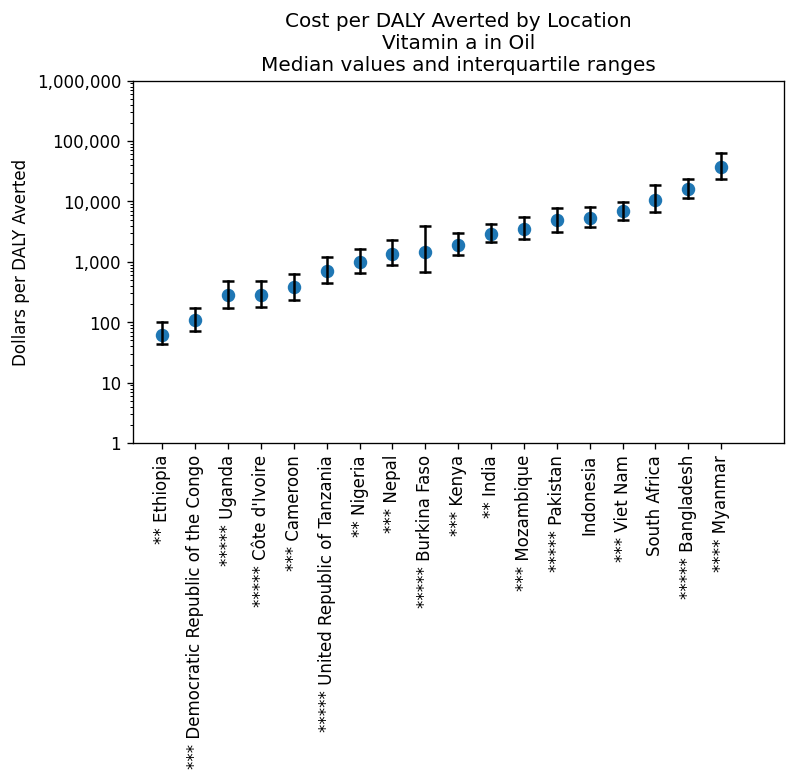

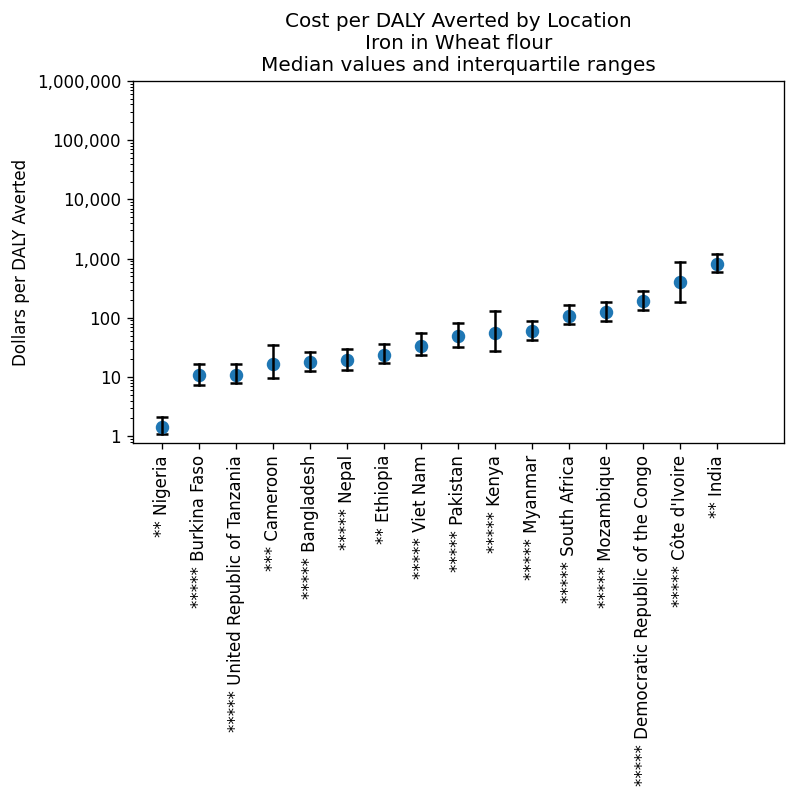

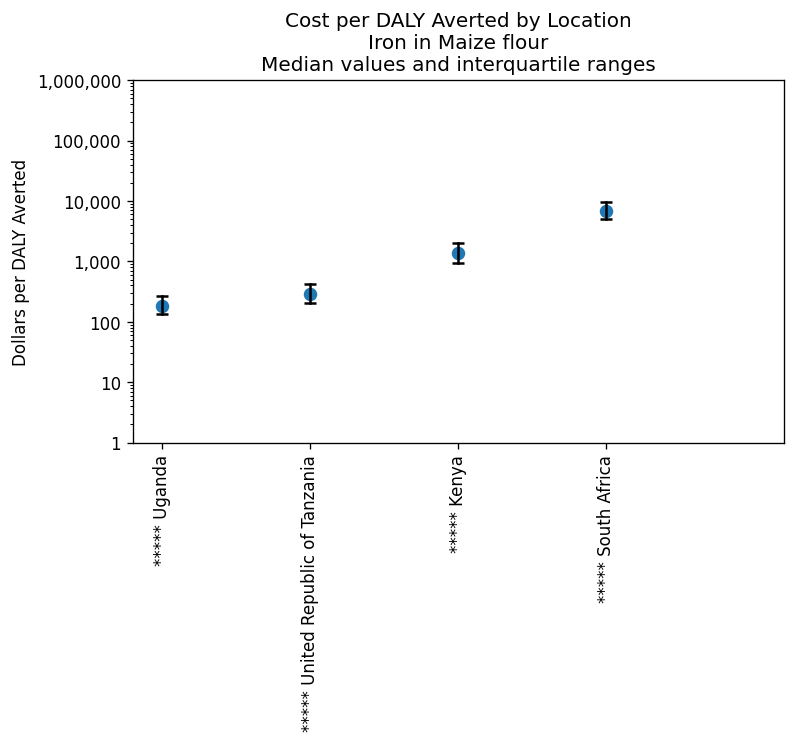

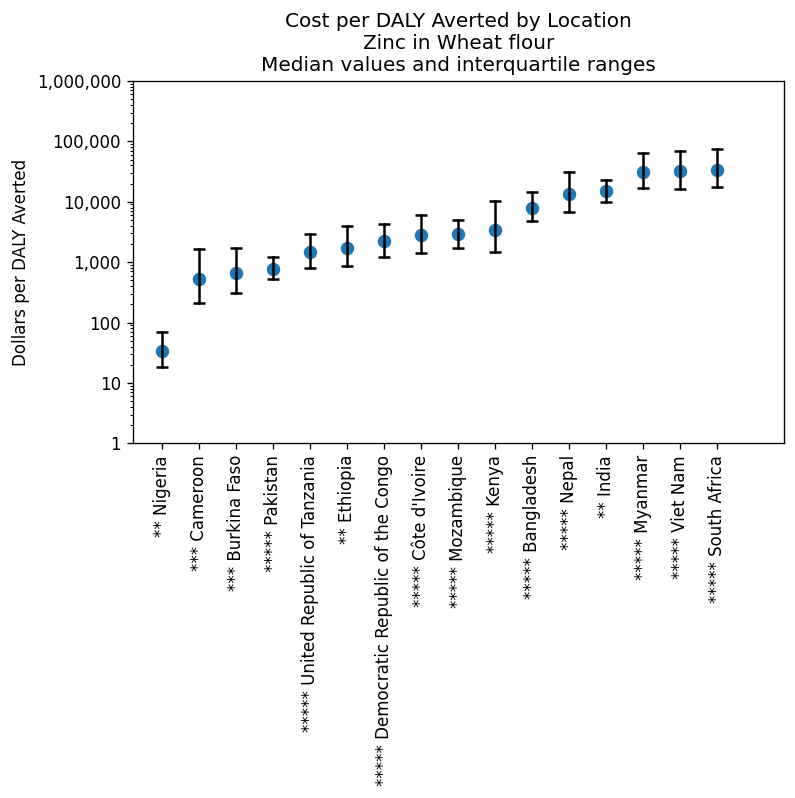

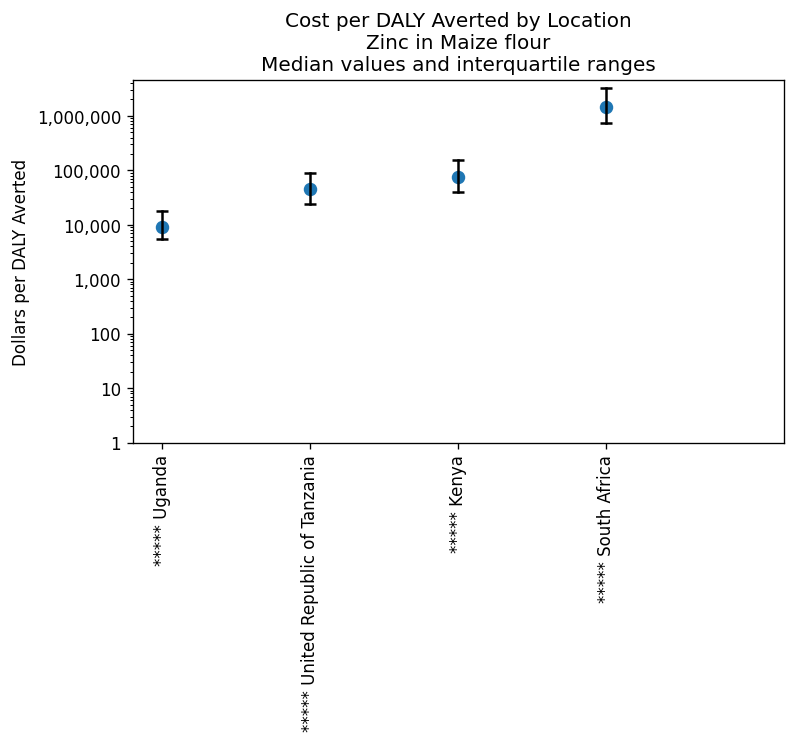

In [51]:
with PdfPages('results_plots/costs_per_daly_by_nutrient_vehicle_pair.pdf') as pdf:

    nutrients = ['vitamin A','iron','zinc']
    for nutrient in nutrients:
        if nutrient == 'vitamin A':
            vehicles = ['oil']
            value_cap = np.inf
        else:
            vehicles = ['wheat flour','maize flour']
        if nutrient == 'iron':
            value_cap = np.inf
        if nutrient == 'zinc':
            value_cap == np.inf
        for vehicle in vehicles:
            make_cost_per_daly_plots(results_icers, vehicle, nutrient, value_cap, confidence, True)
            pdf.savefig(bbox_inches='tight')

In [54]:
def make_location_specific_cost_per_daly_plots(data, location_id, uncertainty=True):
    df = data.loc[data.location_id == location_id]
    df['label'] = df.nutrient.str.capitalize() + ' in ' + df.vehicle
    
    f, ax = plt.subplots(figsize=(7, 4), dpi=120)
    colors = ['tab:red', 'tab:orange', 'tab:green']

    nutrient_spacer = 0.15
    x_vals = []
    for i in list(range(0, len(df))):
        if uncertainty: 
            plt.plot([nutrient_spacer * i, nutrient_spacer * i],
                     [df['25%'].values[i], df['75%'].values[i]], c='black')
            plt.scatter([nutrient_spacer * i], df['25%'].values[i], s=50, marker='_',
                        c='black')
            plt.scatter([nutrient_spacer * i], df['75%'].values[i], s=50, marker='_',
                        c='black')

        x_vals.append(nutrient_spacer * i)
    
    plt.scatter(x_vals, df['50%'], s=50)

    plt.hlines(0, 0,
               nutrient_spacer * (len(df)),
               linestyle='dashed', color='grey', alpha=0.5)
    
    plt.plot()
    
    plt.title(f'{df.location_name.unique()[0]}\nCost per DALY Averted by Nutrient and Vehicle Combination')
    plt.ylabel('Dollars per DALY Averted')

    x_ticks = []
    for x in list(range(0, len(df))):
        x_ticks.append(nutrient_spacer * x)
    ax.set_xticks(x_ticks)
    ax.set_xticklabels(df.label.values)
    plt.semilogy()
    plt.yticks(ticks=[1,10,100,1_000,10_000,100_000,1_000_000], labels=['1','10','100','1,000','10,000','100,000','1,000,000'])
    plt.xticks(rotation=90)

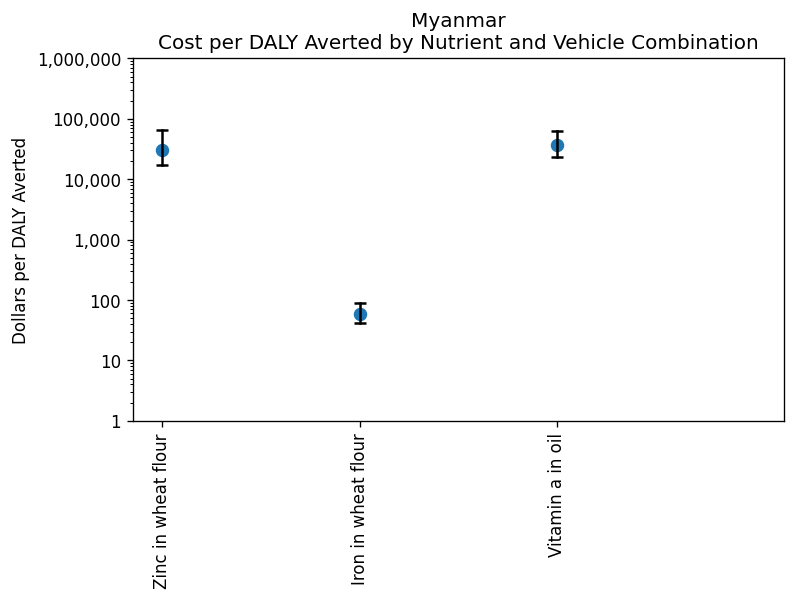

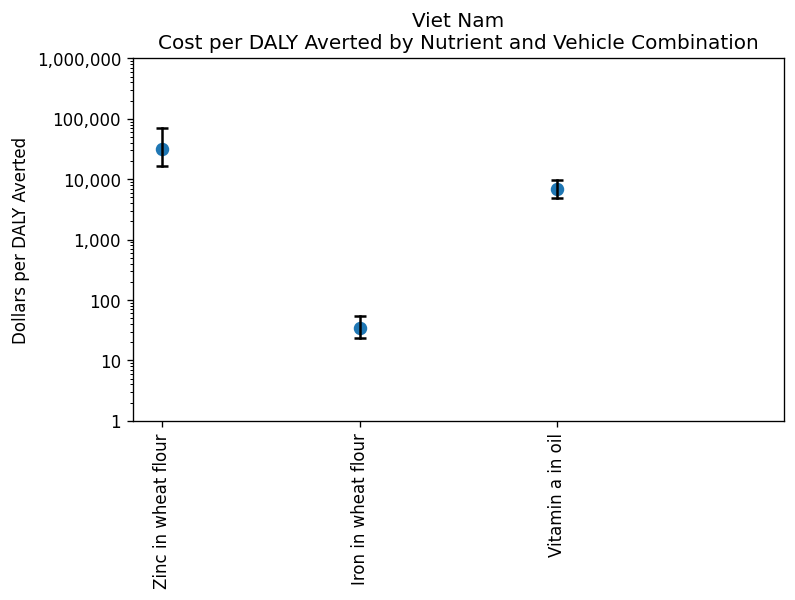

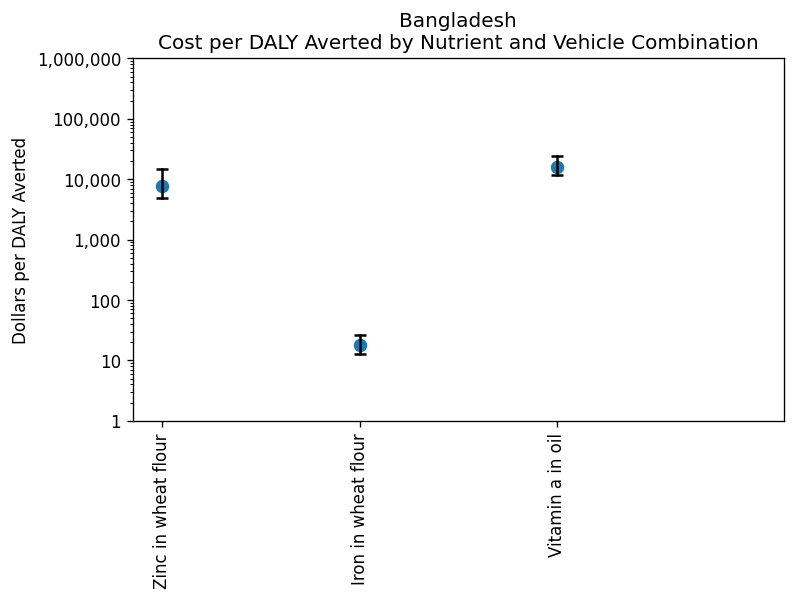

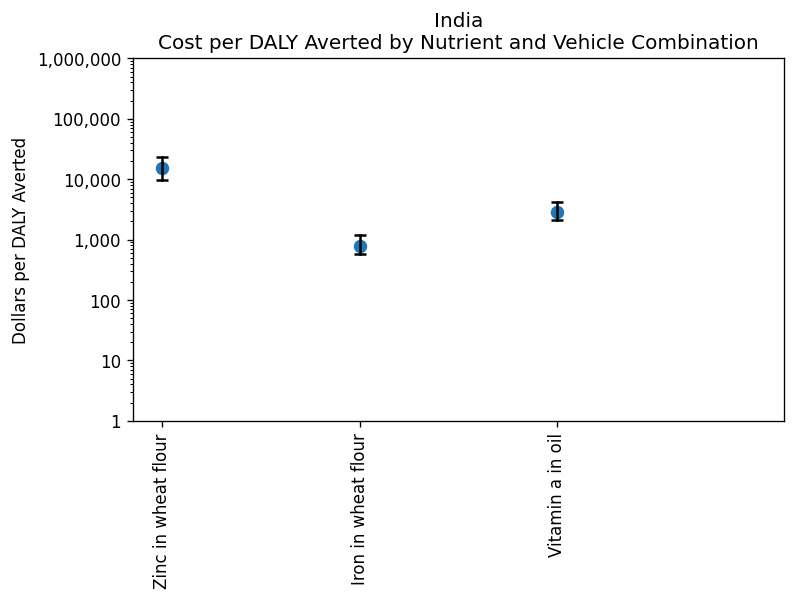

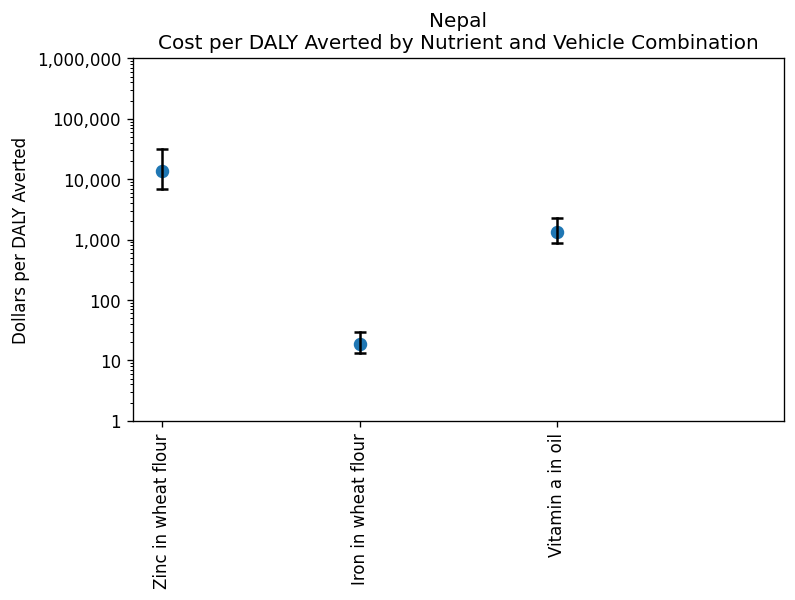

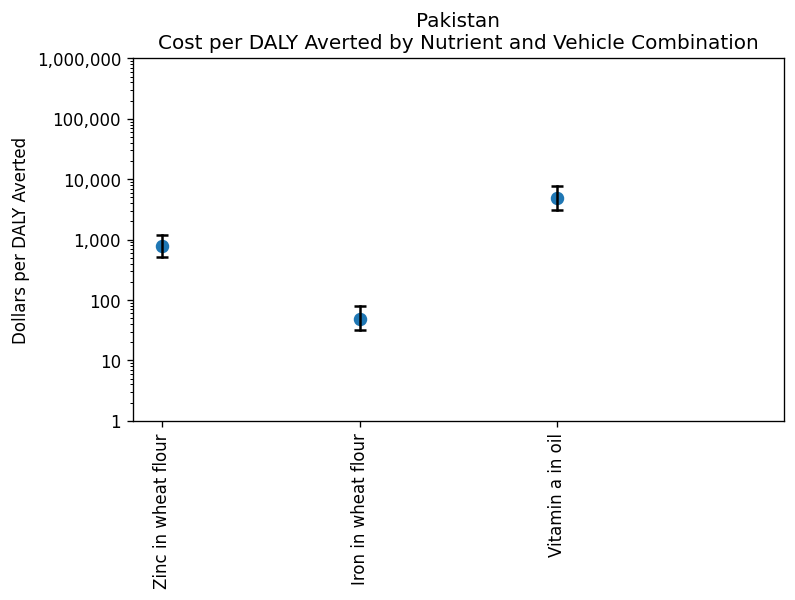

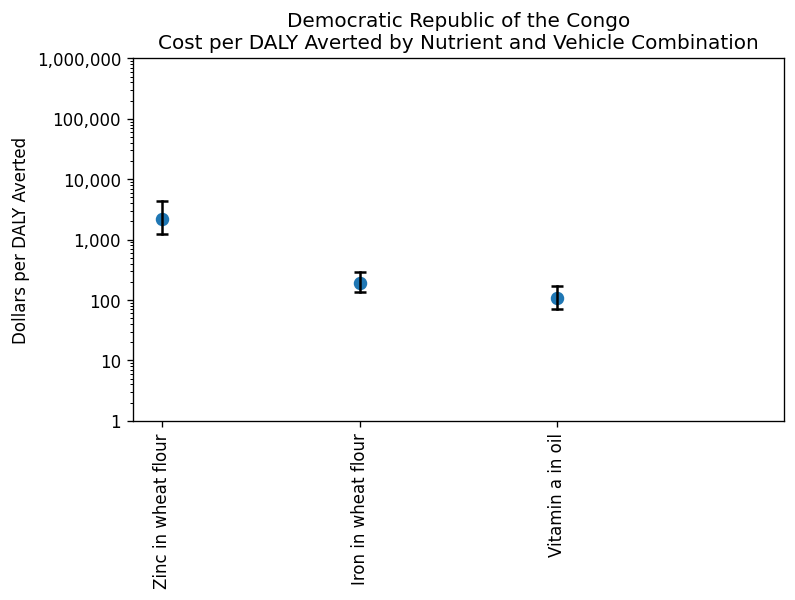

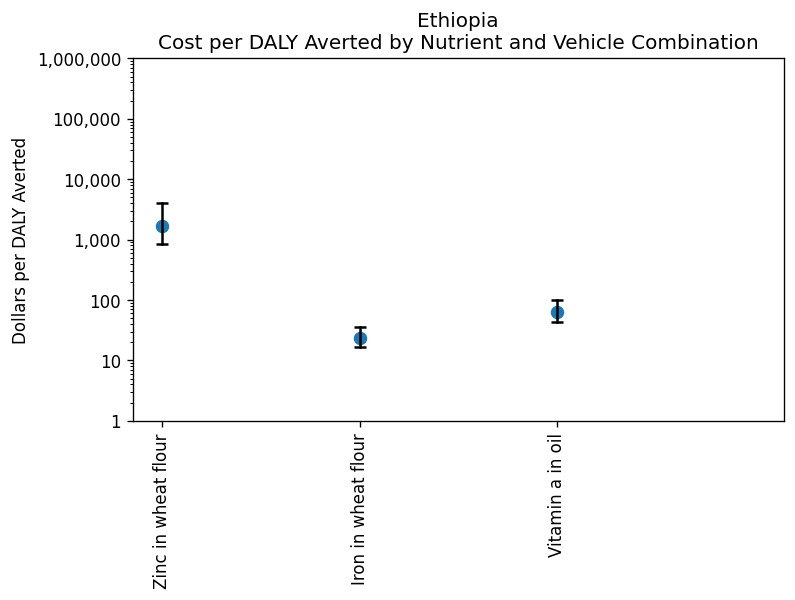

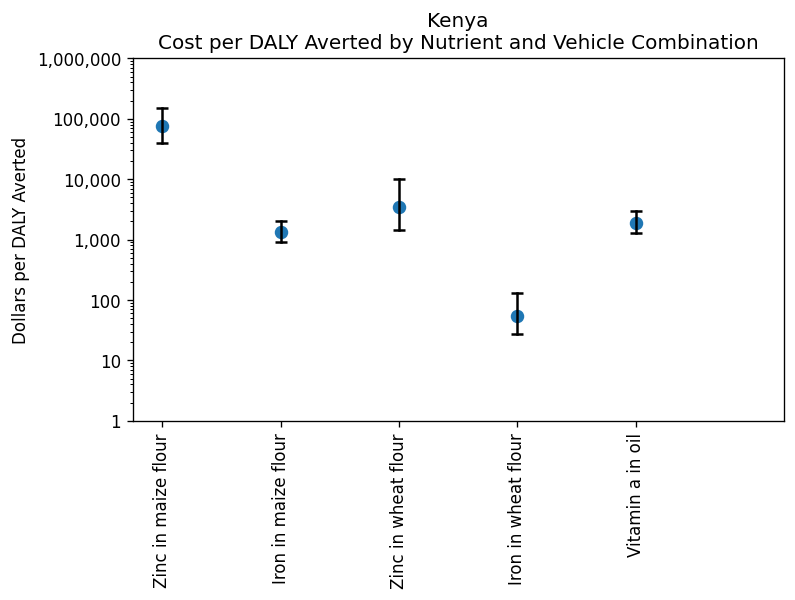

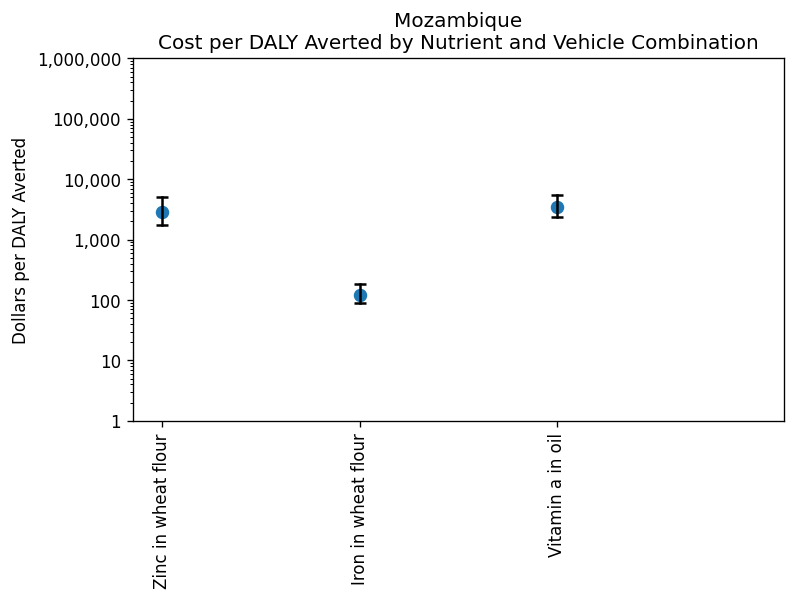

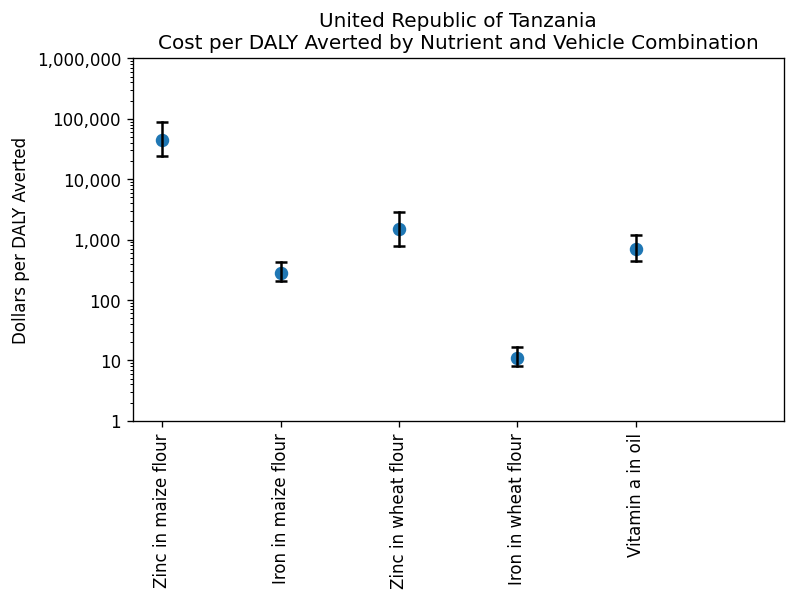

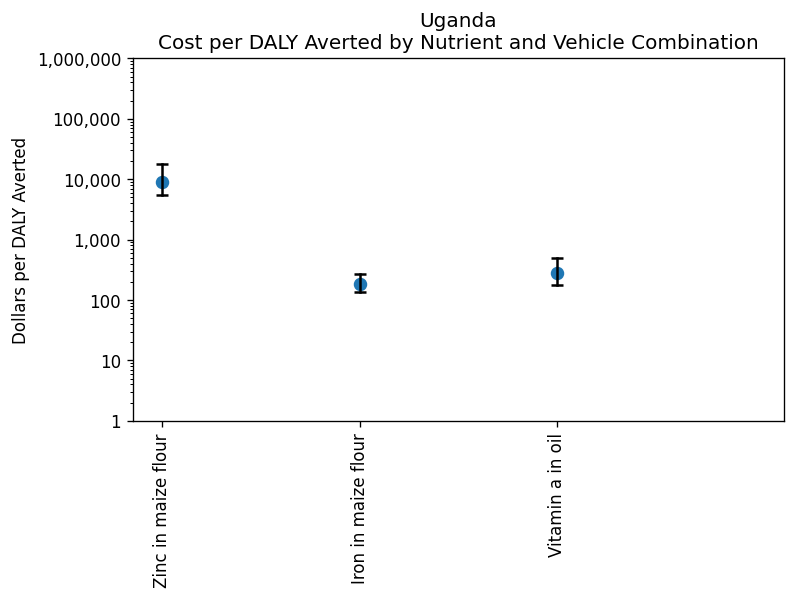

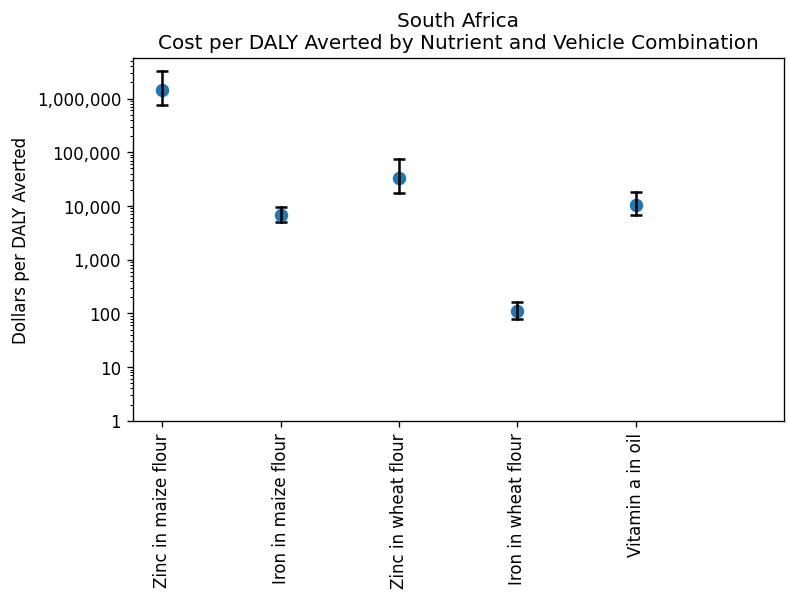

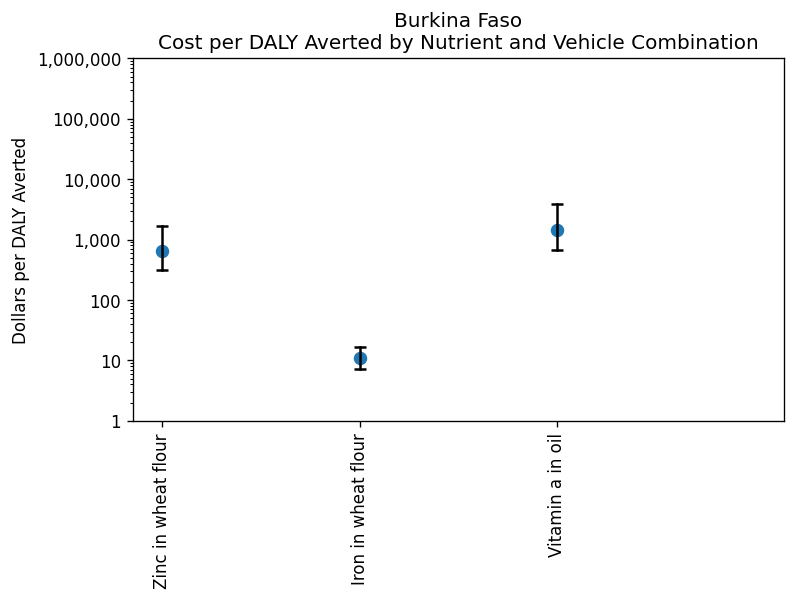

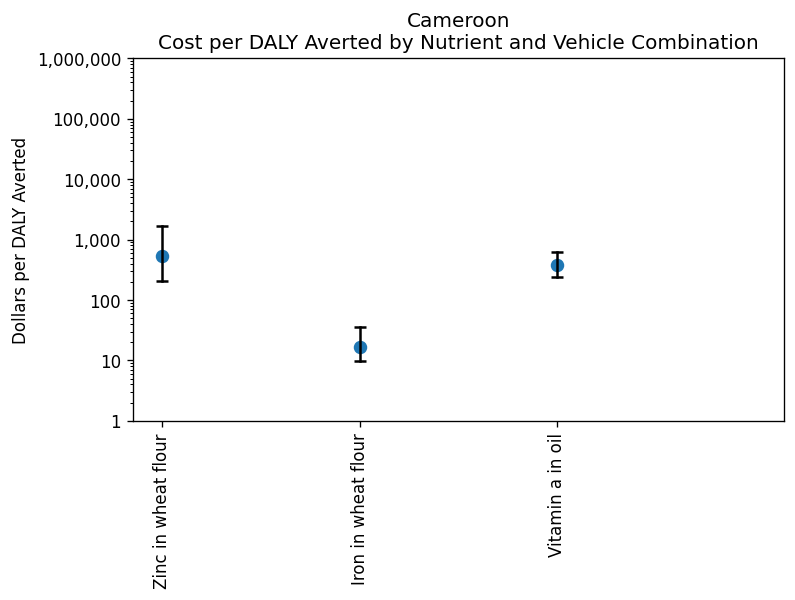

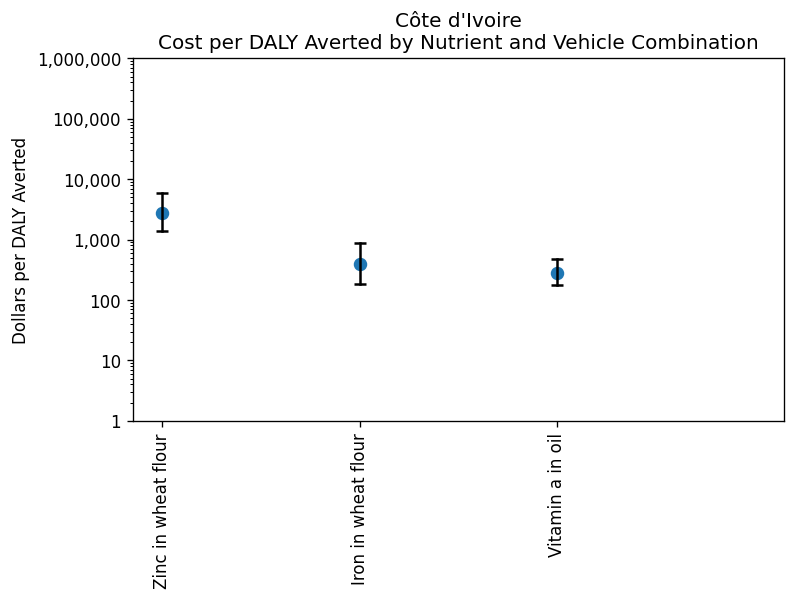

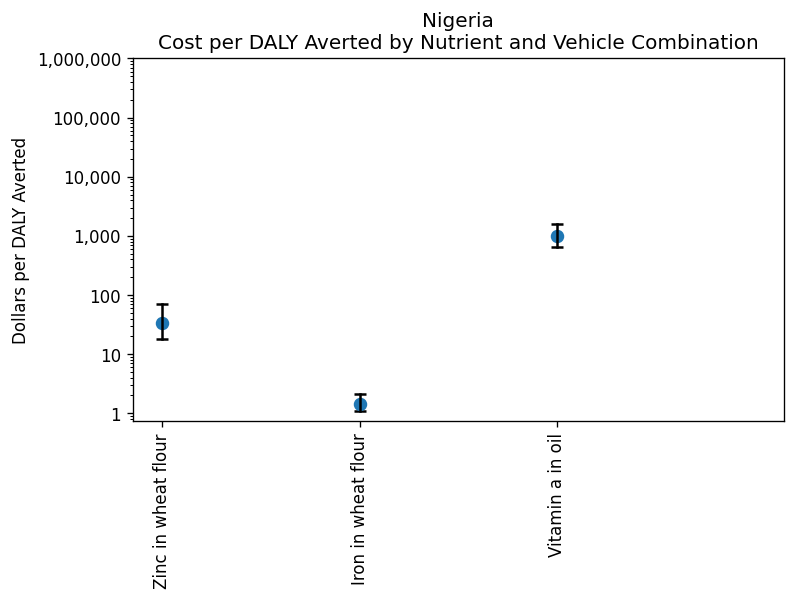

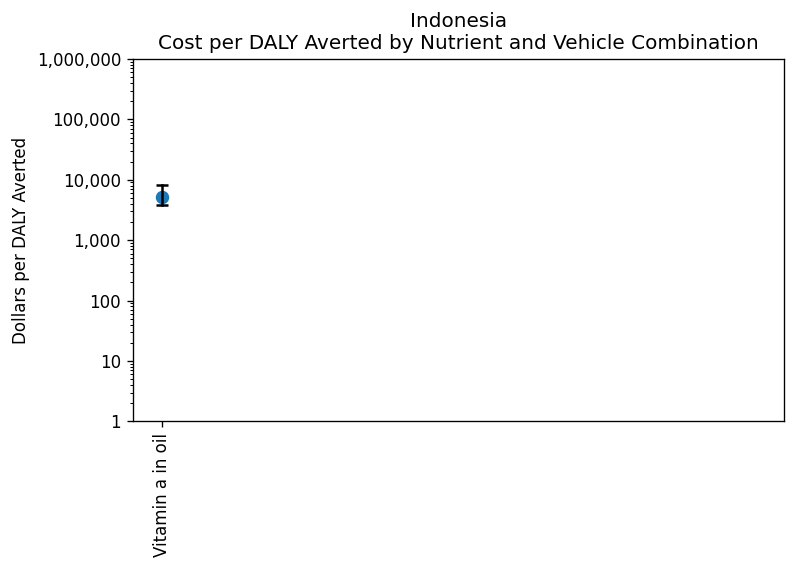

In [55]:
for location_id in results_icers.location_id.unique():
    #make_location_specific_cost_per_daly_plots(results_icers, location_id, uncertainty=True)
    make_location_specific_cost_per_daly_plots(results_icers, location_id, uncertainty=True)

# Final CSV

In [126]:
final_data_all_nutrients = (gbd_data.merge(coverage, on=['location_id','location_name'])
                           .merge(model_results_for_table.reset_index(), on='location_name')
                           .merge(cost, on='location_name')
                           .merge(icers, on='location_name')
                           .set_index(['location_id','location_name']))
final_data_zinc = final_data_all_nutrients[[c for c in final_data_all_nutrients.columns if 'Zinc' in c 
                                    or 'zinc' in c
                                    or 'fortifiable wheat flour' in c
                                    or 'fortifiable maize flour' in c
                                    or 'flour fortification cost' in c]].reset_index()
final_data_vitamin_a = final_data_all_nutrients[[c for c in final_data_all_nutrients.columns if 'itamin' in c 
                                    or 'oil' in c
                                    or 'Oil' in c]].reset_index().drop(columns=['Vitamin a in maize flour coverage data confidence score','Vitamin a in wheat flour coverage data confidence score'])
final_data_iron = final_data_all_nutrients[[c for c in final_data_all_nutrients.columns if 'Iron' in c 
                                    or 'iron' in c
                                    or 'fortifiable wheat flour' in c
                                    or 'fortifiable maize flour' in c
                                    or 'flour fortification cost' in c]].reset_index()

final_data_all_nutrients.to_csv('results_plots/final_data_all_nutrients.csv')
final_data_zinc.to_csv('results_plots/final_data_zinc.csv')
final_data_vitamin_a.to_csv('results_plots/final_data_vitamin_a.csv')
final_data_iron.to_csv('results_plots/final_data_iron.csv')

final_data_vitamin_a.head()

location_id                     location_name  \
0          161                        Bangladesh   
1          201                      Burkina Faso   
2          202                          Cameroon   
3          205                     Côte d'Ivoire   
4          171  Democratic Republic of the Congo   

  Baseline Prevalence of Vitamin A deficiency in age group Under 5 (per 100)  \
0                                 8.4\r\n(5.3, 12.8)                           
1                               35.4\r\n(26.0, 45.7)                           
2                               27.9\r\n(19.0, 38.5)                           
3                               26.2\r\n(18.3, 36.8)                           
4                               51.4\r\n(40.6, 62.5)                           

  Baseline Number in age group Under 5 with Vitamin A deficiency (1000s)  \
0                              1,156\r\n(727, 1,765)                       
1                            1,433\r\n(1,053, 1,848)                       
2                              1,174\r\n(798, 1,619)                       
3                              1,051\r\n(734, 1,475)                       
4                            7,010\r\n(5,528, 8,513)                       

  Baseline DALYs attributable to Vitamin A deficiency in age group Under 5 (1000s)  \
0                                 8.2\r\n(4.5, 13.3)                                 
1                              67.6\r\n(17.2, 144.7)                                 
2                              63.6\r\n(11.7, 137.4)                                 
3                                19.8\r\n(7.2, 42.7)                                 
4                             176.1\r\n(50.2, 390.1)                                 

  Baseline DALYs attributable to Vitamin A deficiency per 100,000 person-years in age group Under 5  \
0                                     59\r\n(32, 97)                                                  
1                              1,671\r\n(424, 3,576)                                                  
2                              1,511\r\n(279, 3,265)                                                  
3                                493\r\n(179, 1,063)                                                  
4                              1,292\r\n(369, 2,862)                                                  

  Percent of population eating fortifiable oil  \
0                         88.5\r\n(84.5, 92.4)   
1                                  Not modeled   
2                         73.9\r\n(72.4, 75.3)   
3                         98.0\r\n(97.0, 99.0)   
4                         41.3\r\n(40.5, 42.1)   

  Percent of population eating vitamin a fortified oil at baseline  \
0                               42.9\r\n(41.3, 44.4)                 
1                                        Not modeled                 
2          30.5\r\n(30.2, 30.8) 30.5\r\n(30.2, 30.8)                 
3          75.0\r\n(74.3, 75.7) 75.0\r\n(74.3, 75.7)                 
4                0.0\r\n(0.0, 0.0) 0.0\r\n(0.0, 0.0)                 

  Percent of population eating vitamin a fortified oil: 20% scale-up  \
0                               42.9\r\n(41.3, 44.4)                   
1                               57.6\r\n(35.2, 79.9)                   
2                               30.5\r\n(30.2, 30.8)                   
3          75.0\r\n(74.3, 75.7) 79.6\r\n(78.8, 80.3)                   
4                                  0.0\r\n(0.0, 0.0)                   

  Percent of population eating vitamin a fortified oil: 50% scale-up  ...  \
0                               65.7\r\n(62.9, 68.4)                  ...   
1                               55.5\r\n(32.8, 78.5)                  ...   
2                               52.2\r\n(51.3, 53.1)                  ...   
3          75.0\r\n(74.3, 75.7) 86.5\r\n(85.6, 87.3)                  ...   
4                               20.7\r\n(20.3, 21.1)                  ...   